# Метод, осонованный на анализе сегментов сигнала вокруг его R-пиков

In [1]:
import numpy as np
from scikits.audiolab import Sndfile
from scipy import signal
import seaborn as sns
import os
from scikits.audiolab import wavread, wavwrite
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from scipy.signal import wiener
import xgboost as xgb
from sklearn.model_selection  import GroupKFold
from biosppy.signals import ecg
from tqdm import tqdm
import math
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from itertools import chain
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
#import gensim
from scipy.signal import butter
from scipy.signal import medfilt
from scipy.stats import entropy
import numpy as np
from numpy.linalg import eig, inv
from matplotlib import pyplot as plt
from scipy.spatial.distance import chebyshev

In [2]:
from biosppy.signals.ecg import engzee_segmenter, gamboa_segmenter, hamilton_segmenter, ssf_segmenter

In [3]:
import lasagne
import theano.tensor as T
import theano
import train_support
import numpy as np
from sklearn.utils import shuffle

/Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
%load_ext autoreload
%autoreload 2

## Чтение данных

In [13]:
def read_frame(directory, filename):
    data, sample_frequency, encoding = wavread(directory + "/" + filename)
    return np.array(data)

def get_frames(directory, files):
    frames = []
    for i in files:
        patient = i.split("_")[0]
        ecg_id = i[:-4]
        a = read_frame(directory, i)
        frames.append([a, patient, ecg_id])
    frames = np.array(frames)
    return np.swapaxes(frames, 0, 1)

In [14]:
def create_data_frame_from_wav(true_files_dir, false_files_dir):
    true_files = filter(lambda x: x.endswith(".wav"), os.listdir(true_files_dir))
    false_files = filter(lambda x: x.endswith(".wav"), os.listdir(false_files_dir))
    true_frames = get_frames(true_files_dir, true_files)
    false_frames = get_frames(false_files_dir, false_files)
    a = create_data_frame(true_frames, True)
    b = create_data_frame(false_frames, False)
    df = a.append(b).copy()
    del a
    del b
    df = shuffle(df, random_state=27)
    df = df.reset_index()
    df.drop("index", axis=1, inplace=True)
    df["SignalLen"] = df["S"].apply(lambda x: len(x))
    df = df[df["SignalLen"] != 0].copy()
    return df

In [15]:
def create_data_frame(data, ibs):
    df = pd.DataFrame({"S":data[0], "Patient": data[1], "ECG_ID":data[2], "ibs":ibs})
    return df

In [17]:
df_train = create_data_frame_from_wav("wav/true/", "wav/false/")
df_test = create_data_frame_from_wav("wav_test/true/", "wav_test/false/")

In [21]:
ecg_ids = pd.read_csv("test_ids.csv", header=None)
df_test = df_test[df_test["ECG_ID"].isin(ecg_ids[0])]

In [25]:
def get_max(x, r):
    w = 10
    d = []
    for i in r:
        if i > 5:
            c = np.argmax(x[i-5: i+5])
            d.append(c+i-5)
    return d

In [26]:
from tqdm import tqdm
tqdm.pandas(desc="TQDM")

## Выделение окон вокруг R-пиков

In [27]:
df_train["RPeaks"] = df_train["S"].progress_apply(lambda x: get_max(x, hamilton_segmenter(x)[0]))
df_test["RPeaks"] = df_test["S"].progress_apply(lambda x: get_max(x, hamilton_segmenter(x)[0]))


TQDM: 100%|██████████| 1567/1567 [05:38<00:00,  4.31it/s]


In [28]:
def extract_window_average(x, before, after):
    signal = x[0]
    slen = len(signal)
    rpeaks = filter(lambda rpeak : ((rpeak - before > 0) and (rpeak + after < slen)), x[1])
    
    windows = np.array([signal[rpeak - before:rpeak + after] for rpeak in rpeaks])
    return windows.mean(axis = 0)

In [29]:
def extract_wa_features(df, new_features_cols, signal_col_name, rpeak_col_name, before = 200, after = 500):
    new_features = np.array([extract_window_average(k, before, after) for k in df[["S", "RPeaks"]].as_matrix()])
    
    df_new = pd.DataFrame(index = df.index, columns = new_features_cols, data = new_features)
    return pd.concat([df, df_new], axis = 1)

In [31]:
before = 200
after = 500
wa_features_cols = ["".join(["RPwindowaverage_", str(k)]) for k in range(1, before+after+1)]

In [32]:
df_train = extract_wa_features(df_train, wa_features_cols, "S", "RPeaks", 200, 500)
df_test = extract_wa_features(df_test, wa_features_cols, "S", "RPeaks", 200, 500)

## Функции для кросс-валидации и обучения

In [44]:
def combine_results(clf_res, cv, length):
    a = np.zeros(length)
    pr = np.zeros(length)
    
    for res, i in zip(clf_res, cv):
        itrain, itest = i
        
        a[itest] = res["p_test"]
        pr[itest] = res["pr_test"]
        
    return a, pr

In [45]:
def cv_tt(df, target, cv):
    tt = []
    data = df.drop(target, axis = 1)
    y = df[target]
    for itrain, itest in cv:
        train_data = data.loc[itrain,:]
        test_data = data.loc[itest,:]
        train_data.reset_index(inplace=True)
        test_data.reset_index(inplace=True)
        fold = {"xtrain" : train_data, "ytrain" : y[itrain], 
                "xtest" : test_data, "ytest" : y[itest]}
        tt.append(fold)
    return tt

In [46]:
def review(df, p=None, pr=None, target="ibs", plot = True, text = True):
    lsp = np.linspace(0, 1, 201)
    if pr is not None:
        s = [pd.DataFrame({'label':df["Patient"], 'q':(df[target] == (pr >= l).astype(float))}).q.mean() for l in lsp]
        patients = [pd.DataFrame({'label':df["Patient"], 
                       'q':(df[target] == (pr >= l).astype(float))}).groupby('label')['q'].mean().mean() for l in lsp]
    
    if plot: 
        plt.figure(figsize = (8, 4))    
        plt.plot(lsp, patients, lw=2)
        plt.plot(lsp, s, lw=2)
        plt.xlabel('threshold')
        plt.ylabel('quality')
    if p is not None: 
        tmp = pd.DataFrame({'label':df["Patient"], 'q':df[target] == p})
    tmax = np.argmax(patients)
    
    if text:
        print ('roc-auc = ' + str(roc_auc_score(df[target], pr)))
        if p is not None:
            print ("Оценка границы разбиения по умолчанию:")      
            print ('Качество по сигналам = ' + str(tmp.q.mean()))
            print ('Качество по людям = ' + str(tmp.groupby('label')['q'].mean().mean()))
        print ("Наилучшее разбиение происходит при границе " + str(lsp[tmax]))
        print ('Качество по сигналам = ' + str(s[tmax]))
        print ('Качество по людям = ' + str(patients[tmax]))
    
    return patients[tmax]

In [47]:
def fit_predict(clf, xtrain, ytrain, xtest, ytest, clf_params, 
               fit_params, do_scaling, xgbfit, nnfit):
    if do_scaling:
        scaler = StandardScaler()
        xtrain = scaler.fit_transform(xtrain)
        xtest = scaler.transform(xtest)    
        
    if xgbfit:
        fit_params["eval_set"] = \
            [(xtrain, ytrain), (xtest, ytest)]
        fit_params["sample_weight"] = \
            np.array(get_weight(ytrain))
    if nnfit:
        fit_params["w"] = \
            np.array(get_weight(ytrain))
            
    c = clf(**clf_params)
#    c.fit(xtrain, ytrain, **fit_params)
    answer = c.fit_predict(xtrain, ytrain, xtest, ytest, **fit_params)
    
    p_tst = answer[0]
    pr_tst = answer[1]
    
#    p_tst = c.predict(xtest)
#    pr_tst = c.predict_proba(xtest)[:,1]
    
    return p_tst, pr_tst

In [48]:
def cv_fit_predict(clf, cv_tt, f_l, clf_params = {}, fit_params = {},
                   do_scaling = False, xgbfit = False, nnfit = False):
    cv_answer = []
    
    for fold in tqdm(cv_tt):
        p_tst, pr_tst = fit_predict(clf, fold["xtrain"][f_l], fold["ytrain"], 
                                      fold["xtest"][f_l], fold["ytest"], 
                                      clf_params, fit_params, do_scaling, xgbfit, nnfit)
        tt_answer = {"p_test" : p_tst, "pr_test" : pr_tst}
        cv_answer.append(tt_answer)
    
    return cv_answer

## Классификатор на основе нейронной сети

In [49]:
class network_for_classifier():
    def __init__(self, input_shape = 700, layers_conf = [700, 700]):
        self.input_var = T.tensor4('input')
        
        self.build_network(input_shape, layers_conf)
        
    def build_network(self, input_shape, layers_conf):
        assert len(layers_conf) >= 1
        
        self.l_in = lasagne.layers.InputLayer(shape=(None, 1, 1, input_shape), input_var=self.input_var)
        
        self.layers = [self.l_in]
        
        for cell_num in layers_conf:
            new_layer = lasagne.layers.DenseLayer(self.layers[-1], cell_num, W= lasagne.init.Normal(0.001), nonlinearity=lasagne.nonlinearities.sigmoid)
            self.layers += [new_layer]
            
        self.l_output = lasagne.layers.DenseLayer(self.layers[-1], 1, W= lasagne.init.Normal(0.001), nonlinearity=lasagne.nonlinearities.sigmoid)
        
    def get_output(self):
        return self.l_output
    
    
    def get_input(self):
        return self.input_var

In [66]:
class NNC():
    def __init__(self, input_shape = 700, layers_conf = [700, 700]):
        self.nn = network_for_classifier(input_shape, layers_conf)
 
    def fit_predict(self, x_train, y_train, x_test, y_test):
        train_shape = x_train.shape
        test_shape = x_test.shape
        
        x_train = x_train.reshape(train_shape[0], 1, 1, train_shape[1])
        x_test = x_test.reshape(test_shape[0], 1, 1, test_shape[1])
        
        y_train = y_train.values
        y_test = y_test.values
        
        ret = train_support.train(self.nn.get_output(), self.nn.get_input(), 
                                  x_train, y_train, x_test, y_test,
                                  learning_rate=0.0001, grad_clipping=200, 
                                  batch_size=5, num_epochs=100)
        lasagne.layers.set_all_param_values(self.nn.get_output(), ret[0])
        
        pr = ret[4]
        
        p = np.zeros(pr.shape)
        p[pr>0.5] = 1
        
        return p, pr
    
    def predict(self, x):
        x_shape = x.shape
        x = x.reshape(x_shape[0], 1, 1, x_shape[1])
        return train_support.predict(self.nn.get_output(), self.nn.get_input(), x)

In [67]:
def get_prediction(clf, x_train, y_train, x_test, y_test, x_val, f_l, fit_params, clf_params, do_scaling=True):
    if do_scaling:
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train[f_l])
        x_test = scaler.transform(x_test[f_l])    
        x_val = scaler.transform(x_val[f_l])
            
    c = clf(**clf_params)

    p_tst, pr_tst = c.fit_predict(x_train, y_train, x_test, y_test, **fit_params)
    pr = c.predict(x_val)
    
    p = np.zeros(pr.shape)
    p[pr>0.5] = 1
        
    return p, pr, p_tst, pr_tst 

## Результаты на отложенной тестовой выборке (Выделение теста для остановки нейросети)

In [68]:
train_df_for_test = shuffle(df_train, random_state=10)
gkf = GroupKFold(n_splits=12)
cv = list(gkf.split(train_df_for_test, train_df_for_test["ibs"], groups=train_df_for_test["Patient"]))   

x_train = train_df_for_test.loc[cv[0][0],:].copy()
x_test = train_df_for_test.loc[cv[0][1],:].copy()


x_train.reset_index(inplace=True)
y_train = x_train["ibs"]
x_train.drop("ibs", axis=1, inplace=True)

x_test.reset_index(inplace=True)
y_test = x_test["ibs"]
x_test.drop("ibs", axis=1, inplace=True)

In [69]:
x_val = df_test.drop("ibs", axis=1)

In [70]:
nnclf_params = {"input_shape":700, "layers_conf":[700]}
nnfit_params = {}

nn_f = wa_features_cols

p_val, pr_val, p_test, pr_test = get_prediction(NNC, x_train, y_train, x_test, y_test, x_val, nn_f, nnfit_params, nnclf_params, do_scaling=True)

  1%|          | 1/100 [00:02<04:21,  2.64s/it]

epoch 1 / 100 in 2.6s: loss 0.693630, trval_rocauc 0.794102, val_rocauc 0.859218, lr 0.000100


  2%|▏         | 2/100 [00:05<04:19,  2.64s/it]

epoch 2 / 100 in 2.6s: loss 0.691247, trval_rocauc 0.828628, val_rocauc 0.869440, lr 0.000100


  3%|▎         | 3/100 [00:07<04:16,  2.65s/it]

epoch 3 / 100 in 2.7s: loss 0.688055, trval_rocauc 0.834382, val_rocauc 0.873745, lr 0.000100


  4%|▍         | 4/100 [00:10<04:20,  2.71s/it]

epoch 4 / 100 in 2.8s: loss 0.686822, trval_rocauc 0.847509, val_rocauc 0.865495, lr 0.000100


  5%|▌         | 5/100 [00:13<04:16,  2.69s/it]

epoch 5 / 100 in 2.7s: loss 0.690976, trval_rocauc 0.854702, val_rocauc 0.851506, lr 0.000100


  6%|▌         | 6/100 [00:16<04:14,  2.71s/it]

epoch 6 / 100 in 2.7s: loss 0.690255, trval_rocauc 0.866930, val_rocauc 0.873924, lr 0.000100


  7%|▋         | 7/100 [00:18<04:13,  2.73s/it]

epoch 7 / 100 in 2.8s: loss 0.687071, trval_rocauc 0.852904, val_rocauc 0.888989, lr 0.000100


  8%|▊         | 8/100 [00:21<04:16,  2.79s/it]

epoch 8 / 100 in 2.9s: loss 0.687502, trval_rocauc 0.867290, val_rocauc 0.870696, lr 0.000100


  9%|▉         | 9/100 [00:24<04:10,  2.75s/it]

epoch 9 / 100 in 2.7s: loss 0.686938, trval_rocauc 0.862255, val_rocauc 0.880560, lr 0.000100


 10%|█         | 10/100 [00:27<04:08,  2.76s/it]

epoch 10 / 100 in 2.8s: loss 0.689377, trval_rocauc 0.852005, val_rocauc 0.886836, lr 0.000100


 11%|█         | 11/100 [00:30<04:16,  2.89s/it]

epoch 11 / 100 in 3.2s: loss 0.686634, trval_rocauc 0.862615, val_rocauc 0.883429, lr 0.000100


 12%|█▏        | 12/100 [00:34<04:29,  3.07s/it]

epoch 12 / 100 in 3.5s: loss 0.684255, trval_rocauc 0.859198, val_rocauc 0.887554, lr 0.000100


 13%|█▎        | 13/100 [00:36<04:22,  3.01s/it]

epoch 13 / 100 in 2.9s: loss 0.687991, trval_rocauc 0.857580, val_rocauc 0.887912, lr 0.000100


 14%|█▍        | 14/100 [00:39<04:19,  3.02s/it]

epoch 14 / 100 in 3.0s: loss 0.688556, trval_rocauc 0.860816, val_rocauc 0.871593, lr 0.000100


 15%|█▌        | 15/100 [00:43<04:24,  3.11s/it]

epoch 15 / 100 in 3.3s: loss 0.686295, trval_rocauc 0.869088, val_rocauc 0.879304, lr 0.000100


 16%|█▌        | 16/100 [00:46<04:20,  3.10s/it]

epoch 16 / 100 in 3.1s: loss 0.688603, trval_rocauc 0.868549, val_rocauc 0.878049, lr 0.000100


 17%|█▋        | 17/100 [00:49<04:21,  3.14s/it]

epoch 17 / 100 in 3.2s: loss 0.688885, trval_rocauc 0.862075, val_rocauc 0.882174, lr 0.000100


 18%|█▊        | 18/100 [00:52<04:08,  3.03s/it]

epoch 18 / 100 in 2.8s: loss 0.687359, trval_rocauc 0.873224, val_rocauc 0.892217, lr 0.000100


 19%|█▉        | 19/100 [00:55<03:57,  2.94s/it]

epoch 19 / 100 in 2.7s: loss 0.685534, trval_rocauc 0.880237, val_rocauc 0.890065, lr 0.000100


 20%|██        | 20/100 [00:57<03:48,  2.86s/it]

epoch 20 / 100 in 2.7s: loss 0.687320, trval_rocauc 0.886351, val_rocauc 0.887733, lr 0.000100


 21%|██        | 21/100 [01:00<03:41,  2.81s/it]

epoch 21 / 100 in 2.7s: loss 0.685804, trval_rocauc 0.894803, val_rocauc 0.887912, lr 0.000100


 22%|██▏       | 22/100 [01:03<03:35,  2.76s/it]

epoch 22 / 100 in 2.7s: loss 0.686627, trval_rocauc 0.889229, val_rocauc 0.886119, lr 0.000100


 23%|██▎       | 23/100 [01:05<03:30,  2.73s/it]

epoch 23 / 100 in 2.6s: loss 0.687489, trval_rocauc 0.888509, val_rocauc 0.888092, lr 0.000100


 24%|██▍       | 24/100 [01:08<03:25,  2.70s/it]

epoch 24 / 100 in 2.6s: loss 0.685407, trval_rocauc 0.889588, val_rocauc 0.890961, lr 0.000100


 25%|██▌       | 25/100 [01:11<03:21,  2.69s/it]

epoch 25 / 100 in 2.7s: loss 0.686860, trval_rocauc 0.889768, val_rocauc 0.885402, lr 0.000100


 26%|██▌       | 26/100 [01:13<03:18,  2.68s/it]

epoch 26 / 100 in 2.7s: loss 0.684147, trval_rocauc 0.894264, val_rocauc 0.890782, lr 0.000100


 27%|██▋       | 27/100 [01:16<03:15,  2.67s/it]

epoch 27 / 100 in 2.7s: loss 0.689221, trval_rocauc 0.890667, val_rocauc 0.881815, lr 0.000100


 28%|██▊       | 28/100 [01:19<03:11,  2.67s/it]

epoch 28 / 100 in 2.7s: loss 0.690026, trval_rocauc 0.887970, val_rocauc 0.888630, lr 0.000100


 29%|██▉       | 29/100 [01:21<03:08,  2.66s/it]

epoch 29 / 100 in 2.6s: loss 0.686034, trval_rocauc 0.887250, val_rocauc 0.894548, lr 0.000100


 30%|███       | 30/100 [01:24<03:06,  2.66s/it]

epoch 30 / 100 in 2.7s: loss 0.685904, trval_rocauc 0.893365, val_rocauc 0.897418, lr 0.000100


 31%|███       | 31/100 [01:26<03:03,  2.66s/it]

epoch 31 / 100 in 2.7s: loss 0.686862, trval_rocauc 0.907930, val_rocauc 0.886836, lr 0.000100


 32%|███▏      | 32/100 [01:29<03:00,  2.66s/it]

epoch 32 / 100 in 2.7s: loss 0.687578, trval_rocauc 0.901816, val_rocauc 0.897418, lr 0.000100


 33%|███▎      | 33/100 [01:32<02:58,  2.66s/it]

epoch 33 / 100 in 2.7s: loss 0.687115, trval_rocauc 0.904514, val_rocauc 0.895803, lr 0.000100


 34%|███▍      | 34/100 [01:34<02:55,  2.66s/it]

epoch 34 / 100 in 2.7s: loss 0.683291, trval_rocauc 0.901816, val_rocauc 0.896700, lr 0.000100


 35%|███▌      | 35/100 [01:37<02:52,  2.66s/it]

epoch 35 / 100 in 2.7s: loss 0.687164, trval_rocauc 0.901816, val_rocauc 0.895624, lr 0.000100


 36%|███▌      | 36/100 [01:40<02:50,  2.66s/it]

epoch 36 / 100 in 2.7s: loss 0.687286, trval_rocauc 0.905772, val_rocauc 0.897418, lr 0.000100


 37%|███▋      | 37/100 [01:42<02:47,  2.66s/it]

epoch 37 / 100 in 2.7s: loss 0.685427, trval_rocauc 0.906851, val_rocauc 0.914096, lr 0.000100


 38%|███▊      | 38/100 [01:45<02:51,  2.77s/it]

epoch 38 / 100 in 3.0s: loss 0.683821, trval_rocauc 0.904154, val_rocauc 0.906026, lr 0.000100


 39%|███▉      | 39/100 [01:48<02:50,  2.79s/it]

epoch 39 / 100 in 2.9s: loss 0.686996, trval_rocauc 0.908290, val_rocauc 0.913558, lr 0.000100


 40%|████      | 40/100 [01:51<02:47,  2.79s/it]

epoch 40 / 100 in 2.8s: loss 0.685900, trval_rocauc 0.907930, val_rocauc 0.907819, lr 0.000100


 41%|████      | 41/100 [01:54<02:43,  2.78s/it]

epoch 41 / 100 in 2.7s: loss 0.685725, trval_rocauc 0.912246, val_rocauc 0.904770, lr 0.000100


 42%|████▏     | 42/100 [01:57<02:40,  2.77s/it]

epoch 42 / 100 in 2.8s: loss 0.679947, trval_rocauc 0.907211, val_rocauc 0.909254, lr 0.000100


 43%|████▎     | 43/100 [01:59<02:37,  2.77s/it]

epoch 43 / 100 in 2.8s: loss 0.685004, trval_rocauc 0.912066, val_rocauc 0.897059, lr 0.000100


 44%|████▍     | 44/100 [02:02<02:36,  2.80s/it]

epoch 44 / 100 in 2.9s: loss 0.685811, trval_rocauc 0.913685, val_rocauc 0.908178, lr 0.000100


 45%|████▌     | 45/100 [02:05<02:32,  2.76s/it]

epoch 45 / 100 in 2.7s: loss 0.685498, trval_rocauc 0.902715, val_rocauc 0.892755, lr 0.000100


 46%|████▌     | 46/100 [02:08<02:27,  2.73s/it]

epoch 46 / 100 in 2.7s: loss 0.684620, trval_rocauc 0.911167, val_rocauc 0.899570, lr 0.000100


 47%|████▋     | 47/100 [02:10<02:23,  2.71s/it]

epoch 47 / 100 in 2.7s: loss 0.685624, trval_rocauc 0.912426, val_rocauc 0.906564, lr 0.000100


 48%|████▊     | 48/100 [02:13<02:20,  2.70s/it]

epoch 48 / 100 in 2.7s: loss 0.689374, trval_rocauc 0.915303, val_rocauc 0.896700, lr 0.000100


 49%|████▉     | 49/100 [02:16<02:18,  2.71s/it]

epoch 49 / 100 in 2.8s: loss 0.683130, trval_rocauc 0.915842, val_rocauc 0.907999, lr 0.000100


 50%|█████     | 50/100 [02:18<02:16,  2.73s/it]

epoch 50 / 100 in 2.7s: loss 0.683605, trval_rocauc 0.914943, val_rocauc 0.899211, lr 0.000100


 51%|█████     | 51/100 [02:21<02:12,  2.71s/it]

epoch 51 / 100 in 2.7s: loss 0.685899, trval_rocauc 0.918180, val_rocauc 0.914096, lr 0.000100


 52%|█████▏    | 52/100 [02:24<02:09,  2.70s/it]

epoch 52 / 100 in 2.7s: loss 0.686324, trval_rocauc 0.884733, val_rocauc 0.886836, lr 0.000100


 53%|█████▎    | 53/100 [02:26<02:06,  2.69s/it]

epoch 53 / 100 in 2.7s: loss 0.684509, trval_rocauc 0.903075, val_rocauc 0.917683, lr 0.000100


 54%|█████▍    | 54/100 [02:29<02:03,  2.68s/it]

epoch 54 / 100 in 2.7s: loss 0.683716, trval_rocauc 0.914044, val_rocauc 0.927726, lr 0.000100


 55%|█████▌    | 55/100 [02:32<02:00,  2.68s/it]

epoch 55 / 100 in 2.7s: loss 0.686242, trval_rocauc 0.910987, val_rocauc 0.908178, lr 0.000100


 56%|█████▌    | 56/100 [02:34<01:57,  2.68s/it]

epoch 56 / 100 in 2.7s: loss 0.685799, trval_rocauc 0.919619, val_rocauc 0.907461, lr 0.000100


 57%|█████▋    | 57/100 [02:37<01:54,  2.67s/it]

epoch 57 / 100 in 2.7s: loss 0.690133, trval_rocauc 0.922856, val_rocauc 0.908716, lr 0.000100


 58%|█████▊    | 58/100 [02:40<01:52,  2.67s/it]

epoch 58 / 100 in 2.7s: loss 0.686769, trval_rocauc 0.912785, val_rocauc 0.909433, lr 0.000100


 59%|█████▉    | 59/100 [02:42<01:49,  2.67s/it]

epoch 59 / 100 in 2.7s: loss 0.684612, trval_rocauc 0.915663, val_rocauc 0.921270, lr 0.000100


 60%|██████    | 60/100 [02:45<01:46,  2.67s/it]

epoch 60 / 100 in 2.7s: loss 0.685545, trval_rocauc 0.918360, val_rocauc 0.920194, lr 0.000100


 61%|██████    | 61/100 [02:48<01:44,  2.67s/it]

epoch 61 / 100 in 2.7s: loss 0.685983, trval_rocauc 0.924294, val_rocauc 0.903874, lr 0.000100


 62%|██████▏   | 62/100 [02:50<01:41,  2.67s/it]

epoch 62 / 100 in 2.7s: loss 0.687287, trval_rocauc 0.923935, val_rocauc 0.910509, lr 0.000100


 63%|██████▎   | 63/100 [02:53<01:38,  2.66s/it]

epoch 63 / 100 in 2.7s: loss 0.686786, trval_rocauc 0.907031, val_rocauc 0.906923, lr 0.000100


 64%|██████▍   | 64/100 [02:56<01:38,  2.73s/it]

epoch 64 / 100 in 2.9s: loss 0.683295, trval_rocauc 0.922316, val_rocauc 0.911765, lr 0.000100


 65%|██████▌   | 65/100 [02:59<01:39,  2.85s/it]

epoch 65 / 100 in 3.1s: loss 0.683710, trval_rocauc 0.924114, val_rocauc 0.914275, lr 0.000100


 66%|██████▌   | 66/100 [03:02<01:40,  2.94s/it]

epoch 66 / 100 in 3.2s: loss 0.680986, trval_rocauc 0.916022, val_rocauc 0.921270, lr 0.000100


 67%|██████▋   | 67/100 [03:05<01:35,  2.90s/it]

epoch 67 / 100 in 2.8s: loss 0.686581, trval_rocauc 0.919439, val_rocauc 0.923780, lr 0.000100


 68%|██████▊   | 68/100 [03:08<01:31,  2.85s/it]

epoch 68 / 100 in 2.7s: loss 0.685756, trval_rocauc 0.915663, val_rocauc 0.925215, lr 0.000100


 69%|██████▉   | 69/100 [03:11<01:27,  2.82s/it]

epoch 69 / 100 in 2.8s: loss 0.683250, trval_rocauc 0.910268, val_rocauc 0.927547, lr 0.000100


 70%|███████   | 70/100 [03:14<01:26,  2.87s/it]

epoch 70 / 100 in 3.0s: loss 0.684865, trval_rocauc 0.901816, val_rocauc 0.922346, lr 0.000100


 71%|███████   | 71/100 [03:16<01:21,  2.82s/it]

epoch 71 / 100 in 2.7s: loss 0.681999, trval_rocauc 0.898579, val_rocauc 0.908537, lr 0.000100


 72%|███████▏  | 72/100 [03:19<01:17,  2.79s/it]

epoch 72 / 100 in 2.7s: loss 0.686390, trval_rocauc 0.912066, val_rocauc 0.912841, lr 0.000100


 73%|███████▎  | 73/100 [03:22<01:14,  2.78s/it]

epoch 73 / 100 in 2.8s: loss 0.686673, trval_rocauc 0.913145, val_rocauc 0.926829, lr 0.000100


 74%|███████▍  | 74/100 [03:24<01:11,  2.77s/it]

epoch 74 / 100 in 2.7s: loss 0.683141, trval_rocauc 0.919978, val_rocauc 0.918580, lr 0.000100


 75%|███████▌  | 75/100 [03:27<01:08,  2.75s/it]

epoch 75 / 100 in 2.7s: loss 0.684229, trval_rocauc 0.917461, val_rocauc 0.920194, lr 0.000100


 76%|███████▌  | 76/100 [03:30<01:05,  2.74s/it]

epoch 76 / 100 in 2.7s: loss 0.681360, trval_rocauc 0.914404, val_rocauc 0.910868, lr 0.000100


 77%|███████▋  | 77/100 [03:33<01:02,  2.74s/it]

epoch 77 / 100 in 2.7s: loss 0.683544, trval_rocauc 0.920698, val_rocauc 0.912661, lr 0.000100


 78%|███████▊  | 78/100 [03:35<01:00,  2.73s/it]

epoch 78 / 100 in 2.7s: loss 0.683642, trval_rocauc 0.910628, val_rocauc 0.914634, lr 0.000100


 79%|███████▉  | 79/100 [03:38<00:57,  2.73s/it]

epoch 79 / 100 in 2.7s: loss 0.683532, trval_rocauc 0.917641, val_rocauc 0.919476, lr 0.000100


 80%|████████  | 80/100 [03:41<00:54,  2.72s/it]

epoch 80 / 100 in 2.7s: loss 0.685428, trval_rocauc 0.924114, val_rocauc 0.916428, lr 0.000100


 81%|████████  | 81/100 [03:44<00:52,  2.76s/it]

epoch 81 / 100 in 2.8s: loss 0.683799, trval_rocauc 0.916202, val_rocauc 0.918938, lr 0.000100


 82%|████████▏ | 82/100 [03:46<00:49,  2.76s/it]

epoch 82 / 100 in 2.8s: loss 0.685974, trval_rocauc 0.911707, val_rocauc 0.922346, lr 0.000100


 83%|████████▎ | 83/100 [03:49<00:46,  2.75s/it]

epoch 83 / 100 in 2.7s: loss 0.685706, trval_rocauc 0.917641, val_rocauc 0.928981, lr 0.000100


 84%|████████▍ | 84/100 [03:52<00:45,  2.83s/it]

epoch 84 / 100 in 3.0s: loss 0.684254, trval_rocauc 0.910088, val_rocauc 0.925753, lr 0.000100


 85%|████████▌ | 85/100 [03:55<00:42,  2.80s/it]

epoch 85 / 100 in 2.7s: loss 0.682136, trval_rocauc 0.919799, val_rocauc 0.920552, lr 0.000100


 86%|████████▌ | 86/100 [03:58<00:39,  2.85s/it]

epoch 86 / 100 in 3.0s: loss 0.681067, trval_rocauc 0.907571, val_rocauc 0.907640, lr 0.000100


 87%|████████▋ | 87/100 [04:00<00:36,  2.81s/it]

epoch 87 / 100 in 2.7s: loss 0.683919, trval_rocauc 0.921597, val_rocauc 0.925933, lr 0.000100


 88%|████████▊ | 88/100 [04:03<00:33,  2.78s/it]

epoch 88 / 100 in 2.7s: loss 0.683118, trval_rocauc 0.917281, val_rocauc 0.919118, lr 0.000100


 89%|████████▉ | 89/100 [04:06<00:30,  2.78s/it]

epoch 89 / 100 in 2.8s: loss 0.683963, trval_rocauc 0.916382, val_rocauc 0.923780, lr 0.000100


 90%|█████████ | 90/100 [04:09<00:27,  2.77s/it]

epoch 90 / 100 in 2.8s: loss 0.686626, trval_rocauc 0.921417, val_rocauc 0.926829, lr 0.000100


 91%|█████████ | 91/100 [04:11<00:24,  2.76s/it]

epoch 91 / 100 in 2.7s: loss 0.686175, trval_rocauc 0.908650, val_rocauc 0.907640, lr 0.000100


 92%|█████████▏| 92/100 [04:14<00:22,  2.78s/it]

epoch 92 / 100 in 2.8s: loss 0.684638, trval_rocauc 0.918540, val_rocauc 0.929878, lr 0.000100


 93%|█████████▎| 93/100 [04:17<00:19,  2.81s/it]

epoch 93 / 100 in 2.9s: loss 0.682530, trval_rocauc 0.928430, val_rocauc 0.920194, lr 0.000100


 94%|█████████▍| 94/100 [04:20<00:16,  2.79s/it]

epoch 94 / 100 in 2.8s: loss 0.682780, trval_rocauc 0.927891, val_rocauc 0.927547, lr 0.000100


 95%|█████████▌| 95/100 [04:23<00:13,  2.76s/it]

epoch 95 / 100 in 2.7s: loss 0.685460, trval_rocauc 0.930228, val_rocauc 0.918221, lr 0.000100


 96%|█████████▌| 96/100 [04:25<00:10,  2.74s/it]

epoch 96 / 100 in 2.7s: loss 0.683998, trval_rocauc 0.922316, val_rocauc 0.920552, lr 0.000100


 97%|█████████▋| 97/100 [04:28<00:08,  2.72s/it]

epoch 97 / 100 in 2.7s: loss 0.683719, trval_rocauc 0.924114, val_rocauc 0.914993, lr 0.000100


 98%|█████████▊| 98/100 [04:31<00:05,  2.70s/it]

epoch 98 / 100 in 2.7s: loss 0.680943, trval_rocauc 0.925013, val_rocauc 0.924677, lr 0.000100


 99%|█████████▉| 99/100 [04:33<00:02,  2.69s/it]

epoch 99 / 100 in 2.7s: loss 0.679528, trval_rocauc 0.901277, val_rocauc 0.902798, lr 0.000100


100%|██████████| 100/100 [04:36<00:00,  2.68s/it]

epoch 100 / 100 in 2.7s: loss 0.686578, trval_rocauc 0.918000, val_rocauc 0.924139, lr 0.000100


In [71]:
def patient_score(label, target_val, p=None):
    tmp = pd.DataFrame({'label':label, 'q':target_val == p})
    return tmp.groupby('label')['q'].mean().mean()

In [73]:
roc_auc_score(df_test["ibs"], pr_val)

0.94441676096352356

In [74]:
l = np.arange(0.1, 0.9, 0.05)
for i in l:
    tmp_p = np.zeros(pr_test.shape)
    tmp_p[pr_test>i] = 1
    print "i=", i, " score =" , patient_score(x_test["Patient"], y_test, tmp_p.reshape(-1))

i= 0.1  score = 0.53164556962
i= 0.15  score = 0.53164556962
i= 0.2  score = 0.53164556962
i= 0.25  score = 0.53164556962
i= 0.3  score = 0.53164556962
i= 0.35  score = 0.53164556962
i= 0.4  score = 0.549021864212
i= 0.45  score = 0.679686558168
i= 0.5  score = 0.794454490657
i= 0.55  score = 0.773357444244
i= 0.6  score = 0.598553345389
i= 0.65  score = 0.46835443038
i= 0.7  score = 0.46835443038
i= 0.75  score = 0.46835443038
i= 0.8  score = 0.46835443038
i= 0.85  score = 0.46835443038


In [75]:
p_t = np.zeros(pr_val.shape)
p_t[pr_val>0.5] = 1

In [78]:
print accuracy_score(df_test["ibs"], p_t)
print f1_score(df_test["ibs"], p_t)
print patient_score(df_test["Patient"], df_test["ibs"], p_t.reshape(-1))

0.860880663689
0.827258320127
0.789665897575


In [80]:
r_df = pd.DataFrame(data={"ibs":df_test["ibs"], "ECG_ID":df_test["ECG_ID"], "CNN_PR":pr_val.reshape(-1), 
                          "CNN_P":p_t.reshape(-1)})
r_df.to_csv("nn_test_results.csv")

## Результаты на кросс-валидации

In [26]:
group_kfold = GroupKFold(n_splits=12)
cv = list(group_kfold.split(df, df["ibs"], df["Patient"]))

In [27]:
tt = cv_tt(df, "ibs", cv)

In [28]:
nn_f = wa_features_cols

In [31]:
%matplotlib inline

  1%|          | 1/100 [00:00<00:41,  2.41it/s]

epoch 1 / 100 in 0.4s: loss 0.693361, trval_rocauc 0.756766, val_rocauc 0.768476, lr 0.000100



  2%|▏         | 2/100 [00:00<00:40,  2.39it/s]

epoch 2 / 100 in 0.4s: loss 0.691925, trval_rocauc 0.788818, val_rocauc 0.788097, lr 0.000100



  3%|▎         | 3/100 [00:01<00:40,  2.40it/s]

epoch 3 / 100 in 0.4s: loss 0.689844, trval_rocauc 0.794694, val_rocauc 0.740353, lr 0.000100



  4%|▍         | 4/100 [00:01<00:40,  2.39it/s]

epoch 4 / 100 in 0.4s: loss 0.687846, trval_rocauc 0.801104, val_rocauc 0.799869, lr 0.000100



  5%|▌         | 5/100 [00:02<00:39,  2.39it/s]

epoch 5 / 100 in 0.4s: loss 0.687647, trval_rocauc 0.813746, val_rocauc 0.797253, lr 0.000100



  6%|▌         | 6/100 [00:02<00:39,  2.39it/s]

epoch 6 / 100 in 0.4s: loss 0.687781, trval_rocauc 0.816417, val_rocauc 0.854153, lr 0.000100



  7%|▋         | 7/100 [00:02<00:38,  2.40it/s]

epoch 7 / 100 in 0.4s: loss 0.687165, trval_rocauc 0.828348, val_rocauc 0.858731, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.40it/s]

epoch 8 / 100 in 0.4s: loss 0.687639, trval_rocauc 0.830306, val_rocauc 0.878352, lr 0.000100



  9%|▉         | 9/100 [00:03<00:38,  2.38it/s]

epoch 9 / 100 in 0.4s: loss 0.686191, trval_rocauc 0.843305, val_rocauc 0.787443, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.38it/s]

epoch 10 / 100 in 0.4s: loss 0.684285, trval_rocauc 0.840990, val_rocauc 0.822760, lr 0.000100



 11%|█         | 11/100 [00:04<00:40,  2.20it/s]

epoch 11 / 100 in 0.5s: loss 0.684805, trval_rocauc 0.835826, val_rocauc 0.734467, lr 0.000100



 12%|█▏        | 12/100 [00:05<00:39,  2.22it/s]

epoch 12 / 100 in 0.4s: loss 0.686336, trval_rocauc 0.853098, val_rocauc 0.775016, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:39,  2.19it/s]

epoch 13 / 100 in 0.5s: loss 0.687865, trval_rocauc 0.853098, val_rocauc 0.786789, lr 0.000100



 14%|█▍        | 14/100 [00:06<00:38,  2.24it/s]

epoch 14 / 100 in 0.4s: loss 0.686603, trval_rocauc 0.854879, val_rocauc 0.841727, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:38,  2.19it/s]

epoch 15 / 100 in 0.5s: loss 0.688209, trval_rocauc 0.857194, val_rocauc 0.918901, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:38,  2.18it/s]

epoch 16 / 100 in 0.5s: loss 0.685117, trval_rocauc 0.859152, val_rocauc 0.907783, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:37,  2.20it/s]

epoch 17 / 100 in 0.4s: loss 0.689221, trval_rocauc 0.856481, val_rocauc 0.895356, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:37,  2.18it/s]

epoch 18 / 100 in 0.5s: loss 0.687152, trval_rocauc 0.861645, val_rocauc 0.835186, lr 0.000100



 19%|█▉        | 19/100 [00:08<00:38,  2.11it/s]

epoch 19 / 100 in 0.5s: loss 0.684314, trval_rocauc 0.865028, val_rocauc 0.794637, lr 0.000100



 20%|██        | 20/100 [00:08<00:37,  2.13it/s]

epoch 20 / 100 in 0.5s: loss 0.687878, trval_rocauc 0.869836, val_rocauc 0.755396, lr 0.000100



 21%|██        | 21/100 [00:09<00:37,  2.10it/s]

epoch 21 / 100 in 0.5s: loss 0.685388, trval_rocauc 0.875534, val_rocauc 0.766514, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:36,  2.11it/s]

epoch 22 / 100 in 0.5s: loss 0.686052, trval_rocauc 0.867877, val_rocauc 0.771092, lr 0.000100



 23%|██▎       | 23/100 [00:10<00:36,  2.10it/s]

epoch 23 / 100 in 0.5s: loss 0.684365, trval_rocauc 0.876781, val_rocauc 0.825376, lr 0.000100



 24%|██▍       | 24/100 [00:10<00:37,  2.04it/s]

epoch 24 / 100 in 0.5s: loss 0.684711, trval_rocauc 0.874644, val_rocauc 0.738391, lr 0.000100



 25%|██▌       | 25/100 [00:11<00:38,  1.97it/s]

epoch 25 / 100 in 0.5s: loss 0.685437, trval_rocauc 0.885506, val_rocauc 0.697842, lr 0.000100



 26%|██▌       | 26/100 [00:11<00:38,  1.91it/s]

epoch 26 / 100 in 0.6s: loss 0.683399, trval_rocauc 0.884615, val_rocauc 0.742315, lr 0.000100



 27%|██▋       | 27/100 [00:12<00:36,  2.00it/s]

epoch 27 / 100 in 0.4s: loss 0.683929, trval_rocauc 0.870905, val_rocauc 0.635710, lr 0.000100



 28%|██▊       | 28/100 [00:12<00:34,  2.07it/s]

epoch 28 / 100 in 0.4s: loss 0.685748, trval_rocauc 0.877671, val_rocauc 0.672989, lr 0.000100



 29%|██▉       | 29/100 [00:13<00:35,  2.01it/s]

epoch 29 / 100 in 0.5s: loss 0.685285, trval_rocauc 0.879095, val_rocauc 0.623937, lr 0.000100



 30%|███       | 30/100 [00:13<00:33,  2.08it/s]

epoch 30 / 100 in 0.4s: loss 0.681783, trval_rocauc 0.865741, val_rocauc 0.738391, lr 0.000100



 31%|███       | 31/100 [00:14<00:32,  2.13it/s]

epoch 31 / 100 in 0.4s: loss 0.684436, trval_rocauc 0.874288, val_rocauc 0.816220, lr 0.000100



 32%|███▏      | 32/100 [00:14<00:32,  2.08it/s]

epoch 32 / 100 in 0.5s: loss 0.686333, trval_rocauc 0.876959, val_rocauc 0.811642, lr 0.000100



 33%|███▎      | 33/100 [00:15<00:33,  2.02it/s]

epoch 33 / 100 in 0.5s: loss 0.684434, trval_rocauc 0.882479, val_rocauc 0.865925, lr 0.000100



 34%|███▍      | 34/100 [00:15<00:32,  2.01it/s]

epoch 34 / 100 in 0.5s: loss 0.686931, trval_rocauc 0.889245, val_rocauc 0.883584, lr 0.000100



 35%|███▌      | 35/100 [00:16<00:32,  2.00it/s]

epoch 35 / 100 in 0.5s: loss 0.683065, trval_rocauc 0.887108, val_rocauc 0.868542, lr 0.000100



 36%|███▌      | 36/100 [00:16<00:30,  2.08it/s]

epoch 36 / 100 in 0.4s: loss 0.683417, trval_rocauc 0.878027, val_rocauc 0.788751, lr 0.000100



 37%|███▋      | 37/100 [00:17<00:30,  2.08it/s]

epoch 37 / 100 in 0.5s: loss 0.685967, trval_rocauc 0.887821, val_rocauc 0.792021, lr 0.000100



 38%|███▊      | 38/100 [00:17<00:30,  2.05it/s]

epoch 38 / 100 in 0.5s: loss 0.685761, trval_rocauc 0.884615, val_rocauc 0.786135, lr 0.000100



 39%|███▉      | 39/100 [00:18<00:30,  2.03it/s]

epoch 39 / 100 in 0.5s: loss 0.684085, trval_rocauc 0.886040, val_rocauc 0.841727, lr 0.000100



 40%|████      | 40/100 [00:18<00:29,  2.02it/s]

epoch 40 / 100 in 0.5s: loss 0.685000, trval_rocauc 0.887642, val_rocauc 0.718116, lr 0.000100



 41%|████      | 41/100 [00:19<00:31,  1.87it/s]

epoch 41 / 100 in 0.6s: loss 0.683733, trval_rocauc 0.886930, val_rocauc 0.758666, lr 0.000100



 42%|████▏     | 42/100 [00:19<00:29,  1.94it/s]

epoch 42 / 100 in 0.5s: loss 0.686224, trval_rocauc 0.881410, val_rocauc 0.800523, lr 0.000100



 43%|████▎     | 43/100 [00:20<00:28,  2.03it/s]

epoch 43 / 100 in 0.4s: loss 0.683246, trval_rocauc 0.883547, val_rocauc 0.785481, lr 0.000100



 44%|████▍     | 44/100 [00:20<00:27,  2.06it/s]

epoch 44 / 100 in 0.5s: loss 0.685911, trval_rocauc 0.888889, val_rocauc 0.818836, lr 0.000100



 45%|████▌     | 45/100 [00:21<00:29,  1.89it/s]

epoch 45 / 100 in 0.6s: loss 0.685827, trval_rocauc 0.893340, val_rocauc 0.860039, lr 0.000100



 46%|████▌     | 46/100 [00:21<00:27,  1.99it/s]

epoch 46 / 100 in 0.4s: loss 0.685067, trval_rocauc 0.899573, val_rocauc 0.809026, lr 0.000100



 47%|████▋     | 47/100 [00:22<00:25,  2.08it/s]

epoch 47 / 100 in 0.4s: loss 0.685027, trval_rocauc 0.898860, val_rocauc 0.865925, lr 0.000100



 48%|████▊     | 48/100 [00:22<00:24,  2.17it/s]

epoch 48 / 100 in 0.4s: loss 0.682492, trval_rocauc 0.900285, val_rocauc 0.909745, lr 0.000100



 49%|████▉     | 49/100 [00:23<00:22,  2.23it/s]

epoch 49 / 100 in 0.4s: loss 0.686093, trval_rocauc 0.892628, val_rocauc 0.863963, lr 0.000100



 50%|█████     | 50/100 [00:23<00:21,  2.29it/s]

epoch 50 / 100 in 0.4s: loss 0.683815, trval_rocauc 0.888177, val_rocauc 0.886854, lr 0.000100



 51%|█████     | 51/100 [00:23<00:21,  2.32it/s]

epoch 51 / 100 in 0.4s: loss 0.685148, trval_rocauc 0.894943, val_rocauc 0.891432, lr 0.000100



 52%|█████▏    | 52/100 [00:24<00:20,  2.35it/s]

epoch 52 / 100 in 0.4s: loss 0.682408, trval_rocauc 0.901353, val_rocauc 0.895356, lr 0.000100



 53%|█████▎    | 53/100 [00:24<00:19,  2.35it/s]

epoch 53 / 100 in 0.4s: loss 0.684364, trval_rocauc 0.905271, val_rocauc 0.882930, lr 0.000100



 54%|█████▍    | 54/100 [00:25<00:19,  2.37it/s]

epoch 54 / 100 in 0.4s: loss 0.684091, trval_rocauc 0.909722, val_rocauc 0.879660, lr 0.000100



 55%|█████▌    | 55/100 [00:25<00:18,  2.38it/s]

epoch 55 / 100 in 0.4s: loss 0.683818, trval_rocauc 0.905627, val_rocauc 0.832570, lr 0.000100



 56%|█████▌    | 56/100 [00:25<00:18,  2.38it/s]

epoch 56 / 100 in 0.4s: loss 0.682503, trval_rocauc 0.909010, val_rocauc 0.844343, lr 0.000100



 57%|█████▋    | 57/100 [00:26<00:17,  2.39it/s]

epoch 57 / 100 in 0.4s: loss 0.683985, trval_rocauc 0.903490, val_rocauc 0.789405, lr 0.000100



 58%|█████▊    | 58/100 [00:26<00:17,  2.39it/s]

epoch 58 / 100 in 0.4s: loss 0.685898, trval_rocauc 0.907585, val_rocauc 0.775016, lr 0.000100



 59%|█████▉    | 59/100 [00:27<00:17,  2.40it/s]

epoch 59 / 100 in 0.4s: loss 0.685365, trval_rocauc 0.907942, val_rocauc 0.743623, lr 0.000100



 60%|██████    | 60/100 [00:27<00:16,  2.40it/s]

epoch 60 / 100 in 0.4s: loss 0.684933, trval_rocauc 0.910791, val_rocauc 0.772400, lr 0.000100



 61%|██████    | 61/100 [00:28<00:16,  2.40it/s]

epoch 61 / 100 in 0.4s: loss 0.684171, trval_rocauc 0.910434, val_rocauc 0.825376, lr 0.000100



 62%|██████▏   | 62/100 [00:28<00:15,  2.41it/s]

epoch 62 / 100 in 0.4s: loss 0.685686, trval_rocauc 0.904558, val_rocauc 0.819490, lr 0.000100



 63%|██████▎   | 63/100 [00:28<00:15,  2.40it/s]

epoch 63 / 100 in 0.4s: loss 0.685607, trval_rocauc 0.904024, val_rocauc 0.765860, lr 0.000100



 64%|██████▍   | 64/100 [00:29<00:14,  2.40it/s]

epoch 64 / 100 in 0.4s: loss 0.681058, trval_rocauc 0.907407, val_rocauc 0.780249, lr 0.000100



 65%|██████▌   | 65/100 [00:29<00:14,  2.40it/s]

epoch 65 / 100 in 0.4s: loss 0.683113, trval_rocauc 0.908832, val_rocauc 0.814258, lr 0.000100



 66%|██████▌   | 66/100 [00:30<00:14,  2.40it/s]

epoch 66 / 100 in 0.4s: loss 0.684384, trval_rocauc 0.909722, val_rocauc 0.781557, lr 0.000100



 67%|██████▋   | 67/100 [00:30<00:13,  2.40it/s]

epoch 67 / 100 in 0.4s: loss 0.683518, trval_rocauc 0.910791, val_rocauc 0.787443, lr 0.000100



 68%|██████▊   | 68/100 [00:30<00:13,  2.39it/s]

epoch 68 / 100 in 0.4s: loss 0.685129, trval_rocauc 0.911325, val_rocauc 0.802485, lr 0.000100



 69%|██████▉   | 69/100 [00:31<00:12,  2.40it/s]

epoch 69 / 100 in 0.4s: loss 0.684001, trval_rocauc 0.916667, val_rocauc 0.794637, lr 0.000100



 70%|███████   | 70/100 [00:31<00:12,  2.39it/s]

epoch 70 / 100 in 0.4s: loss 0.682888, trval_rocauc 0.906339, val_rocauc 0.837802, lr 0.000100



 71%|███████   | 71/100 [00:32<00:12,  2.40it/s]

epoch 71 / 100 in 0.4s: loss 0.684782, trval_rocauc 0.905271, val_rocauc 0.843689, lr 0.000100



 72%|███████▏  | 72/100 [00:32<00:11,  2.39it/s]

epoch 72 / 100 in 0.4s: loss 0.684796, trval_rocauc 0.906873, val_rocauc 0.796599, lr 0.000100



 73%|███████▎  | 73/100 [00:33<00:11,  2.40it/s]

epoch 73 / 100 in 0.4s: loss 0.683115, trval_rocauc 0.909010, val_rocauc 0.785481, lr 0.000100



 74%|███████▍  | 74/100 [00:33<00:10,  2.40it/s]

epoch 74 / 100 in 0.4s: loss 0.685429, trval_rocauc 0.904558, val_rocauc 0.808371, lr 0.000100



 75%|███████▌  | 75/100 [00:33<00:10,  2.40it/s]

epoch 75 / 100 in 0.4s: loss 0.683358, trval_rocauc 0.910969, val_rocauc 0.813604, lr 0.000100



 76%|███████▌  | 76/100 [00:34<00:09,  2.40it/s]

epoch 76 / 100 in 0.4s: loss 0.684964, trval_rocauc 0.904915, val_rocauc 0.780249, lr 0.000100



 77%|███████▋  | 77/100 [00:34<00:09,  2.40it/s]

epoch 77 / 100 in 0.4s: loss 0.684026, trval_rocauc 0.916845, val_rocauc 0.783519, lr 0.000100



 78%|███████▊  | 78/100 [00:35<00:09,  2.40it/s]

epoch 78 / 100 in 0.4s: loss 0.683719, trval_rocauc 0.915420, val_rocauc 0.839111, lr 0.000100



 79%|███████▉  | 79/100 [00:35<00:08,  2.40it/s]

epoch 79 / 100 in 0.4s: loss 0.683706, trval_rocauc 0.916311, val_rocauc 0.805755, lr 0.000100



 80%|████████  | 80/100 [00:35<00:08,  2.40it/s]

epoch 80 / 100 in 0.4s: loss 0.683652, trval_rocauc 0.918091, val_rocauc 0.793983, lr 0.000100



 81%|████████  | 81/100 [00:36<00:07,  2.40it/s]

epoch 81 / 100 in 0.4s: loss 0.684313, trval_rocauc 0.922899, val_rocauc 0.836494, lr 0.000100



 82%|████████▏ | 82/100 [00:36<00:07,  2.40it/s]

epoch 82 / 100 in 0.4s: loss 0.684165, trval_rocauc 0.919338, val_rocauc 0.844343, lr 0.000100



 83%|████████▎ | 83/100 [00:37<00:07,  2.40it/s]

epoch 83 / 100 in 0.4s: loss 0.682964, trval_rocauc 0.919160, val_rocauc 0.886200, lr 0.000100



 84%|████████▍ | 84/100 [00:37<00:06,  2.40it/s]

epoch 84 / 100 in 0.4s: loss 0.683074, trval_rocauc 0.918625, val_rocauc 0.802485, lr 0.000100



 85%|████████▌ | 85/100 [00:38<00:06,  2.40it/s]

epoch 85 / 100 in 0.4s: loss 0.684271, trval_rocauc 0.920406, val_rocauc 0.850229, lr 0.000100



 86%|████████▌ | 86/100 [00:38<00:05,  2.40it/s]

epoch 86 / 100 in 0.4s: loss 0.682773, trval_rocauc 0.914530, val_rocauc 0.894048, lr 0.000100



 87%|████████▋ | 87/100 [00:38<00:05,  2.40it/s]

epoch 87 / 100 in 0.4s: loss 0.683983, trval_rocauc 0.912927, val_rocauc 0.906475, lr 0.000100



 88%|████████▊ | 88/100 [00:39<00:04,  2.40it/s]

epoch 88 / 100 in 0.4s: loss 0.680888, trval_rocauc 0.911503, val_rocauc 0.907129, lr 0.000100



 89%|████████▉ | 89/100 [00:39<00:04,  2.40it/s]

epoch 89 / 100 in 0.4s: loss 0.685426, trval_rocauc 0.917735, val_rocauc 0.868542, lr 0.000100



 90%|█████████ | 90/100 [00:40<00:04,  2.41it/s]

epoch 90 / 100 in 0.4s: loss 0.681811, trval_rocauc 0.913640, val_rocauc 0.819490, lr 0.000100



 91%|█████████ | 91/100 [00:40<00:03,  2.41it/s]

epoch 91 / 100 in 0.4s: loss 0.681974, trval_rocauc 0.915242, val_rocauc 0.776978, lr 0.000100



 92%|█████████▏| 92/100 [00:40<00:03,  2.41it/s]

epoch 92 / 100 in 0.4s: loss 0.680367, trval_rocauc 0.914886, val_rocauc 0.813604, lr 0.000100



 93%|█████████▎| 93/100 [00:41<00:02,  2.40it/s]

epoch 93 / 100 in 0.4s: loss 0.678418, trval_rocauc 0.909900, val_rocauc 0.806409, lr 0.000100



 94%|█████████▍| 94/100 [00:41<00:02,  2.40it/s]

epoch 94 / 100 in 0.4s: loss 0.679973, trval_rocauc 0.919516, val_rocauc 0.827338, lr 0.000100



 95%|█████████▌| 95/100 [00:42<00:02,  2.40it/s]

epoch 95 / 100 in 0.4s: loss 0.683326, trval_rocauc 0.919338, val_rocauc 0.826684, lr 0.000100



 96%|█████████▌| 96/100 [00:42<00:01,  2.40it/s]

epoch 96 / 100 in 0.4s: loss 0.682808, trval_rocauc 0.915064, val_rocauc 0.783519, lr 0.000100



 97%|█████████▋| 97/100 [00:43<00:01,  2.40it/s]

epoch 97 / 100 in 0.4s: loss 0.681527, trval_rocauc 0.920406, val_rocauc 0.808371, lr 0.000100



 98%|█████████▊| 98/100 [00:43<00:00,  2.41it/s]

epoch 98 / 100 in 0.4s: loss 0.682040, trval_rocauc 0.921474, val_rocauc 0.752126, lr 0.000100



 99%|█████████▉| 99/100 [00:43<00:00,  2.40it/s]

epoch 99 / 100 in 0.4s: loss 0.683547, trval_rocauc 0.919516, val_rocauc 0.810988, lr 0.000100



  8%|▊         | 1/12 [00:45<08:18, 45.31s/it]

epoch 100 / 100 in 0.4s: loss 0.675435, trval_rocauc 0.916845, val_rocauc 0.735121, lr 0.000100



  1%|          | 1/100 [00:00<00:40,  2.42it/s]

epoch 1 / 100 in 0.4s: loss 0.693212, trval_rocauc 0.816595, val_rocauc 0.497869, lr 0.000100



  2%|▏         | 2/100 [00:00<00:40,  2.41it/s]

epoch 2 / 100 in 0.4s: loss 0.689266, trval_rocauc 0.822650, val_rocauc 0.423651, lr 0.000100



  3%|▎         | 3/100 [00:01<00:40,  2.41it/s]

epoch 3 / 100 in 0.4s: loss 0.690896, trval_rocauc 0.836895, val_rocauc 0.469105, lr 0.000100



  4%|▍         | 4/100 [00:01<00:39,  2.41it/s]

epoch 4 / 100 in 0.4s: loss 0.688302, trval_rocauc 0.844017, val_rocauc 0.591974, lr 0.000100



  5%|▌         | 5/100 [00:02<00:39,  2.41it/s]

epoch 5 / 100 in 0.4s: loss 0.686735, trval_rocauc 0.844729, val_rocauc 0.576349, lr 0.000100



  6%|▌         | 6/100 [00:02<00:39,  2.40it/s]

epoch 6 / 100 in 0.4s: loss 0.685999, trval_rocauc 0.847756, val_rocauc 0.584162, lr 0.000100



  7%|▋         | 7/100 [00:02<00:38,  2.40it/s]

epoch 7 / 100 in 0.4s: loss 0.686785, trval_rocauc 0.855057, val_rocauc 0.568892, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.40it/s]

epoch 8 / 100 in 0.4s: loss 0.686294, trval_rocauc 0.861823, val_rocauc 0.542969, lr 0.000100



  9%|▉         | 9/100 [00:03<00:37,  2.40it/s]

epoch 9 / 100 in 0.4s: loss 0.683817, trval_rocauc 0.872151, val_rocauc 0.600497, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.41it/s]

epoch 10 / 100 in 0.4s: loss 0.684608, trval_rocauc 0.877671, val_rocauc 0.662997, lr 0.000100



 11%|█         | 11/100 [00:04<00:37,  2.40it/s]

epoch 11 / 100 in 0.4s: loss 0.687024, trval_rocauc 0.876959, val_rocauc 0.649858, lr 0.000100



 12%|█▏        | 12/100 [00:04<00:36,  2.40it/s]

epoch 12 / 100 in 0.4s: loss 0.683669, trval_rocauc 0.876246, val_rocauc 0.606889, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:36,  2.39it/s]

epoch 13 / 100 in 0.4s: loss 0.681703, trval_rocauc 0.891026, val_rocauc 0.604048, lr 0.000100



 14%|█▍        | 14/100 [00:05<00:35,  2.40it/s]

epoch 14 / 100 in 0.4s: loss 0.684646, trval_rocauc 0.901175, val_rocauc 0.641690, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:35,  2.39it/s]

epoch 15 / 100 in 0.4s: loss 0.683015, trval_rocauc 0.902066, val_rocauc 0.665838, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:35,  2.40it/s]

epoch 16 / 100 in 0.4s: loss 0.685950, trval_rocauc 0.898326, val_rocauc 0.667614, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:34,  2.40it/s]

epoch 17 / 100 in 0.4s: loss 0.684977, trval_rocauc 0.897436, val_rocauc 0.570312, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:34,  2.40it/s]

epoch 18 / 100 in 0.4s: loss 0.685744, trval_rocauc 0.899395, val_rocauc 0.652699, lr 0.000100



 19%|█▉        | 19/100 [00:07<00:33,  2.40it/s]

epoch 19 / 100 in 0.4s: loss 0.687276, trval_rocauc 0.905271, val_rocauc 0.578125, lr 0.000100



 20%|██        | 20/100 [00:08<00:33,  2.40it/s]

epoch 20 / 100 in 0.4s: loss 0.684529, trval_rocauc 0.910613, val_rocauc 0.594460, lr 0.000100



 21%|██        | 21/100 [00:08<00:32,  2.40it/s]

epoch 21 / 100 in 0.4s: loss 0.686688, trval_rocauc 0.894053, val_rocauc 0.585582, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:32,  2.40it/s]

epoch 22 / 100 in 0.4s: loss 0.685030, trval_rocauc 0.901175, val_rocauc 0.650213, lr 0.000100



 23%|██▎       | 23/100 [00:09<00:32,  2.39it/s]

epoch 23 / 100 in 0.4s: loss 0.683812, trval_rocauc 0.896189, val_rocauc 0.612571, lr 0.000100



 24%|██▍       | 24/100 [00:10<00:31,  2.40it/s]

epoch 24 / 100 in 0.4s: loss 0.684851, trval_rocauc 0.897792, val_rocauc 0.594460, lr 0.000100



 25%|██▌       | 25/100 [00:10<00:31,  2.40it/s]

epoch 25 / 100 in 0.4s: loss 0.682429, trval_rocauc 0.897970, val_rocauc 0.568892, lr 0.000100



 26%|██▌       | 26/100 [00:10<00:30,  2.40it/s]

epoch 26 / 100 in 0.4s: loss 0.685581, trval_rocauc 0.906873, val_rocauc 0.627131, lr 0.000100



 27%|██▋       | 27/100 [00:11<00:30,  2.39it/s]

epoch 27 / 100 in 0.4s: loss 0.686431, trval_rocauc 0.912393, val_rocauc 0.654474, lr 0.000100



 28%|██▊       | 28/100 [00:11<00:30,  2.39it/s]

epoch 28 / 100 in 0.4s: loss 0.686138, trval_rocauc 0.909900, val_rocauc 0.688920, lr 0.000100



 29%|██▉       | 29/100 [00:12<00:29,  2.40it/s]

epoch 29 / 100 in 0.4s: loss 0.682068, trval_rocauc 0.898682, val_rocauc 0.680753, lr 0.000100



 30%|███       | 30/100 [00:12<00:29,  2.40it/s]

epoch 30 / 100 in 0.4s: loss 0.683598, trval_rocauc 0.895477, val_rocauc 0.711648, lr 0.000100



 31%|███       | 31/100 [00:12<00:28,  2.41it/s]

epoch 31 / 100 in 0.4s: loss 0.684217, trval_rocauc 0.895477, val_rocauc 0.714844, lr 0.000100



 32%|███▏      | 32/100 [00:13<00:28,  2.41it/s]

epoch 32 / 100 in 0.4s: loss 0.683799, trval_rocauc 0.898148, val_rocauc 0.687500, lr 0.000100



 33%|███▎      | 33/100 [00:13<00:27,  2.41it/s]

epoch 33 / 100 in 0.4s: loss 0.680489, trval_rocauc 0.891204, val_rocauc 0.706676, lr 0.000100



 34%|███▍      | 34/100 [00:14<00:27,  2.41it/s]

epoch 34 / 100 in 0.4s: loss 0.685903, trval_rocauc 0.898326, val_rocauc 0.670455, lr 0.000100



 35%|███▌      | 35/100 [00:14<00:26,  2.41it/s]

epoch 35 / 100 in 0.4s: loss 0.686055, trval_rocauc 0.902422, val_rocauc 0.689631, lr 0.000100



 36%|███▌      | 36/100 [00:14<00:26,  2.41it/s]

epoch 36 / 100 in 0.4s: loss 0.684614, trval_rocauc 0.904915, val_rocauc 0.673651, lr 0.000100



 37%|███▋      | 37/100 [00:15<00:26,  2.42it/s]

epoch 37 / 100 in 0.4s: loss 0.683733, trval_rocauc 0.905271, val_rocauc 0.729048, lr 0.000100



 38%|███▊      | 38/100 [00:15<00:25,  2.41it/s]

epoch 38 / 100 in 0.4s: loss 0.681527, trval_rocauc 0.906161, val_rocauc 0.694602, lr 0.000100



 39%|███▉      | 39/100 [00:16<00:25,  2.41it/s]

epoch 39 / 100 in 0.4s: loss 0.682642, trval_rocauc 0.908654, val_rocauc 0.726207, lr 0.000100



 40%|████      | 40/100 [00:16<00:25,  2.40it/s]

epoch 40 / 100 in 0.4s: loss 0.681879, trval_rocauc 0.900819, val_rocauc 0.718040, lr 0.000100



 41%|████      | 41/100 [00:17<00:24,  2.40it/s]

epoch 41 / 100 in 0.4s: loss 0.684748, trval_rocauc 0.903312, val_rocauc 0.695668, lr 0.000100



 42%|████▏     | 42/100 [00:17<00:24,  2.40it/s]

epoch 42 / 100 in 0.4s: loss 0.684538, trval_rocauc 0.913818, val_rocauc 0.711648, lr 0.000100



 43%|████▎     | 43/100 [00:17<00:23,  2.40it/s]

epoch 43 / 100 in 0.4s: loss 0.683282, trval_rocauc 0.919872, val_rocauc 0.714489, lr 0.000100



 44%|████▍     | 44/100 [00:18<00:23,  2.40it/s]

epoch 44 / 100 in 0.4s: loss 0.685052, trval_rocauc 0.920228, val_rocauc 0.715554, lr 0.000100



 45%|████▌     | 45/100 [00:18<00:22,  2.39it/s]

epoch 45 / 100 in 0.4s: loss 0.684248, trval_rocauc 0.919694, val_rocauc 0.711648, lr 0.000100



 46%|████▌     | 46/100 [00:19<00:22,  2.39it/s]

epoch 46 / 100 in 0.4s: loss 0.682582, trval_rocauc 0.916132, val_rocauc 0.714134, lr 0.000100



 47%|████▋     | 47/100 [00:19<00:22,  2.39it/s]

epoch 47 / 100 in 0.4s: loss 0.686232, trval_rocauc 0.918803, val_rocauc 0.713068, lr 0.000100



 48%|████▊     | 48/100 [00:19<00:21,  2.40it/s]

epoch 48 / 100 in 0.4s: loss 0.685470, trval_rocauc 0.915598, val_rocauc 0.709872, lr 0.000100



 49%|████▉     | 49/100 [00:20<00:21,  2.40it/s]

epoch 49 / 100 in 0.4s: loss 0.685405, trval_rocauc 0.916667, val_rocauc 0.717685, lr 0.000100



 50%|█████     | 50/100 [00:20<00:20,  2.39it/s]

epoch 50 / 100 in 0.4s: loss 0.683865, trval_rocauc 0.912215, val_rocauc 0.718040, lr 0.000100



 51%|█████     | 51/100 [00:21<00:20,  2.39it/s]

epoch 51 / 100 in 0.4s: loss 0.683230, trval_rocauc 0.912037, val_rocauc 0.713068, lr 0.000100



 52%|█████▏    | 52/100 [00:21<00:20,  2.37it/s]

epoch 52 / 100 in 0.4s: loss 0.683850, trval_rocauc 0.917201, val_rocauc 0.723366, lr 0.000100



 53%|█████▎    | 53/100 [00:22<00:19,  2.38it/s]

epoch 53 / 100 in 0.4s: loss 0.681333, trval_rocauc 0.915954, val_rocauc 0.726562, lr 0.000100



 54%|█████▍    | 54/100 [00:22<00:19,  2.38it/s]

epoch 54 / 100 in 0.4s: loss 0.687081, trval_rocauc 0.914352, val_rocauc 0.727983, lr 0.000100



 55%|█████▌    | 55/100 [00:22<00:18,  2.38it/s]

epoch 55 / 100 in 0.4s: loss 0.686576, trval_rocauc 0.918981, val_rocauc 0.721946, lr 0.000100



 56%|█████▌    | 56/100 [00:23<00:18,  2.38it/s]

epoch 56 / 100 in 0.4s: loss 0.681628, trval_rocauc 0.918981, val_rocauc 0.685369, lr 0.000100



 57%|█████▋    | 57/100 [00:23<00:18,  2.37it/s]

epoch 57 / 100 in 0.4s: loss 0.684760, trval_rocauc 0.918091, val_rocauc 0.691051, lr 0.000100



 58%|█████▊    | 58/100 [00:24<00:17,  2.36it/s]

epoch 58 / 100 in 0.4s: loss 0.684367, trval_rocauc 0.922543, val_rocauc 0.722301, lr 0.000100



 59%|█████▉    | 59/100 [00:24<00:17,  2.37it/s]

epoch 59 / 100 in 0.4s: loss 0.684900, trval_rocauc 0.919160, val_rocauc 0.723722, lr 0.000100



 60%|██████    | 60/100 [00:25<00:16,  2.38it/s]

epoch 60 / 100 in 0.4s: loss 0.683567, trval_rocauc 0.918625, val_rocauc 0.725852, lr 0.000100



 61%|██████    | 61/100 [00:25<00:16,  2.37it/s]

epoch 61 / 100 in 0.4s: loss 0.681007, trval_rocauc 0.918803, val_rocauc 0.723366, lr 0.000100



 62%|██████▏   | 62/100 [00:25<00:16,  2.36it/s]

epoch 62 / 100 in 0.4s: loss 0.685162, trval_rocauc 0.918091, val_rocauc 0.720170, lr 0.000100



 63%|██████▎   | 63/100 [00:26<00:15,  2.35it/s]

epoch 63 / 100 in 0.4s: loss 0.684163, trval_rocauc 0.923789, val_rocauc 0.741122, lr 0.000100



 64%|██████▍   | 64/100 [00:26<00:15,  2.34it/s]

epoch 64 / 100 in 0.4s: loss 0.683978, trval_rocauc 0.926460, val_rocauc 0.726918, lr 0.000100



 65%|██████▌   | 65/100 [00:27<00:14,  2.35it/s]

epoch 65 / 100 in 0.4s: loss 0.684016, trval_rocauc 0.926104, val_rocauc 0.713068, lr 0.000100



 66%|██████▌   | 66/100 [00:27<00:14,  2.36it/s]

epoch 66 / 100 in 0.4s: loss 0.679963, trval_rocauc 0.922009, val_rocauc 0.686080, lr 0.000100



 67%|██████▋   | 67/100 [00:28<00:13,  2.37it/s]

epoch 67 / 100 in 0.4s: loss 0.684828, trval_rocauc 0.924679, val_rocauc 0.708807, lr 0.000100



 68%|██████▊   | 68/100 [00:28<00:13,  2.38it/s]

epoch 68 / 100 in 0.4s: loss 0.683211, trval_rocauc 0.925926, val_rocauc 0.670810, lr 0.000100



 69%|██████▉   | 69/100 [00:28<00:13,  2.38it/s]

epoch 69 / 100 in 0.4s: loss 0.681900, trval_rocauc 0.928241, val_rocauc 0.709517, lr 0.000100



 70%|███████   | 70/100 [00:29<00:12,  2.38it/s]

epoch 70 / 100 in 0.4s: loss 0.681977, trval_rocauc 0.929131, val_rocauc 0.693182, lr 0.000100



 71%|███████   | 71/100 [00:29<00:12,  2.38it/s]

epoch 71 / 100 in 0.4s: loss 0.688198, trval_rocauc 0.928775, val_rocauc 0.708097, lr 0.000100



 72%|███████▏  | 72/100 [00:30<00:11,  2.38it/s]

epoch 72 / 100 in 0.4s: loss 0.684597, trval_rocauc 0.926816, val_rocauc 0.691406, lr 0.000100



 73%|███████▎  | 73/100 [00:30<00:11,  2.38it/s]

epoch 73 / 100 in 0.4s: loss 0.684540, trval_rocauc 0.925570, val_rocauc 0.719815, lr 0.000100



 74%|███████▍  | 74/100 [00:30<00:10,  2.38it/s]

epoch 74 / 100 in 0.4s: loss 0.684365, trval_rocauc 0.924501, val_rocauc 0.705966, lr 0.000100



 75%|███████▌  | 75/100 [00:31<00:10,  2.40it/s]

epoch 75 / 100 in 0.4s: loss 0.683015, trval_rocauc 0.926282, val_rocauc 0.716619, lr 0.000100



 76%|███████▌  | 76/100 [00:31<00:10,  2.39it/s]

epoch 76 / 100 in 0.4s: loss 0.682078, trval_rocauc 0.923789, val_rocauc 0.714844, lr 0.000100



 77%|███████▋  | 77/100 [00:32<00:09,  2.40it/s]

epoch 77 / 100 in 0.4s: loss 0.682773, trval_rocauc 0.920050, val_rocauc 0.692827, lr 0.000100



 78%|███████▊  | 78/100 [00:32<00:09,  2.40it/s]

epoch 78 / 100 in 0.4s: loss 0.684649, trval_rocauc 0.922721, val_rocauc 0.678622, lr 0.000100



 79%|███████▉  | 79/100 [00:33<00:08,  2.41it/s]

epoch 79 / 100 in 0.4s: loss 0.681214, trval_rocauc 0.923967, val_rocauc 0.696733, lr 0.000100



 80%|████████  | 80/100 [00:33<00:08,  2.41it/s]

epoch 80 / 100 in 0.4s: loss 0.685157, trval_rocauc 0.926282, val_rocauc 0.738281, lr 0.000100



 81%|████████  | 81/100 [00:33<00:07,  2.41it/s]

epoch 81 / 100 in 0.4s: loss 0.685683, trval_rocauc 0.928597, val_rocauc 0.725142, lr 0.000100



 82%|████████▏ | 82/100 [00:34<00:07,  2.41it/s]

epoch 82 / 100 in 0.4s: loss 0.683966, trval_rocauc 0.928063, val_rocauc 0.734020, lr 0.000100



 83%|████████▎ | 83/100 [00:34<00:07,  2.41it/s]

epoch 83 / 100 in 0.4s: loss 0.682296, trval_rocauc 0.928775, val_rocauc 0.693182, lr 0.000100



 84%|████████▍ | 84/100 [00:35<00:06,  2.41it/s]

epoch 84 / 100 in 0.4s: loss 0.681933, trval_rocauc 0.927528, val_rocauc 0.721236, lr 0.000100



 85%|████████▌ | 85/100 [00:35<00:06,  2.42it/s]

epoch 85 / 100 in 0.4s: loss 0.681060, trval_rocauc 0.931268, val_rocauc 0.702770, lr 0.000100



 86%|████████▌ | 86/100 [00:35<00:05,  2.42it/s]

epoch 86 / 100 in 0.4s: loss 0.686532, trval_rocauc 0.929487, val_rocauc 0.712358, lr 0.000100



 87%|████████▋ | 87/100 [00:36<00:05,  2.41it/s]

epoch 87 / 100 in 0.4s: loss 0.681996, trval_rocauc 0.930912, val_rocauc 0.687145, lr 0.000100



 88%|████████▊ | 88/100 [00:36<00:04,  2.41it/s]

epoch 88 / 100 in 0.4s: loss 0.685542, trval_rocauc 0.931624, val_rocauc 0.678977, lr 0.000100



 89%|████████▉ | 89/100 [00:37<00:04,  2.41it/s]

epoch 89 / 100 in 0.4s: loss 0.685555, trval_rocauc 0.932870, val_rocauc 0.688210, lr 0.000100



 90%|█████████ | 90/100 [00:37<00:04,  2.41it/s]

epoch 90 / 100 in 0.4s: loss 0.683105, trval_rocauc 0.936254, val_rocauc 0.697088, lr 0.000100



 91%|█████████ | 91/100 [00:37<00:03,  2.42it/s]

epoch 91 / 100 in 0.4s: loss 0.680959, trval_rocauc 0.935363, val_rocauc 0.667259, lr 0.000100



 92%|█████████▏| 92/100 [00:38<00:03,  2.42it/s]

epoch 92 / 100 in 0.4s: loss 0.682567, trval_rocauc 0.931090, val_rocauc 0.710582, lr 0.000100



 93%|█████████▎| 93/100 [00:38<00:02,  2.41it/s]

epoch 93 / 100 in 0.4s: loss 0.684707, trval_rocauc 0.935007, val_rocauc 0.712003, lr 0.000100



 94%|█████████▍| 94/100 [00:39<00:02,  2.42it/s]

epoch 94 / 100 in 0.4s: loss 0.682800, trval_rocauc 0.930377, val_rocauc 0.719460, lr 0.000100



 95%|█████████▌| 95/100 [00:39<00:02,  2.41it/s]

epoch 95 / 100 in 0.4s: loss 0.682075, trval_rocauc 0.928241, val_rocauc 0.698153, lr 0.000100



 96%|█████████▌| 96/100 [00:40<00:01,  2.41it/s]

epoch 96 / 100 in 0.4s: loss 0.678667, trval_rocauc 0.924145, val_rocauc 0.684659, lr 0.000100



 97%|█████████▋| 97/100 [00:40<00:01,  2.40it/s]

epoch 97 / 100 in 0.4s: loss 0.683776, trval_rocauc 0.928063, val_rocauc 0.682173, lr 0.000100



 98%|█████████▊| 98/100 [00:40<00:00,  2.40it/s]

epoch 98 / 100 in 0.4s: loss 0.682900, trval_rocauc 0.933048, val_rocauc 0.695668, lr 0.000100



 99%|█████████▉| 99/100 [00:41<00:00,  2.41it/s]

epoch 99 / 100 in 0.4s: loss 0.684682, trval_rocauc 0.930199, val_rocauc 0.697798, lr 0.000100



 17%|█▋        | 2/12 [01:28<07:25, 44.54s/it]

epoch 100 / 100 in 0.4s: loss 0.685572, trval_rocauc 0.931624, val_rocauc 0.705966, lr 0.000100



  1%|          | 1/100 [00:00<00:40,  2.44it/s]

epoch 1 / 100 in 0.4s: loss 0.693417, trval_rocauc 0.748929, val_rocauc 0.752507, lr 0.000100



  2%|▏         | 2/100 [00:00<00:40,  2.43it/s]

epoch 2 / 100 in 0.4s: loss 0.691191, trval_rocauc 0.771786, val_rocauc 0.820005, lr 0.000100



  3%|▎         | 3/100 [00:01<00:40,  2.42it/s]

epoch 3 / 100 in 0.4s: loss 0.690551, trval_rocauc 0.800000, val_rocauc 0.846029, lr 0.000100



  4%|▍         | 4/100 [00:01<00:39,  2.42it/s]

epoch 4 / 100 in 0.4s: loss 0.688901, trval_rocauc 0.805000, val_rocauc 0.909189, lr 0.000100



  5%|▌         | 5/100 [00:02<00:39,  2.42it/s]

epoch 5 / 100 in 0.4s: loss 0.689261, trval_rocauc 0.820893, val_rocauc 0.890485, lr 0.000100



  6%|▌         | 6/100 [00:02<00:38,  2.42it/s]

epoch 6 / 100 in 0.4s: loss 0.685841, trval_rocauc 0.829821, val_rocauc 0.913527, lr 0.000100



  7%|▋         | 7/100 [00:02<00:38,  2.41it/s]

epoch 7 / 100 in 0.4s: loss 0.685833, trval_rocauc 0.829643, val_rocauc 0.900244, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.41it/s]

epoch 8 / 100 in 0.4s: loss 0.686000, trval_rocauc 0.836607, val_rocauc 0.868528, lr 0.000100



  9%|▉         | 9/100 [00:03<00:37,  2.41it/s]

epoch 9 / 100 in 0.4s: loss 0.683937, trval_rocauc 0.847857, val_rocauc 0.852535, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.41it/s]

epoch 10 / 100 in 0.4s: loss 0.684078, trval_rocauc 0.848571, val_rocauc 0.904310, lr 0.000100



 11%|█         | 11/100 [00:04<00:36,  2.41it/s]

epoch 11 / 100 in 0.4s: loss 0.685842, trval_rocauc 0.855357, val_rocauc 0.866902, lr 0.000100



 12%|█▏        | 12/100 [00:04<00:36,  2.41it/s]

epoch 12 / 100 in 0.4s: loss 0.686175, trval_rocauc 0.848214, val_rocauc 0.866631, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:36,  2.40it/s]

epoch 13 / 100 in 0.4s: loss 0.685820, trval_rocauc 0.855179, val_rocauc 0.869883, lr 0.000100



 14%|█▍        | 14/100 [00:05<00:35,  2.41it/s]

epoch 14 / 100 in 0.4s: loss 0.686521, trval_rocauc 0.860000, val_rocauc 0.925725, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:35,  2.40it/s]

epoch 15 / 100 in 0.4s: loss 0.687257, trval_rocauc 0.863750, val_rocauc 0.910274, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:34,  2.41it/s]

epoch 16 / 100 in 0.4s: loss 0.682070, trval_rocauc 0.867143, val_rocauc 0.888588, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:34,  2.41it/s]

epoch 17 / 100 in 0.4s: loss 0.685557, trval_rocauc 0.872679, val_rocauc 0.891841, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:33,  2.41it/s]

epoch 18 / 100 in 0.4s: loss 0.682486, trval_rocauc 0.862321, val_rocauc 0.868257, lr 0.000100



 19%|█▉        | 19/100 [00:07<00:33,  2.41it/s]

epoch 19 / 100 in 0.4s: loss 0.686955, trval_rocauc 0.871250, val_rocauc 0.851992, lr 0.000100



 20%|██        | 20/100 [00:08<00:33,  2.41it/s]

epoch 20 / 100 in 0.4s: loss 0.683415, trval_rocauc 0.868571, val_rocauc 0.847655, lr 0.000100



 21%|██        | 21/100 [00:08<00:32,  2.42it/s]

epoch 21 / 100 in 0.4s: loss 0.684010, trval_rocauc 0.872857, val_rocauc 0.872323, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:32,  2.40it/s]

epoch 22 / 100 in 0.4s: loss 0.685617, trval_rocauc 0.867857, val_rocauc 0.889130, lr 0.000100



 23%|██▎       | 23/100 [00:09<00:31,  2.41it/s]

epoch 23 / 100 in 0.4s: loss 0.685675, trval_rocauc 0.868571, val_rocauc 0.868528, lr 0.000100



 24%|██▍       | 24/100 [00:09<00:31,  2.41it/s]

epoch 24 / 100 in 0.4s: loss 0.685153, trval_rocauc 0.879286, val_rocauc 0.888588, lr 0.000100



 25%|██▌       | 25/100 [00:10<00:31,  2.41it/s]

epoch 25 / 100 in 0.4s: loss 0.683642, trval_rocauc 0.879643, val_rocauc 0.892383, lr 0.000100



 26%|██▌       | 26/100 [00:10<00:30,  2.41it/s]

epoch 26 / 100 in 0.4s: loss 0.685069, trval_rocauc 0.881429, val_rocauc 0.871510, lr 0.000100



 27%|██▋       | 27/100 [00:11<00:30,  2.42it/s]

epoch 27 / 100 in 0.4s: loss 0.682872, trval_rocauc 0.880714, val_rocauc 0.882624, lr 0.000100



 28%|██▊       | 28/100 [00:11<00:29,  2.42it/s]

epoch 28 / 100 in 0.4s: loss 0.684014, trval_rocauc 0.880714, val_rocauc 0.858498, lr 0.000100



 29%|██▉       | 29/100 [00:12<00:29,  2.42it/s]

epoch 29 / 100 in 0.4s: loss 0.686172, trval_rocauc 0.882321, val_rocauc 0.850908, lr 0.000100



 30%|███       | 30/100 [00:12<00:28,  2.42it/s]

epoch 30 / 100 in 0.4s: loss 0.685478, trval_rocauc 0.885893, val_rocauc 0.878287, lr 0.000100



 31%|███       | 31/100 [00:12<00:28,  2.42it/s]

epoch 31 / 100 in 0.4s: loss 0.684061, trval_rocauc 0.887857, val_rocauc 0.863107, lr 0.000100



 32%|███▏      | 32/100 [00:13<00:28,  2.40it/s]

epoch 32 / 100 in 0.4s: loss 0.686595, trval_rocauc 0.890357, val_rocauc 0.885064, lr 0.000100



 33%|███▎      | 33/100 [00:13<00:27,  2.41it/s]

epoch 33 / 100 in 0.4s: loss 0.687208, trval_rocauc 0.886964, val_rocauc 0.875576, lr 0.000100



 34%|███▍      | 34/100 [00:14<00:27,  2.41it/s]

epoch 34 / 100 in 0.4s: loss 0.684457, trval_rocauc 0.889286, val_rocauc 0.874492, lr 0.000100



 35%|███▌      | 35/100 [00:14<00:26,  2.41it/s]

epoch 35 / 100 in 0.4s: loss 0.682821, trval_rocauc 0.884643, val_rocauc 0.862564, lr 0.000100



 36%|███▌      | 36/100 [00:14<00:26,  2.41it/s]

epoch 36 / 100 in 0.4s: loss 0.684723, trval_rocauc 0.886607, val_rocauc 0.847926, lr 0.000100



 37%|███▋      | 37/100 [00:15<00:26,  2.41it/s]

epoch 37 / 100 in 0.4s: loss 0.683655, trval_rocauc 0.884286, val_rocauc 0.875576, lr 0.000100



 38%|███▊      | 38/100 [00:15<00:25,  2.42it/s]

epoch 38 / 100 in 0.4s: loss 0.686603, trval_rocauc 0.887500, val_rocauc 0.869070, lr 0.000100



 39%|███▉      | 39/100 [00:16<00:25,  2.41it/s]

epoch 39 / 100 in 0.4s: loss 0.685613, trval_rocauc 0.895714, val_rocauc 0.887232, lr 0.000100



 40%|████      | 40/100 [00:16<00:24,  2.41it/s]

epoch 40 / 100 in 0.4s: loss 0.680633, trval_rocauc 0.886964, val_rocauc 0.904310, lr 0.000100



 41%|████      | 41/100 [00:16<00:24,  2.42it/s]

epoch 41 / 100 in 0.4s: loss 0.683471, trval_rocauc 0.881429, val_rocauc 0.911629, lr 0.000100



 42%|████▏     | 42/100 [00:17<00:24,  2.41it/s]

epoch 42 / 100 in 0.4s: loss 0.682307, trval_rocauc 0.886071, val_rocauc 0.882895, lr 0.000100



 43%|████▎     | 43/100 [00:17<00:23,  2.42it/s]

epoch 43 / 100 in 0.4s: loss 0.685837, trval_rocauc 0.885893, val_rocauc 0.888859, lr 0.000100



 44%|████▍     | 44/100 [00:18<00:23,  2.42it/s]

epoch 44 / 100 in 0.4s: loss 0.687268, trval_rocauc 0.890000, val_rocauc 0.905123, lr 0.000100



 45%|████▌     | 45/100 [00:18<00:22,  2.42it/s]

epoch 45 / 100 in 0.4s: loss 0.686449, trval_rocauc 0.888750, val_rocauc 0.880998, lr 0.000100



 46%|████▌     | 46/100 [00:19<00:22,  2.42it/s]

epoch 46 / 100 in 0.4s: loss 0.682394, trval_rocauc 0.896429, val_rocauc 0.874221, lr 0.000100



 47%|████▋     | 47/100 [00:19<00:21,  2.42it/s]

epoch 47 / 100 in 0.4s: loss 0.682946, trval_rocauc 0.895536, val_rocauc 0.882082, lr 0.000100



 48%|████▊     | 48/100 [00:19<00:21,  2.41it/s]

epoch 48 / 100 in 0.4s: loss 0.683850, trval_rocauc 0.894464, val_rocauc 0.889401, lr 0.000100



 49%|████▉     | 49/100 [00:20<00:21,  2.38it/s]

epoch 49 / 100 in 0.4s: loss 0.682807, trval_rocauc 0.891786, val_rocauc 0.891027, lr 0.000100



 50%|█████     | 50/100 [00:20<00:21,  2.34it/s]

epoch 50 / 100 in 0.4s: loss 0.685866, trval_rocauc 0.882143, val_rocauc 0.872594, lr 0.000100



 51%|█████     | 51/100 [00:21<00:21,  2.32it/s]

epoch 51 / 100 in 0.4s: loss 0.684312, trval_rocauc 0.886250, val_rocauc 0.882624, lr 0.000100



 52%|█████▏    | 52/100 [00:21<00:20,  2.29it/s]

epoch 52 / 100 in 0.5s: loss 0.684811, trval_rocauc 0.900179, val_rocauc 0.888588, lr 0.000100



 53%|█████▎    | 53/100 [00:22<00:20,  2.31it/s]

epoch 53 / 100 in 0.4s: loss 0.683817, trval_rocauc 0.901607, val_rocauc 0.892383, lr 0.000100



 54%|█████▍    | 54/100 [00:22<00:19,  2.33it/s]

epoch 54 / 100 in 0.4s: loss 0.683553, trval_rocauc 0.898571, val_rocauc 0.875576, lr 0.000100



 55%|█████▌    | 55/100 [00:22<00:19,  2.36it/s]

epoch 55 / 100 in 0.4s: loss 0.683740, trval_rocauc 0.894286, val_rocauc 0.906479, lr 0.000100



 56%|█████▌    | 56/100 [00:23<00:18,  2.37it/s]

epoch 56 / 100 in 0.4s: loss 0.686256, trval_rocauc 0.893214, val_rocauc 0.885064, lr 0.000100



 57%|█████▋    | 57/100 [00:23<00:18,  2.37it/s]

epoch 57 / 100 in 0.4s: loss 0.686383, trval_rocauc 0.886964, val_rocauc 0.883708, lr 0.000100



 58%|█████▊    | 58/100 [00:24<00:17,  2.38it/s]

epoch 58 / 100 in 0.4s: loss 0.684332, trval_rocauc 0.896964, val_rocauc 0.859311, lr 0.000100



 59%|█████▉    | 59/100 [00:24<00:17,  2.39it/s]

epoch 59 / 100 in 0.4s: loss 0.683186, trval_rocauc 0.894821, val_rocauc 0.878287, lr 0.000100



 60%|██████    | 60/100 [00:25<00:16,  2.40it/s]

epoch 60 / 100 in 0.4s: loss 0.682219, trval_rocauc 0.894107, val_rocauc 0.865817, lr 0.000100



 61%|██████    | 61/100 [00:25<00:16,  2.40it/s]

epoch 61 / 100 in 0.4s: loss 0.682399, trval_rocauc 0.895893, val_rocauc 0.881269, lr 0.000100



 62%|██████▏   | 62/100 [00:25<00:15,  2.41it/s]

epoch 62 / 100 in 0.4s: loss 0.682623, trval_rocauc 0.897679, val_rocauc 0.864462, lr 0.000100



 63%|██████▎   | 63/100 [00:26<00:15,  2.41it/s]

epoch 63 / 100 in 0.4s: loss 0.682786, trval_rocauc 0.897679, val_rocauc 0.867715, lr 0.000100



 64%|██████▍   | 64/100 [00:26<00:14,  2.41it/s]

epoch 64 / 100 in 0.4s: loss 0.684168, trval_rocauc 0.897500, val_rocauc 0.876660, lr 0.000100



 65%|██████▌   | 65/100 [00:27<00:14,  2.41it/s]

epoch 65 / 100 in 0.4s: loss 0.683578, trval_rocauc 0.884107, val_rocauc 0.872865, lr 0.000100



 66%|██████▌   | 66/100 [00:27<00:14,  2.42it/s]

epoch 66 / 100 in 0.4s: loss 0.683233, trval_rocauc 0.893214, val_rocauc 0.882624, lr 0.000100



 67%|██████▋   | 67/100 [00:27<00:13,  2.42it/s]

epoch 67 / 100 in 0.4s: loss 0.680961, trval_rocauc 0.900000, val_rocauc 0.875305, lr 0.000100



 68%|██████▊   | 68/100 [00:28<00:13,  2.42it/s]

epoch 68 / 100 in 0.4s: loss 0.683275, trval_rocauc 0.902321, val_rocauc 0.869341, lr 0.000100



 69%|██████▉   | 69/100 [00:28<00:12,  2.42it/s]

epoch 69 / 100 in 0.4s: loss 0.682775, trval_rocauc 0.899643, val_rocauc 0.870697, lr 0.000100



 70%|███████   | 70/100 [00:29<00:12,  2.42it/s]

epoch 70 / 100 in 0.4s: loss 0.688205, trval_rocauc 0.895536, val_rocauc 0.880184, lr 0.000100



 71%|███████   | 71/100 [00:29<00:12,  2.41it/s]

epoch 71 / 100 in 0.4s: loss 0.681079, trval_rocauc 0.896964, val_rocauc 0.869883, lr 0.000100



 72%|███████▏  | 72/100 [00:29<00:11,  2.41it/s]

epoch 72 / 100 in 0.4s: loss 0.683701, trval_rocauc 0.899643, val_rocauc 0.854974, lr 0.000100



 73%|███████▎  | 73/100 [00:30<00:11,  2.41it/s]

epoch 73 / 100 in 0.4s: loss 0.682936, trval_rocauc 0.900179, val_rocauc 0.863920, lr 0.000100



 74%|███████▍  | 74/100 [00:30<00:10,  2.41it/s]

epoch 74 / 100 in 0.4s: loss 0.684922, trval_rocauc 0.896964, val_rocauc 0.849824, lr 0.000100



 75%|███████▌  | 75/100 [00:31<00:10,  2.41it/s]

epoch 75 / 100 in 0.4s: loss 0.686171, trval_rocauc 0.897679, val_rocauc 0.870697, lr 0.000100



 76%|███████▌  | 76/100 [00:31<00:09,  2.41it/s]

epoch 76 / 100 in 0.4s: loss 0.685515, trval_rocauc 0.894464, val_rocauc 0.874221, lr 0.000100



 77%|███████▋  | 77/100 [00:32<00:09,  2.41it/s]

epoch 77 / 100 in 0.4s: loss 0.685124, trval_rocauc 0.890179, val_rocauc 0.858498, lr 0.000100



 78%|███████▊  | 78/100 [00:32<00:09,  2.41it/s]

epoch 78 / 100 in 0.4s: loss 0.686557, trval_rocauc 0.891964, val_rocauc 0.871239, lr 0.000100



 79%|███████▉  | 79/100 [00:32<00:08,  2.42it/s]

epoch 79 / 100 in 0.4s: loss 0.680660, trval_rocauc 0.888571, val_rocauc 0.891841, lr 0.000100



 80%|████████  | 80/100 [00:33<00:08,  2.41it/s]

epoch 80 / 100 in 0.4s: loss 0.682623, trval_rocauc 0.891607, val_rocauc 0.860125, lr 0.000100



 81%|████████  | 81/100 [00:33<00:07,  2.42it/s]

epoch 81 / 100 in 0.4s: loss 0.687529, trval_rocauc 0.899464, val_rocauc 0.856601, lr 0.000100



 82%|████████▏ | 82/100 [00:34<00:07,  2.40it/s]

epoch 82 / 100 in 0.4s: loss 0.681416, trval_rocauc 0.900357, val_rocauc 0.847384, lr 0.000100



 83%|████████▎ | 83/100 [00:34<00:07,  2.41it/s]

epoch 83 / 100 in 0.4s: loss 0.682456, trval_rocauc 0.894643, val_rocauc 0.834915, lr 0.000100



 84%|████████▍ | 84/100 [00:34<00:06,  2.41it/s]

epoch 84 / 100 in 0.4s: loss 0.687521, trval_rocauc 0.899286, val_rocauc 0.847926, lr 0.000100



 85%|████████▌ | 85/100 [00:35<00:06,  2.40it/s]

epoch 85 / 100 in 0.4s: loss 0.683165, trval_rocauc 0.903750, val_rocauc 0.870697, lr 0.000100



 86%|████████▌ | 86/100 [00:35<00:05,  2.40it/s]

epoch 86 / 100 in 0.4s: loss 0.683931, trval_rocauc 0.900536, val_rocauc 0.846571, lr 0.000100



 87%|████████▋ | 87/100 [00:36<00:05,  2.40it/s]

epoch 87 / 100 in 0.4s: loss 0.681969, trval_rocauc 0.897679, val_rocauc 0.837625, lr 0.000100



 88%|████████▊ | 88/100 [00:36<00:04,  2.41it/s]

epoch 88 / 100 in 0.4s: loss 0.683591, trval_rocauc 0.900179, val_rocauc 0.847384, lr 0.000100



 89%|████████▉ | 89/100 [00:37<00:04,  2.41it/s]

epoch 89 / 100 in 0.4s: loss 0.682145, trval_rocauc 0.899286, val_rocauc 0.835457, lr 0.000100



 90%|█████████ | 90/100 [00:37<00:04,  2.42it/s]

epoch 90 / 100 in 0.4s: loss 0.682877, trval_rocauc 0.903393, val_rocauc 0.864191, lr 0.000100



 91%|█████████ | 91/100 [00:37<00:03,  2.42it/s]

epoch 91 / 100 in 0.4s: loss 0.686856, trval_rocauc 0.903929, val_rocauc 0.876660, lr 0.000100



 92%|█████████▏| 92/100 [00:38<00:03,  2.41it/s]

epoch 92 / 100 in 0.4s: loss 0.685787, trval_rocauc 0.908571, val_rocauc 0.872594, lr 0.000100



 93%|█████████▎| 93/100 [00:38<00:02,  2.42it/s]

epoch 93 / 100 in 0.4s: loss 0.682571, trval_rocauc 0.902857, val_rocauc 0.861480, lr 0.000100



 94%|█████████▍| 94/100 [00:39<00:02,  2.41it/s]

epoch 94 / 100 in 0.4s: loss 0.687388, trval_rocauc 0.900714, val_rocauc 0.882624, lr 0.000100



 95%|█████████▌| 95/100 [00:39<00:02,  2.41it/s]

epoch 95 / 100 in 0.4s: loss 0.682504, trval_rocauc 0.912679, val_rocauc 0.877202, lr 0.000100



 96%|█████████▌| 96/100 [00:39<00:01,  2.41it/s]

epoch 96 / 100 in 0.4s: loss 0.684072, trval_rocauc 0.906250, val_rocauc 0.863378, lr 0.000100



 97%|█████████▋| 97/100 [00:40<00:01,  2.40it/s]

epoch 97 / 100 in 0.4s: loss 0.687203, trval_rocauc 0.908750, val_rocauc 0.866631, lr 0.000100



 98%|█████████▊| 98/100 [00:40<00:00,  2.39it/s]

epoch 98 / 100 in 0.4s: loss 0.684836, trval_rocauc 0.907143, val_rocauc 0.857143, lr 0.000100



 99%|█████████▉| 99/100 [00:41<00:00,  2.37it/s]

epoch 99 / 100 in 0.4s: loss 0.681101, trval_rocauc 0.903036, val_rocauc 0.883437, lr 0.000100



 25%|██▌       | 3/12 [02:10<06:35, 43.92s/it]

epoch 100 / 100 in 0.4s: loss 0.682004, trval_rocauc 0.912321, val_rocauc 0.881540, lr 0.000100



  1%|          | 1/100 [00:00<00:42,  2.32it/s]

epoch 1 / 100 in 0.4s: loss 0.691872, trval_rocauc 0.778519, val_rocauc 0.870040, lr 0.000100



  2%|▏         | 2/100 [00:00<00:42,  2.32it/s]

epoch 2 / 100 in 0.4s: loss 0.691561, trval_rocauc 0.764815, val_rocauc 0.924272, lr 0.000100



  3%|▎         | 3/100 [00:01<00:41,  2.34it/s]

epoch 3 / 100 in 0.4s: loss 0.691743, trval_rocauc 0.779259, val_rocauc 0.932209, lr 0.000100



  4%|▍         | 4/100 [00:01<00:40,  2.35it/s]

epoch 4 / 100 in 0.4s: loss 0.690660, trval_rocauc 0.779444, val_rocauc 0.934524, lr 0.000100



  5%|▌         | 5/100 [00:02<00:40,  2.37it/s]

epoch 5 / 100 in 0.4s: loss 0.688927, trval_rocauc 0.791667, val_rocauc 0.918320, lr 0.000100



  6%|▌         | 6/100 [00:02<00:39,  2.38it/s]

epoch 6 / 100 in 0.4s: loss 0.687957, trval_rocauc 0.797963, val_rocauc 0.925595, lr 0.000100



  7%|▋         | 7/100 [00:02<00:38,  2.39it/s]

epoch 7 / 100 in 0.4s: loss 0.688403, trval_rocauc 0.812778, val_rocauc 0.924934, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.40it/s]

epoch 8 / 100 in 0.4s: loss 0.687885, trval_rocauc 0.812593, val_rocauc 0.927249, lr 0.000100



  9%|▉         | 9/100 [00:03<00:37,  2.40it/s]

epoch 9 / 100 in 0.4s: loss 0.687017, trval_rocauc 0.817222, val_rocauc 0.924934, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.41it/s]

epoch 10 / 100 in 0.4s: loss 0.687286, trval_rocauc 0.826667, val_rocauc 0.932540, lr 0.000100



 11%|█         | 11/100 [00:04<00:36,  2.41it/s]

epoch 11 / 100 in 0.4s: loss 0.687381, trval_rocauc 0.834630, val_rocauc 0.927579, lr 0.000100



 12%|█▏        | 12/100 [00:05<00:36,  2.41it/s]

epoch 12 / 100 in 0.4s: loss 0.686861, trval_rocauc 0.840000, val_rocauc 0.908069, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:36,  2.41it/s]

epoch 13 / 100 in 0.4s: loss 0.686396, trval_rocauc 0.842778, val_rocauc 0.883929, lr 0.000100



 14%|█▍        | 14/100 [00:05<00:35,  2.41it/s]

epoch 14 / 100 in 0.4s: loss 0.686841, trval_rocauc 0.851111, val_rocauc 0.885913, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:35,  2.42it/s]

epoch 15 / 100 in 0.4s: loss 0.687576, trval_rocauc 0.854074, val_rocauc 0.902116, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:34,  2.41it/s]

epoch 16 / 100 in 0.4s: loss 0.686817, trval_rocauc 0.852963, val_rocauc 0.893519, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:34,  2.41it/s]

epoch 17 / 100 in 0.4s: loss 0.686141, trval_rocauc 0.859815, val_rocauc 0.897817, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:33,  2.42it/s]

epoch 18 / 100 in 0.4s: loss 0.685183, trval_rocauc 0.860926, val_rocauc 0.888889, lr 0.000100



 19%|█▉        | 19/100 [00:07<00:33,  2.41it/s]

epoch 19 / 100 in 0.4s: loss 0.685522, trval_rocauc 0.858704, val_rocauc 0.901124, lr 0.000100



 20%|██        | 20/100 [00:08<00:33,  2.41it/s]

epoch 20 / 100 in 0.4s: loss 0.686416, trval_rocauc 0.861111, val_rocauc 0.898810, lr 0.000100



 21%|██        | 21/100 [00:08<00:32,  2.40it/s]

epoch 21 / 100 in 0.4s: loss 0.686075, trval_rocauc 0.859630, val_rocauc 0.898810, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:32,  2.40it/s]

epoch 22 / 100 in 0.4s: loss 0.685072, trval_rocauc 0.854630, val_rocauc 0.895833, lr 0.000100



 23%|██▎       | 23/100 [00:09<00:32,  2.41it/s]

epoch 23 / 100 in 0.4s: loss 0.680671, trval_rocauc 0.856296, val_rocauc 0.919974, lr 0.000100



 24%|██▍       | 24/100 [00:10<00:31,  2.41it/s]

epoch 24 / 100 in 0.4s: loss 0.684054, trval_rocauc 0.850000, val_rocauc 0.910053, lr 0.000100



 25%|██▌       | 25/100 [00:10<00:31,  2.41it/s]

epoch 25 / 100 in 0.4s: loss 0.686195, trval_rocauc 0.856667, val_rocauc 0.914352, lr 0.000100



 26%|██▌       | 26/100 [00:10<00:30,  2.41it/s]

epoch 26 / 100 in 0.4s: loss 0.686344, trval_rocauc 0.858333, val_rocauc 0.900132, lr 0.000100



 27%|██▋       | 27/100 [00:11<00:30,  2.41it/s]

epoch 27 / 100 in 0.4s: loss 0.684516, trval_rocauc 0.858148, val_rocauc 0.894180, lr 0.000100



 28%|██▊       | 28/100 [00:11<00:29,  2.41it/s]

epoch 28 / 100 in 0.4s: loss 0.684538, trval_rocauc 0.854815, val_rocauc 0.898148, lr 0.000100



 29%|██▉       | 29/100 [00:12<00:29,  2.42it/s]

epoch 29 / 100 in 0.4s: loss 0.685029, trval_rocauc 0.852222, val_rocauc 0.920966, lr 0.000100



 30%|███       | 30/100 [00:12<00:28,  2.42it/s]

epoch 30 / 100 in 0.4s: loss 0.682250, trval_rocauc 0.863333, val_rocauc 0.895503, lr 0.000100



 31%|███       | 31/100 [00:12<00:28,  2.41it/s]

epoch 31 / 100 in 0.4s: loss 0.683997, trval_rocauc 0.875370, val_rocauc 0.904101, lr 0.000100



 32%|███▏      | 32/100 [00:13<00:28,  2.42it/s]

epoch 32 / 100 in 0.4s: loss 0.687631, trval_rocauc 0.885556, val_rocauc 0.894841, lr 0.000100



 33%|███▎      | 33/100 [00:13<00:27,  2.41it/s]

epoch 33 / 100 in 0.4s: loss 0.687345, trval_rocauc 0.887222, val_rocauc 0.895172, lr 0.000100



 34%|███▍      | 34/100 [00:14<00:27,  2.42it/s]

epoch 34 / 100 in 0.4s: loss 0.684897, trval_rocauc 0.878148, val_rocauc 0.912037, lr 0.000100



 35%|███▌      | 35/100 [00:14<00:26,  2.42it/s]

epoch 35 / 100 in 0.4s: loss 0.687677, trval_rocauc 0.870926, val_rocauc 0.907077, lr 0.000100



 36%|███▌      | 36/100 [00:14<00:26,  2.41it/s]

epoch 36 / 100 in 0.4s: loss 0.685072, trval_rocauc 0.874074, val_rocauc 0.908069, lr 0.000100



 37%|███▋      | 37/100 [00:15<00:26,  2.41it/s]

epoch 37 / 100 in 0.4s: loss 0.686096, trval_rocauc 0.865185, val_rocauc 0.923942, lr 0.000100



 38%|███▊      | 38/100 [00:15<00:25,  2.41it/s]

epoch 38 / 100 in 0.4s: loss 0.680999, trval_rocauc 0.866481, val_rocauc 0.924603, lr 0.000100



 39%|███▉      | 39/100 [00:16<00:25,  2.41it/s]

epoch 39 / 100 in 0.4s: loss 0.686152, trval_rocauc 0.872963, val_rocauc 0.914683, lr 0.000100



 40%|████      | 40/100 [00:16<00:24,  2.40it/s]

epoch 40 / 100 in 0.4s: loss 0.686506, trval_rocauc 0.880185, val_rocauc 0.901786, lr 0.000100



 41%|████      | 41/100 [00:17<00:24,  2.41it/s]

epoch 41 / 100 in 0.4s: loss 0.685651, trval_rocauc 0.880370, val_rocauc 0.903108, lr 0.000100



 42%|████▏     | 42/100 [00:17<00:24,  2.41it/s]

epoch 42 / 100 in 0.4s: loss 0.686947, trval_rocauc 0.887407, val_rocauc 0.915344, lr 0.000100



 43%|████▎     | 43/100 [00:17<00:23,  2.41it/s]

epoch 43 / 100 in 0.4s: loss 0.687101, trval_rocauc 0.891111, val_rocauc 0.904762, lr 0.000100



 44%|████▍     | 44/100 [00:18<00:23,  2.41it/s]

epoch 44 / 100 in 0.4s: loss 0.684649, trval_rocauc 0.886296, val_rocauc 0.907077, lr 0.000100



 45%|████▌     | 45/100 [00:18<00:22,  2.39it/s]

epoch 45 / 100 in 0.4s: loss 0.684514, trval_rocauc 0.888333, val_rocauc 0.912698, lr 0.000100



 46%|████▌     | 46/100 [00:19<00:22,  2.40it/s]

epoch 46 / 100 in 0.4s: loss 0.682306, trval_rocauc 0.886296, val_rocauc 0.908399, lr 0.000100



 47%|████▋     | 47/100 [00:19<00:21,  2.41it/s]

epoch 47 / 100 in 0.4s: loss 0.687584, trval_rocauc 0.894444, val_rocauc 0.900794, lr 0.000100



 48%|████▊     | 48/100 [00:19<00:21,  2.41it/s]

epoch 48 / 100 in 0.4s: loss 0.685974, trval_rocauc 0.897037, val_rocauc 0.909061, lr 0.000100



 49%|████▉     | 49/100 [00:20<00:21,  2.41it/s]

epoch 49 / 100 in 0.4s: loss 0.685226, trval_rocauc 0.897222, val_rocauc 0.898810, lr 0.000100



 50%|█████     | 50/100 [00:20<00:20,  2.41it/s]

epoch 50 / 100 in 0.4s: loss 0.682243, trval_rocauc 0.893519, val_rocauc 0.912368, lr 0.000100



 51%|█████     | 51/100 [00:21<00:20,  2.41it/s]

epoch 51 / 100 in 0.4s: loss 0.681100, trval_rocauc 0.890926, val_rocauc 0.898479, lr 0.000100



 52%|█████▏    | 52/100 [00:21<00:19,  2.41it/s]

epoch 52 / 100 in 0.4s: loss 0.684535, trval_rocauc 0.889630, val_rocauc 0.898810, lr 0.000100



 53%|█████▎    | 53/100 [00:22<00:19,  2.41it/s]

epoch 53 / 100 in 0.4s: loss 0.683118, trval_rocauc 0.894074, val_rocauc 0.886905, lr 0.000100



 54%|█████▍    | 54/100 [00:22<00:19,  2.41it/s]

epoch 54 / 100 in 0.4s: loss 0.682766, trval_rocauc 0.895185, val_rocauc 0.895172, lr 0.000100



 55%|█████▌    | 55/100 [00:22<00:18,  2.40it/s]

epoch 55 / 100 in 0.4s: loss 0.686646, trval_rocauc 0.898889, val_rocauc 0.887566, lr 0.000100



 56%|█████▌    | 56/100 [00:23<00:18,  2.40it/s]

epoch 56 / 100 in 0.4s: loss 0.684561, trval_rocauc 0.889815, val_rocauc 0.865410, lr 0.000100



 57%|█████▋    | 57/100 [00:23<00:17,  2.40it/s]

epoch 57 / 100 in 0.4s: loss 0.685778, trval_rocauc 0.899815, val_rocauc 0.861442, lr 0.000100



 58%|█████▊    | 58/100 [00:24<00:17,  2.40it/s]

epoch 58 / 100 in 0.4s: loss 0.684243, trval_rocauc 0.897037, val_rocauc 0.884921, lr 0.000100



 59%|█████▉    | 59/100 [00:24<00:17,  2.41it/s]

epoch 59 / 100 in 0.4s: loss 0.680754, trval_rocauc 0.895741, val_rocauc 0.908730, lr 0.000100



 60%|██████    | 60/100 [00:24<00:16,  2.41it/s]

epoch 60 / 100 in 0.4s: loss 0.682522, trval_rocauc 0.896481, val_rocauc 0.878638, lr 0.000100



 61%|██████    | 61/100 [00:25<00:16,  2.41it/s]

epoch 61 / 100 in 0.4s: loss 0.685861, trval_rocauc 0.897778, val_rocauc 0.870701, lr 0.000100



 62%|██████▏   | 62/100 [00:25<00:15,  2.41it/s]

epoch 62 / 100 in 0.4s: loss 0.685913, trval_rocauc 0.897963, val_rocauc 0.844907, lr 0.000100



 63%|██████▎   | 63/100 [00:26<00:15,  2.41it/s]

epoch 63 / 100 in 0.4s: loss 0.683539, trval_rocauc 0.893519, val_rocauc 0.830688, lr 0.000100



 64%|██████▍   | 64/100 [00:26<00:15,  2.40it/s]

epoch 64 / 100 in 0.4s: loss 0.683165, trval_rocauc 0.891111, val_rocauc 0.858135, lr 0.000100



 65%|██████▌   | 65/100 [00:27<00:14,  2.40it/s]

epoch 65 / 100 in 0.4s: loss 0.685294, trval_rocauc 0.891111, val_rocauc 0.892196, lr 0.000100



 66%|██████▌   | 66/100 [00:27<00:14,  2.41it/s]

epoch 66 / 100 in 0.4s: loss 0.683730, trval_rocauc 0.900185, val_rocauc 0.869378, lr 0.000100



 67%|██████▋   | 67/100 [00:27<00:13,  2.41it/s]

epoch 67 / 100 in 0.4s: loss 0.683664, trval_rocauc 0.902778, val_rocauc 0.872354, lr 0.000100



 68%|██████▊   | 68/100 [00:28<00:13,  2.41it/s]

epoch 68 / 100 in 0.4s: loss 0.683291, trval_rocauc 0.901852, val_rocauc 0.866071, lr 0.000100



 69%|██████▉   | 69/100 [00:28<00:12,  2.41it/s]

epoch 69 / 100 in 0.4s: loss 0.686084, trval_rocauc 0.905185, val_rocauc 0.872354, lr 0.000100



 70%|███████   | 70/100 [00:29<00:12,  2.40it/s]

epoch 70 / 100 in 0.4s: loss 0.682055, trval_rocauc 0.896296, val_rocauc 0.852844, lr 0.000100



 71%|███████   | 71/100 [00:29<00:12,  2.41it/s]

epoch 71 / 100 in 0.4s: loss 0.683806, trval_rocauc 0.900185, val_rocauc 0.873347, lr 0.000100



 72%|███████▏  | 72/100 [00:29<00:11,  2.40it/s]

epoch 72 / 100 in 0.4s: loss 0.685184, trval_rocauc 0.900556, val_rocauc 0.844577, lr 0.000100



 73%|███████▎  | 73/100 [00:30<00:11,  2.41it/s]

epoch 73 / 100 in 0.4s: loss 0.683696, trval_rocauc 0.897407, val_rocauc 0.878638, lr 0.000100



 74%|███████▍  | 74/100 [00:30<00:10,  2.41it/s]

epoch 74 / 100 in 0.4s: loss 0.683906, trval_rocauc 0.899259, val_rocauc 0.889220, lr 0.000100



 75%|███████▌  | 75/100 [00:31<00:10,  2.41it/s]

epoch 75 / 100 in 0.4s: loss 0.679677, trval_rocauc 0.898889, val_rocauc 0.872024, lr 0.000100



 76%|███████▌  | 76/100 [00:31<00:09,  2.41it/s]

epoch 76 / 100 in 0.4s: loss 0.685361, trval_rocauc 0.901667, val_rocauc 0.867725, lr 0.000100



 77%|███████▋  | 77/100 [00:32<00:09,  2.41it/s]

epoch 77 / 100 in 0.4s: loss 0.682605, trval_rocauc 0.893889, val_rocauc 0.865410, lr 0.000100



 78%|███████▊  | 78/100 [00:32<00:09,  2.41it/s]

epoch 78 / 100 in 0.4s: loss 0.683273, trval_rocauc 0.897222, val_rocauc 0.879960, lr 0.000100



 79%|███████▉  | 79/100 [00:32<00:08,  2.40it/s]

epoch 79 / 100 in 0.4s: loss 0.684438, trval_rocauc 0.896111, val_rocauc 0.876653, lr 0.000100



 80%|████████  | 80/100 [00:33<00:08,  2.41it/s]

epoch 80 / 100 in 0.4s: loss 0.681622, trval_rocauc 0.898333, val_rocauc 0.867063, lr 0.000100



 81%|████████  | 81/100 [00:33<00:07,  2.39it/s]

epoch 81 / 100 in 0.4s: loss 0.683179, trval_rocauc 0.900926, val_rocauc 0.893519, lr 0.000100



 82%|████████▏ | 82/100 [00:34<00:07,  2.40it/s]

epoch 82 / 100 in 0.4s: loss 0.686891, trval_rocauc 0.900556, val_rocauc 0.863757, lr 0.000100



 83%|████████▎ | 83/100 [00:34<00:07,  2.41it/s]

epoch 83 / 100 in 0.4s: loss 0.679576, trval_rocauc 0.893519, val_rocauc 0.892526, lr 0.000100



 84%|████████▍ | 84/100 [00:34<00:06,  2.41it/s]

epoch 84 / 100 in 0.4s: loss 0.683947, trval_rocauc 0.897593, val_rocauc 0.887566, lr 0.000100



 85%|████████▌ | 85/100 [00:35<00:06,  2.42it/s]

epoch 85 / 100 in 0.4s: loss 0.686169, trval_rocauc 0.900000, val_rocauc 0.882937, lr 0.000100



 86%|████████▌ | 86/100 [00:35<00:05,  2.41it/s]

epoch 86 / 100 in 0.4s: loss 0.681420, trval_rocauc 0.895185, val_rocauc 0.906085, lr 0.000100



 87%|████████▋ | 87/100 [00:36<00:05,  2.41it/s]

epoch 87 / 100 in 0.4s: loss 0.681614, trval_rocauc 0.898519, val_rocauc 0.895833, lr 0.000100



 88%|████████▊ | 88/100 [00:36<00:04,  2.42it/s]

epoch 88 / 100 in 0.4s: loss 0.683587, trval_rocauc 0.905926, val_rocauc 0.889220, lr 0.000100



 89%|████████▉ | 89/100 [00:36<00:04,  2.41it/s]

epoch 89 / 100 in 0.4s: loss 0.683049, trval_rocauc 0.901481, val_rocauc 0.866402, lr 0.000100



 90%|█████████ | 90/100 [00:37<00:04,  2.41it/s]

epoch 90 / 100 in 0.4s: loss 0.680990, trval_rocauc 0.907222, val_rocauc 0.889881, lr 0.000100



 91%|█████████ | 91/100 [00:37<00:03,  2.41it/s]

epoch 91 / 100 in 0.4s: loss 0.680854, trval_rocauc 0.903333, val_rocauc 0.887897, lr 0.000100



 92%|█████████▏| 92/100 [00:38<00:03,  2.41it/s]

epoch 92 / 100 in 0.4s: loss 0.682872, trval_rocauc 0.902222, val_rocauc 0.882937, lr 0.000100



 93%|█████████▎| 93/100 [00:38<00:02,  2.41it/s]

epoch 93 / 100 in 0.4s: loss 0.683446, trval_rocauc 0.907778, val_rocauc 0.875661, lr 0.000100



 94%|█████████▍| 94/100 [00:39<00:02,  2.41it/s]

epoch 94 / 100 in 0.4s: loss 0.680284, trval_rocauc 0.902222, val_rocauc 0.874339, lr 0.000100



 95%|█████████▌| 95/100 [00:39<00:02,  2.42it/s]

epoch 95 / 100 in 0.4s: loss 0.684702, trval_rocauc 0.904815, val_rocauc 0.864087, lr 0.000100



 96%|█████████▌| 96/100 [00:39<00:01,  2.41it/s]

epoch 96 / 100 in 0.4s: loss 0.684833, trval_rocauc 0.913333, val_rocauc 0.875661, lr 0.000100



 97%|█████████▋| 97/100 [00:40<00:01,  2.41it/s]

epoch 97 / 100 in 0.4s: loss 0.681177, trval_rocauc 0.914074, val_rocauc 0.853836, lr 0.000100



 98%|█████████▊| 98/100 [00:40<00:00,  2.41it/s]

epoch 98 / 100 in 0.4s: loss 0.684884, trval_rocauc 0.903704, val_rocauc 0.842923, lr 0.000100



 99%|█████████▉| 99/100 [00:41<00:00,  2.41it/s]

epoch 99 / 100 in 0.4s: loss 0.682313, trval_rocauc 0.903519, val_rocauc 0.871032, lr 0.000100



 33%|███▎      | 4/12 [02:53<05:48, 43.50s/it]

epoch 100 / 100 in 0.4s: loss 0.685065, trval_rocauc 0.909259, val_rocauc 0.839286, lr 0.000100



  1%|          | 1/100 [00:00<00:41,  2.40it/s]

epoch 1 / 100 in 0.4s: loss 0.692191, trval_rocauc 0.770445, val_rocauc 0.640819, lr 0.000100



  2%|▏         | 2/100 [00:00<00:40,  2.41it/s]

epoch 2 / 100 in 0.4s: loss 0.691197, trval_rocauc 0.781743, val_rocauc 0.711849, lr 0.000100



  3%|▎         | 3/100 [00:01<00:40,  2.40it/s]

epoch 3 / 100 in 0.4s: loss 0.689940, trval_rocauc 0.790172, val_rocauc 0.732320, lr 0.000100



  4%|▍         | 4/100 [00:01<00:39,  2.41it/s]

epoch 4 / 100 in 0.4s: loss 0.689990, trval_rocauc 0.802009, val_rocauc 0.741315, lr 0.000100



  5%|▌         | 5/100 [00:02<00:39,  2.40it/s]

epoch 5 / 100 in 0.4s: loss 0.688688, trval_rocauc 0.802547, val_rocauc 0.750000, lr 0.000100



  6%|▌         | 6/100 [00:02<00:39,  2.41it/s]

epoch 6 / 100 in 0.4s: loss 0.686968, trval_rocauc 0.804699, val_rocauc 0.747519, lr 0.000100



  7%|▋         | 7/100 [00:02<00:38,  2.41it/s]

epoch 7 / 100 in 0.4s: loss 0.687210, trval_rocauc 0.802726, val_rocauc 0.781328, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.41it/s]

epoch 8 / 100 in 0.4s: loss 0.687181, trval_rocauc 0.804878, val_rocauc 0.803040, lr 0.000100



  9%|▉         | 9/100 [00:03<00:37,  2.42it/s]

epoch 9 / 100 in 0.4s: loss 0.683433, trval_rocauc 0.802905, val_rocauc 0.817308, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.41it/s]

epoch 10 / 100 in 0.4s: loss 0.685565, trval_rocauc 0.821736, val_rocauc 0.844913, lr 0.000100



 11%|█         | 11/100 [00:04<00:36,  2.41it/s]

epoch 11 / 100 in 0.4s: loss 0.684082, trval_rocauc 0.825681, val_rocauc 0.849256, lr 0.000100



 12%|█▏        | 12/100 [00:04<00:36,  2.41it/s]

epoch 12 / 100 in 0.4s: loss 0.684975, trval_rocauc 0.823529, val_rocauc 0.845223, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:36,  2.40it/s]

epoch 13 / 100 in 0.4s: loss 0.687180, trval_rocauc 0.837877, val_rocauc 0.871588, lr 0.000100



 14%|█▍        | 14/100 [00:05<00:35,  2.41it/s]

epoch 14 / 100 in 0.4s: loss 0.686885, trval_rocauc 0.850072, val_rocauc 0.893300, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:35,  2.40it/s]

epoch 15 / 100 in 0.4s: loss 0.683440, trval_rocauc 0.853659, val_rocauc 0.892990, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:35,  2.40it/s]

epoch 16 / 100 in 0.4s: loss 0.683108, trval_rocauc 0.853300, val_rocauc 0.888958, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:34,  2.40it/s]

epoch 17 / 100 in 0.4s: loss 0.685813, trval_rocauc 0.862446, val_rocauc 0.905087, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:34,  2.41it/s]

epoch 18 / 100 in 0.4s: loss 0.687623, trval_rocauc 0.870875, val_rocauc 0.907258, lr 0.000100



 19%|█▉        | 19/100 [00:07<00:33,  2.40it/s]

epoch 19 / 100 in 0.4s: loss 0.684958, trval_rocauc 0.871951, val_rocauc 0.910360, lr 0.000100



 20%|██        | 20/100 [00:08<00:33,  2.40it/s]

epoch 20 / 100 in 0.4s: loss 0.682619, trval_rocauc 0.870875, val_rocauc 0.910980, lr 0.000100



 21%|██        | 21/100 [00:08<00:32,  2.40it/s]

epoch 21 / 100 in 0.4s: loss 0.684781, trval_rocauc 0.876793, val_rocauc 0.919665, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:32,  2.41it/s]

epoch 22 / 100 in 0.4s: loss 0.685036, trval_rocauc 0.878407, val_rocauc 0.913462, lr 0.000100



 23%|██▎       | 23/100 [00:09<00:32,  2.41it/s]

epoch 23 / 100 in 0.4s: loss 0.683383, trval_rocauc 0.882712, val_rocauc 0.909119, lr 0.000100



 24%|██▍       | 24/100 [00:09<00:31,  2.41it/s]

epoch 24 / 100 in 0.4s: loss 0.686714, trval_rocauc 0.889168, val_rocauc 0.912841, lr 0.000100



 25%|██▌       | 25/100 [00:10<00:31,  2.41it/s]

epoch 25 / 100 in 0.4s: loss 0.687012, trval_rocauc 0.884326, val_rocauc 0.913772, lr 0.000100



 26%|██▌       | 26/100 [00:10<00:30,  2.42it/s]

epoch 26 / 100 in 0.4s: loss 0.686267, trval_rocauc 0.893113, val_rocauc 0.908189, lr 0.000100



 27%|██▋       | 27/100 [00:11<00:30,  2.42it/s]

epoch 27 / 100 in 0.4s: loss 0.684904, trval_rocauc 0.884864, val_rocauc 0.909429, lr 0.000100



 28%|██▊       | 28/100 [00:11<00:29,  2.41it/s]

epoch 28 / 100 in 0.4s: loss 0.685597, trval_rocauc 0.889885, val_rocauc 0.911600, lr 0.000100



 29%|██▉       | 29/100 [00:12<00:29,  2.42it/s]

epoch 29 / 100 in 0.4s: loss 0.684606, trval_rocauc 0.881994, val_rocauc 0.912841, lr 0.000100



 30%|███       | 30/100 [00:12<00:28,  2.41it/s]

epoch 30 / 100 in 0.4s: loss 0.686898, trval_rocauc 0.886657, val_rocauc 0.904467, lr 0.000100



 31%|███       | 31/100 [00:12<00:28,  2.42it/s]

epoch 31 / 100 in 0.4s: loss 0.685148, trval_rocauc 0.883608, val_rocauc 0.901675, lr 0.000100



 32%|███▏      | 32/100 [00:13<00:28,  2.42it/s]

epoch 32 / 100 in 0.4s: loss 0.686773, trval_rocauc 0.881636, val_rocauc 0.903846, lr 0.000100



 33%|███▎      | 33/100 [00:13<00:27,  2.42it/s]

epoch 33 / 100 in 0.4s: loss 0.685405, trval_rocauc 0.871772, val_rocauc 0.874069, lr 0.000100



 34%|███▍      | 34/100 [00:14<00:27,  2.40it/s]

epoch 34 / 100 in 0.4s: loss 0.685880, trval_rocauc 0.878945, val_rocauc 0.877481, lr 0.000100



 35%|███▌      | 35/100 [00:14<00:26,  2.41it/s]

epoch 35 / 100 in 0.4s: loss 0.686436, trval_rocauc 0.873386, val_rocauc 0.863834, lr 0.000100



 36%|███▌      | 36/100 [00:14<00:26,  2.41it/s]

epoch 36 / 100 in 0.4s: loss 0.683316, trval_rocauc 0.873386, val_rocauc 0.875620, lr 0.000100



 37%|███▋      | 37/100 [00:15<00:26,  2.42it/s]

epoch 37 / 100 in 0.4s: loss 0.685260, trval_rocauc 0.880201, val_rocauc 0.886166, lr 0.000100



 38%|███▊      | 38/100 [00:15<00:25,  2.40it/s]

epoch 38 / 100 in 0.4s: loss 0.684394, trval_rocauc 0.881636, val_rocauc 0.896712, lr 0.000100



 39%|███▉      | 39/100 [00:16<00:25,  2.39it/s]

epoch 39 / 100 in 0.4s: loss 0.684588, trval_rocauc 0.882174, val_rocauc 0.905087, lr 0.000100



 40%|████      | 40/100 [00:16<00:25,  2.37it/s]

epoch 40 / 100 in 0.4s: loss 0.684763, trval_rocauc 0.890961, val_rocauc 0.911911, lr 0.000100



 41%|████      | 41/100 [00:17<00:24,  2.38it/s]

epoch 41 / 100 in 0.4s: loss 0.684845, trval_rocauc 0.884505, val_rocauc 0.900744, lr 0.000100



 42%|████▏     | 42/100 [00:17<00:24,  2.38it/s]

epoch 42 / 100 in 0.4s: loss 0.682975, trval_rocauc 0.870158, val_rocauc 0.897953, lr 0.000100



 43%|████▎     | 43/100 [00:17<00:23,  2.38it/s]

epoch 43 / 100 in 0.4s: loss 0.686281, trval_rocauc 0.891499, val_rocauc 0.908499, lr 0.000100



 44%|████▍     | 44/100 [00:18<00:23,  2.36it/s]

epoch 44 / 100 in 0.4s: loss 0.682674, trval_rocauc 0.891141, val_rocauc 0.906638, lr 0.000100



 45%|████▌     | 45/100 [00:18<00:23,  2.36it/s]

epoch 45 / 100 in 0.4s: loss 0.683905, trval_rocauc 0.880201, val_rocauc 0.903846, lr 0.000100



 46%|████▌     | 46/100 [00:19<00:22,  2.38it/s]

epoch 46 / 100 in 0.4s: loss 0.687344, trval_rocauc 0.881815, val_rocauc 0.901985, lr 0.000100



 47%|████▋     | 47/100 [00:19<00:22,  2.39it/s]

epoch 47 / 100 in 0.4s: loss 0.685283, trval_rocauc 0.885222, val_rocauc 0.911911, lr 0.000100



 48%|████▊     | 48/100 [00:19<00:21,  2.40it/s]

epoch 48 / 100 in 0.4s: loss 0.685891, trval_rocauc 0.879663, val_rocauc 0.893300, lr 0.000100



 49%|████▉     | 49/100 [00:20<00:21,  2.41it/s]

epoch 49 / 100 in 0.4s: loss 0.683976, trval_rocauc 0.879304, val_rocauc 0.904467, lr 0.000100



 50%|█████     | 50/100 [00:20<00:20,  2.41it/s]

epoch 50 / 100 in 0.4s: loss 0.683075, trval_rocauc 0.888092, val_rocauc 0.901985, lr 0.000100



 51%|█████     | 51/100 [00:21<00:20,  2.42it/s]

epoch 51 / 100 in 0.4s: loss 0.687172, trval_rocauc 0.890782, val_rocauc 0.914082, lr 0.000100



 52%|█████▏    | 52/100 [00:21<00:19,  2.41it/s]

epoch 52 / 100 in 0.4s: loss 0.682245, trval_rocauc 0.886836, val_rocauc 0.901365, lr 0.000100



 53%|█████▎    | 53/100 [00:22<00:19,  2.42it/s]

epoch 53 / 100 in 0.4s: loss 0.686305, trval_rocauc 0.892037, val_rocauc 0.903226, lr 0.000100



 54%|█████▍    | 54/100 [00:22<00:19,  2.42it/s]

epoch 54 / 100 in 0.4s: loss 0.685043, trval_rocauc 0.889885, val_rocauc 0.915012, lr 0.000100



 55%|█████▌    | 55/100 [00:22<00:18,  2.42it/s]

epoch 55 / 100 in 0.4s: loss 0.686531, trval_rocauc 0.885760, val_rocauc 0.909739, lr 0.000100



 56%|█████▌    | 56/100 [00:23<00:18,  2.42it/s]

epoch 56 / 100 in 0.4s: loss 0.686271, trval_rocauc 0.888092, val_rocauc 0.909739, lr 0.000100



 57%|█████▋    | 57/100 [00:23<00:17,  2.42it/s]

epoch 57 / 100 in 0.4s: loss 0.683660, trval_rocauc 0.884146, val_rocauc 0.899504, lr 0.000100



 58%|█████▊    | 58/100 [00:24<00:17,  2.42it/s]

epoch 58 / 100 in 0.4s: loss 0.682757, trval_rocauc 0.877690, val_rocauc 0.893610, lr 0.000100



 59%|█████▉    | 59/100 [00:24<00:16,  2.42it/s]

epoch 59 / 100 in 0.4s: loss 0.683434, trval_rocauc 0.880918, val_rocauc 0.909739, lr 0.000100



 60%|██████    | 60/100 [00:24<00:16,  2.42it/s]

epoch 60 / 100 in 0.4s: loss 0.685527, trval_rocauc 0.877869, val_rocauc 0.905707, lr 0.000100



 61%|██████    | 61/100 [00:25<00:16,  2.42it/s]

epoch 61 / 100 in 0.4s: loss 0.681142, trval_rocauc 0.885043, val_rocauc 0.912841, lr 0.000100



 62%|██████▏   | 62/100 [00:25<00:15,  2.42it/s]

epoch 62 / 100 in 0.4s: loss 0.685680, trval_rocauc 0.898494, val_rocauc 0.918424, lr 0.000100



 63%|██████▎   | 63/100 [00:26<00:15,  2.42it/s]

epoch 63 / 100 in 0.4s: loss 0.683207, trval_rocauc 0.899211, val_rocauc 0.920285, lr 0.000100



 64%|██████▍   | 64/100 [00:26<00:14,  2.41it/s]

epoch 64 / 100 in 0.4s: loss 0.686111, trval_rocauc 0.891858, val_rocauc 0.917494, lr 0.000100



 65%|██████▌   | 65/100 [00:27<00:14,  2.40it/s]

epoch 65 / 100 in 0.4s: loss 0.686163, trval_rocauc 0.888809, val_rocauc 0.900124, lr 0.000100



 66%|██████▌   | 66/100 [00:27<00:14,  2.39it/s]

epoch 66 / 100 in 0.4s: loss 0.685139, trval_rocauc 0.893831, val_rocauc 0.912841, lr 0.000100



 67%|██████▋   | 67/100 [00:27<00:13,  2.39it/s]

epoch 67 / 100 in 0.4s: loss 0.685106, trval_rocauc 0.885940, val_rocauc 0.891129, lr 0.000100



 68%|██████▊   | 68/100 [00:28<00:13,  2.39it/s]

epoch 68 / 100 in 0.4s: loss 0.685740, trval_rocauc 0.884326, val_rocauc 0.901055, lr 0.000100



 69%|██████▉   | 69/100 [00:28<00:12,  2.39it/s]

epoch 69 / 100 in 0.4s: loss 0.683063, trval_rocauc 0.888989, val_rocauc 0.906328, lr 0.000100



 70%|███████   | 70/100 [00:29<00:12,  2.40it/s]

epoch 70 / 100 in 0.4s: loss 0.682337, trval_rocauc 0.891320, val_rocauc 0.901985, lr 0.000100



 71%|███████   | 71/100 [00:29<00:12,  2.39it/s]

epoch 71 / 100 in 0.4s: loss 0.685643, trval_rocauc 0.887912, val_rocauc 0.905707, lr 0.000100



 72%|███████▏  | 72/100 [00:29<00:11,  2.40it/s]

epoch 72 / 100 in 0.4s: loss 0.684615, trval_rocauc 0.888451, val_rocauc 0.908499, lr 0.000100



 73%|███████▎  | 73/100 [00:30<00:11,  2.40it/s]

epoch 73 / 100 in 0.4s: loss 0.685243, trval_rocauc 0.891141, val_rocauc 0.908499, lr 0.000100



 74%|███████▍  | 74/100 [00:30<00:10,  2.40it/s]

epoch 74 / 100 in 0.4s: loss 0.684313, trval_rocauc 0.895803, val_rocauc 0.913462, lr 0.000100



 75%|███████▌  | 75/100 [00:31<00:10,  2.41it/s]

epoch 75 / 100 in 0.4s: loss 0.681974, trval_rocauc 0.892934, val_rocauc 0.906948, lr 0.000100



 76%|███████▌  | 76/100 [00:31<00:09,  2.40it/s]

epoch 76 / 100 in 0.4s: loss 0.683323, trval_rocauc 0.896521, val_rocauc 0.910670, lr 0.000100



 77%|███████▋  | 77/100 [00:32<00:09,  2.39it/s]

epoch 77 / 100 in 0.4s: loss 0.682918, trval_rocauc 0.897059, val_rocauc 0.914392, lr 0.000100



 78%|███████▊  | 78/100 [00:32<00:09,  2.37it/s]

epoch 78 / 100 in 0.4s: loss 0.683847, trval_rocauc 0.897418, val_rocauc 0.908499, lr 0.000100



 79%|███████▉  | 79/100 [00:32<00:08,  2.38it/s]

epoch 79 / 100 in 0.4s: loss 0.683413, trval_rocauc 0.897956, val_rocauc 0.904467, lr 0.000100



 80%|████████  | 80/100 [00:33<00:08,  2.38it/s]

epoch 80 / 100 in 0.4s: loss 0.683028, trval_rocauc 0.899570, val_rocauc 0.904467, lr 0.000100



 81%|████████  | 81/100 [00:33<00:07,  2.38it/s]

epoch 81 / 100 in 0.4s: loss 0.679247, trval_rocauc 0.904053, val_rocauc 0.903846, lr 0.000100



 82%|████████▏ | 82/100 [00:34<00:07,  2.39it/s]

epoch 82 / 100 in 0.4s: loss 0.680984, trval_rocauc 0.900825, val_rocauc 0.897953, lr 0.000100



 83%|████████▎ | 83/100 [00:34<00:07,  2.38it/s]

epoch 83 / 100 in 0.4s: loss 0.683603, trval_rocauc 0.905667, val_rocauc 0.900124, lr 0.000100



 84%|████████▍ | 84/100 [00:34<00:06,  2.38it/s]

epoch 84 / 100 in 0.4s: loss 0.683926, trval_rocauc 0.902260, val_rocauc 0.897333, lr 0.000100



 85%|████████▌ | 85/100 [00:35<00:06,  2.37it/s]

epoch 85 / 100 in 0.4s: loss 0.684233, trval_rocauc 0.904950, val_rocauc 0.897643, lr 0.000100



 86%|████████▌ | 86/100 [00:35<00:05,  2.38it/s]

epoch 86 / 100 in 0.4s: loss 0.683575, trval_rocauc 0.900825, val_rocauc 0.899194, lr 0.000100



 87%|████████▋ | 87/100 [00:36<00:05,  2.39it/s]

epoch 87 / 100 in 0.4s: loss 0.682916, trval_rocauc 0.906564, val_rocauc 0.897022, lr 0.000100



 88%|████████▊ | 88/100 [00:36<00:05,  2.39it/s]

epoch 88 / 100 in 0.4s: loss 0.687180, trval_rocauc 0.907102, val_rocauc 0.895161, lr 0.000100



 89%|████████▉ | 89/100 [00:37<00:04,  2.39it/s]

epoch 89 / 100 in 0.4s: loss 0.682641, trval_rocauc 0.909254, val_rocauc 0.906638, lr 0.000100



 90%|█████████ | 90/100 [00:37<00:04,  2.38it/s]

epoch 90 / 100 in 0.4s: loss 0.682475, trval_rocauc 0.906743, val_rocauc 0.896712, lr 0.000100



 91%|█████████ | 91/100 [00:37<00:03,  2.39it/s]

epoch 91 / 100 in 0.4s: loss 0.683914, trval_rocauc 0.903515, val_rocauc 0.883685, lr 0.000100



 92%|█████████▏| 92/100 [00:38<00:03,  2.39it/s]

epoch 92 / 100 in 0.4s: loss 0.679730, trval_rocauc 0.906923, val_rocauc 0.884926, lr 0.000100



 93%|█████████▎| 93/100 [00:38<00:02,  2.39it/s]

epoch 93 / 100 in 0.4s: loss 0.681549, trval_rocauc 0.907102, val_rocauc 0.885546, lr 0.000100



 94%|█████████▍| 94/100 [00:39<00:02,  2.39it/s]

epoch 94 / 100 in 0.4s: loss 0.681419, trval_rocauc 0.910689, val_rocauc 0.898263, lr 0.000100



 95%|█████████▌| 95/100 [00:39<00:02,  2.39it/s]

epoch 95 / 100 in 0.4s: loss 0.681933, trval_rocauc 0.910151, val_rocauc 0.906638, lr 0.000100



 96%|█████████▌| 96/100 [00:39<00:01,  2.39it/s]

epoch 96 / 100 in 0.4s: loss 0.682956, trval_rocauc 0.909075, val_rocauc 0.912531, lr 0.000100



 97%|█████████▋| 97/100 [00:40<00:01,  2.38it/s]

epoch 97 / 100 in 0.4s: loss 0.684846, trval_rocauc 0.913379, val_rocauc 0.909119, lr 0.000100



 98%|█████████▊| 98/100 [00:40<00:00,  2.39it/s]

epoch 98 / 100 in 0.4s: loss 0.682330, trval_rocauc 0.912123, val_rocauc 0.909739, lr 0.000100



 99%|█████████▉| 99/100 [00:41<00:00,  2.39it/s]

epoch 99 / 100 in 0.4s: loss 0.683317, trval_rocauc 0.911944, val_rocauc 0.911290, lr 0.000100



 42%|████▏     | 5/12 [03:35<05:02, 43.26s/it]

epoch 100 / 100 in 0.4s: loss 0.685500, trval_rocauc 0.913379, val_rocauc 0.902295, lr 0.000100



  1%|          | 1/100 [00:00<00:40,  2.43it/s]

epoch 1 / 100 in 0.4s: loss 0.692749, trval_rocauc 0.791667, val_rocauc 0.646026, lr 0.000100



  2%|▏         | 2/100 [00:00<00:40,  2.41it/s]

epoch 2 / 100 in 0.4s: loss 0.692849, trval_rocauc 0.810967, val_rocauc 0.666860, lr 0.000100



  3%|▎         | 3/100 [00:01<00:40,  2.41it/s]

epoch 3 / 100 in 0.4s: loss 0.688685, trval_rocauc 0.823954, val_rocauc 0.684992, lr 0.000100



  4%|▍         | 4/100 [00:01<00:39,  2.40it/s]

epoch 4 / 100 in 0.4s: loss 0.687745, trval_rocauc 0.839466, val_rocauc 0.720100, lr 0.000100



  5%|▌         | 5/100 [00:02<00:39,  2.41it/s]

epoch 5 / 100 in 0.4s: loss 0.687941, trval_rocauc 0.847944, val_rocauc 0.741898, lr 0.000100



  6%|▌         | 6/100 [00:02<00:39,  2.41it/s]

epoch 6 / 100 in 0.4s: loss 0.688215, trval_rocauc 0.855339, val_rocauc 0.758295, lr 0.000100



  7%|▋         | 7/100 [00:02<00:38,  2.40it/s]

epoch 7 / 100 in 0.4s: loss 0.685268, trval_rocauc 0.855519, val_rocauc 0.757716, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.41it/s]

epoch 8 / 100 in 0.4s: loss 0.687497, trval_rocauc 0.859488, val_rocauc 0.795139, lr 0.000100



  9%|▉         | 9/100 [00:03<00:37,  2.41it/s]

epoch 9 / 100 in 0.4s: loss 0.686837, trval_rocauc 0.862374, val_rocauc 0.787809, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.41it/s]

epoch 10 / 100 in 0.4s: loss 0.685570, trval_rocauc 0.872294, val_rocauc 0.781443, lr 0.000100



 11%|█         | 11/100 [00:04<00:36,  2.41it/s]

epoch 11 / 100 in 0.4s: loss 0.685235, trval_rocauc 0.874278, val_rocauc 0.799383, lr 0.000100



 12%|█▏        | 12/100 [00:04<00:36,  2.41it/s]

epoch 12 / 100 in 0.4s: loss 0.686504, trval_rocauc 0.863817, val_rocauc 0.816551, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:36,  2.40it/s]

epoch 13 / 100 in 0.4s: loss 0.686261, trval_rocauc 0.877165, val_rocauc 0.808835, lr 0.000100



 14%|█▍        | 14/100 [00:05<00:35,  2.40it/s]

epoch 14 / 100 in 0.4s: loss 0.685363, trval_rocauc 0.871212, val_rocauc 0.822917, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:35,  2.40it/s]

epoch 15 / 100 in 0.4s: loss 0.684390, trval_rocauc 0.872835, val_rocauc 0.833526, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:34,  2.40it/s]

epoch 16 / 100 in 0.4s: loss 0.683995, trval_rocauc 0.873737, val_rocauc 0.810571, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:34,  2.40it/s]

epoch 17 / 100 in 0.4s: loss 0.683615, trval_rocauc 0.864899, val_rocauc 0.820409, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:34,  2.41it/s]

epoch 18 / 100 in 0.4s: loss 0.684557, trval_rocauc 0.870851, val_rocauc 0.853588, lr 0.000100



 19%|█▉        | 19/100 [00:07<00:33,  2.41it/s]

epoch 19 / 100 in 0.4s: loss 0.686194, trval_rocauc 0.875000, val_rocauc 0.838927, lr 0.000100



 20%|██        | 20/100 [00:08<00:33,  2.41it/s]

epoch 20 / 100 in 0.4s: loss 0.685840, trval_rocauc 0.881494, val_rocauc 0.826968, lr 0.000100



 21%|██        | 21/100 [00:08<00:32,  2.42it/s]

epoch 21 / 100 in 0.4s: loss 0.684084, trval_rocauc 0.879329, val_rocauc 0.830054, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:32,  2.42it/s]

epoch 22 / 100 in 0.4s: loss 0.686376, trval_rocauc 0.874459, val_rocauc 0.840856, lr 0.000100



 23%|██▎       | 23/100 [00:09<00:31,  2.41it/s]

epoch 23 / 100 in 0.4s: loss 0.682582, trval_rocauc 0.876443, val_rocauc 0.827546, lr 0.000100



 24%|██▍       | 24/100 [00:09<00:31,  2.40it/s]

epoch 24 / 100 in 0.4s: loss 0.687946, trval_rocauc 0.886183, val_rocauc 0.814429, lr 0.000100



 25%|██▌       | 25/100 [00:10<00:31,  2.41it/s]

epoch 25 / 100 in 0.4s: loss 0.684413, trval_rocauc 0.888167, val_rocauc 0.794367, lr 0.000100



 26%|██▌       | 26/100 [00:10<00:30,  2.41it/s]

epoch 26 / 100 in 0.4s: loss 0.685845, trval_rocauc 0.886003, val_rocauc 0.765818, lr 0.000100



 27%|██▋       | 27/100 [00:11<00:30,  2.41it/s]

epoch 27 / 100 in 0.4s: loss 0.686454, trval_rocauc 0.890152, val_rocauc 0.772955, lr 0.000100



 28%|██▊       | 28/100 [00:11<00:29,  2.42it/s]

epoch 28 / 100 in 0.4s: loss 0.682822, trval_rocauc 0.898810, val_rocauc 0.767554, lr 0.000100



 29%|██▉       | 29/100 [00:12<00:29,  2.42it/s]

epoch 29 / 100 in 0.4s: loss 0.683442, trval_rocauc 0.897908, val_rocauc 0.784529, lr 0.000100



 30%|███       | 30/100 [00:12<00:29,  2.40it/s]

epoch 30 / 100 in 0.4s: loss 0.683113, trval_rocauc 0.887807, val_rocauc 0.772377, lr 0.000100



 31%|███       | 31/100 [00:12<00:29,  2.34it/s]

epoch 31 / 100 in 0.4s: loss 0.684901, trval_rocauc 0.890332, val_rocauc 0.793403, lr 0.000100



 32%|███▏      | 32/100 [00:13<00:29,  2.30it/s]

epoch 32 / 100 in 0.5s: loss 0.683759, trval_rocauc 0.891053, val_rocauc 0.793210, lr 0.000100



 33%|███▎      | 33/100 [00:13<00:29,  2.28it/s]

epoch 33 / 100 in 0.4s: loss 0.684433, trval_rocauc 0.888528, val_rocauc 0.835262, lr 0.000100



 34%|███▍      | 34/100 [00:14<00:29,  2.24it/s]

epoch 34 / 100 in 0.5s: loss 0.684757, trval_rocauc 0.901515, val_rocauc 0.801312, lr 0.000100



 35%|███▌      | 35/100 [00:14<00:28,  2.29it/s]

epoch 35 / 100 in 0.4s: loss 0.682158, trval_rocauc 0.901696, val_rocauc 0.793789, lr 0.000100



 36%|███▌      | 36/100 [00:15<00:27,  2.31it/s]

epoch 36 / 100 in 0.4s: loss 0.686202, trval_rocauc 0.897006, val_rocauc 0.824846, lr 0.000100



 37%|███▋      | 37/100 [00:15<00:26,  2.34it/s]

epoch 37 / 100 in 0.4s: loss 0.685866, trval_rocauc 0.898088, val_rocauc 0.798418, lr 0.000100



 38%|███▊      | 38/100 [00:15<00:26,  2.36it/s]

epoch 38 / 100 in 0.4s: loss 0.681261, trval_rocauc 0.904040, val_rocauc 0.788966, lr 0.000100



 39%|███▉      | 39/100 [00:16<00:25,  2.36it/s]

epoch 39 / 100 in 0.4s: loss 0.688574, trval_rocauc 0.905664, val_rocauc 0.805748, lr 0.000100



 40%|████      | 40/100 [00:16<00:25,  2.37it/s]

epoch 40 / 100 in 0.4s: loss 0.683571, trval_rocauc 0.902778, val_rocauc 0.799190, lr 0.000100



 41%|████      | 41/100 [00:17<00:24,  2.38it/s]

epoch 41 / 100 in 0.4s: loss 0.685617, trval_rocauc 0.902778, val_rocauc 0.828704, lr 0.000100



 42%|████▏     | 42/100 [00:17<00:24,  2.39it/s]

epoch 42 / 100 in 0.4s: loss 0.682301, trval_rocauc 0.899892, val_rocauc 0.816937, lr 0.000100



 43%|████▎     | 43/100 [00:18<00:23,  2.39it/s]

epoch 43 / 100 in 0.4s: loss 0.683173, trval_rocauc 0.897006, val_rocauc 0.819830, lr 0.000100



 44%|████▍     | 44/100 [00:18<00:23,  2.39it/s]

epoch 44 / 100 in 0.4s: loss 0.683392, trval_rocauc 0.894120, val_rocauc 0.836227, lr 0.000100



 45%|████▌     | 45/100 [00:18<00:22,  2.39it/s]

epoch 45 / 100 in 0.4s: loss 0.684639, trval_rocauc 0.903860, val_rocauc 0.798032, lr 0.000100



 46%|████▌     | 46/100 [00:19<00:22,  2.40it/s]

epoch 46 / 100 in 0.4s: loss 0.684288, trval_rocauc 0.895563, val_rocauc 0.780478, lr 0.000100



 47%|████▋     | 47/100 [00:19<00:22,  2.41it/s]

epoch 47 / 100 in 0.4s: loss 0.686832, trval_rocauc 0.904582, val_rocauc 0.776235, lr 0.000100



 48%|████▊     | 48/100 [00:20<00:21,  2.40it/s]

epoch 48 / 100 in 0.4s: loss 0.684316, trval_rocauc 0.902056, val_rocauc 0.801890, lr 0.000100



 49%|████▉     | 49/100 [00:20<00:21,  2.41it/s]

epoch 49 / 100 in 0.4s: loss 0.682974, trval_rocauc 0.900613, val_rocauc 0.823110, lr 0.000100



 50%|█████     | 50/100 [00:20<00:20,  2.41it/s]

epoch 50 / 100 in 0.4s: loss 0.685577, trval_rocauc 0.897186, val_rocauc 0.832755, lr 0.000100



 51%|█████     | 51/100 [00:21<00:20,  2.41it/s]

epoch 51 / 100 in 0.4s: loss 0.683702, trval_rocauc 0.892316, val_rocauc 0.854360, lr 0.000100



 52%|█████▏    | 52/100 [00:21<00:19,  2.41it/s]

epoch 52 / 100 in 0.4s: loss 0.684585, trval_rocauc 0.892677, val_rocauc 0.845293, lr 0.000100



 53%|█████▎    | 53/100 [00:22<00:19,  2.41it/s]

epoch 53 / 100 in 0.4s: loss 0.681217, trval_rocauc 0.898088, val_rocauc 0.829090, lr 0.000100



 54%|█████▍    | 54/100 [00:22<00:19,  2.41it/s]

epoch 54 / 100 in 0.4s: loss 0.687442, trval_rocauc 0.902958, val_rocauc 0.801505, lr 0.000100



 55%|█████▌    | 55/100 [00:23<00:18,  2.41it/s]

epoch 55 / 100 in 0.4s: loss 0.683004, trval_rocauc 0.898629, val_rocauc 0.817130, lr 0.000100



 56%|█████▌    | 56/100 [00:23<00:18,  2.41it/s]

epoch 56 / 100 in 0.4s: loss 0.682960, trval_rocauc 0.900974, val_rocauc 0.837963, lr 0.000100



 57%|█████▋    | 57/100 [00:23<00:17,  2.42it/s]

epoch 57 / 100 in 0.4s: loss 0.684086, trval_rocauc 0.901335, val_rocauc 0.830247, lr 0.000100



 58%|█████▊    | 58/100 [00:24<00:17,  2.42it/s]

epoch 58 / 100 in 0.4s: loss 0.684575, trval_rocauc 0.895743, val_rocauc 0.845872, lr 0.000100



 59%|█████▉    | 59/100 [00:24<00:16,  2.41it/s]

epoch 59 / 100 in 0.4s: loss 0.684850, trval_rocauc 0.901335, val_rocauc 0.834105, lr 0.000100



 60%|██████    | 60/100 [00:25<00:16,  2.40it/s]

epoch 60 / 100 in 0.4s: loss 0.683843, trval_rocauc 0.898088, val_rocauc 0.806713, lr 0.000100



 61%|██████    | 61/100 [00:25<00:16,  2.41it/s]

epoch 61 / 100 in 0.4s: loss 0.682965, trval_rocauc 0.898629, val_rocauc 0.790509, lr 0.000100



 62%|██████▏   | 62/100 [00:25<00:15,  2.40it/s]

epoch 62 / 100 in 0.4s: loss 0.682329, trval_rocauc 0.901515, val_rocauc 0.796103, lr 0.000100



 63%|██████▎   | 63/100 [00:26<00:15,  2.40it/s]

epoch 63 / 100 in 0.4s: loss 0.684753, trval_rocauc 0.905123, val_rocauc 0.821759, lr 0.000100



 64%|██████▍   | 64/100 [00:26<00:14,  2.41it/s]

epoch 64 / 100 in 0.4s: loss 0.685504, trval_rocauc 0.904040, val_rocauc 0.825424, lr 0.000100



 65%|██████▌   | 65/100 [00:27<00:14,  2.41it/s]

epoch 65 / 100 in 0.4s: loss 0.683563, trval_rocauc 0.902237, val_rocauc 0.796103, lr 0.000100



 66%|██████▌   | 66/100 [00:27<00:14,  2.41it/s]

epoch 66 / 100 in 0.4s: loss 0.685612, trval_rocauc 0.910714, val_rocauc 0.787230, lr 0.000100



 67%|██████▋   | 67/100 [00:27<00:13,  2.42it/s]

epoch 67 / 100 in 0.4s: loss 0.682592, trval_rocauc 0.908550, val_rocauc 0.758681, lr 0.000100



 68%|██████▊   | 68/100 [00:28<00:13,  2.42it/s]

epoch 68 / 100 in 0.4s: loss 0.684794, trval_rocauc 0.909632, val_rocauc 0.759838, lr 0.000100



 69%|██████▉   | 69/100 [00:28<00:12,  2.41it/s]

epoch 69 / 100 in 0.4s: loss 0.686064, trval_rocauc 0.908911, val_rocauc 0.758102, lr 0.000100



 70%|███████   | 70/100 [00:29<00:12,  2.42it/s]

epoch 70 / 100 in 0.4s: loss 0.680971, trval_rocauc 0.907828, val_rocauc 0.808449, lr 0.000100



 71%|███████   | 71/100 [00:29<00:11,  2.42it/s]

epoch 71 / 100 in 0.4s: loss 0.680347, trval_rocauc 0.909271, val_rocauc 0.804784, lr 0.000100



 72%|███████▏  | 72/100 [00:30<00:11,  2.42it/s]

epoch 72 / 100 in 0.4s: loss 0.682284, trval_rocauc 0.909452, val_rocauc 0.827353, lr 0.000100



 73%|███████▎  | 73/100 [00:30<00:11,  2.42it/s]

epoch 73 / 100 in 0.4s: loss 0.682393, trval_rocauc 0.913600, val_rocauc 0.815394, lr 0.000100



 74%|███████▍  | 74/100 [00:30<00:10,  2.42it/s]

epoch 74 / 100 in 0.4s: loss 0.686001, trval_rocauc 0.911797, val_rocauc 0.816165, lr 0.000100



 75%|███████▌  | 75/100 [00:31<00:10,  2.41it/s]

epoch 75 / 100 in 0.4s: loss 0.685522, trval_rocauc 0.909632, val_rocauc 0.790702, lr 0.000100



 76%|███████▌  | 76/100 [00:31<00:09,  2.42it/s]

epoch 76 / 100 in 0.4s: loss 0.681353, trval_rocauc 0.910534, val_rocauc 0.805748, lr 0.000100



 77%|███████▋  | 77/100 [00:32<00:09,  2.42it/s]

epoch 77 / 100 in 0.4s: loss 0.683154, trval_rocauc 0.911255, val_rocauc 0.829668, lr 0.000100



 78%|███████▊  | 78/100 [00:32<00:09,  2.42it/s]

epoch 78 / 100 in 0.4s: loss 0.679497, trval_rocauc 0.913420, val_rocauc 0.807677, lr 0.000100



 79%|███████▉  | 79/100 [00:32<00:08,  2.41it/s]

epoch 79 / 100 in 0.4s: loss 0.686139, trval_rocauc 0.913600, val_rocauc 0.805941, lr 0.000100



 80%|████████  | 80/100 [00:33<00:08,  2.40it/s]

epoch 80 / 100 in 0.4s: loss 0.683550, trval_rocauc 0.915404, val_rocauc 0.803434, lr 0.000100



 81%|████████  | 81/100 [00:33<00:07,  2.39it/s]

epoch 81 / 100 in 0.4s: loss 0.684116, trval_rocauc 0.911075, val_rocauc 0.816551, lr 0.000100



 82%|████████▏ | 82/100 [00:34<00:07,  2.39it/s]

epoch 82 / 100 in 0.4s: loss 0.681936, trval_rocauc 0.909993, val_rocauc 0.826389, lr 0.000100



 83%|████████▎ | 83/100 [00:34<00:07,  2.40it/s]

epoch 83 / 100 in 0.4s: loss 0.684637, trval_rocauc 0.909271, val_rocauc 0.840085, lr 0.000100



 84%|████████▍ | 84/100 [00:35<00:06,  2.38it/s]

epoch 84 / 100 in 0.4s: loss 0.681905, trval_rocauc 0.909632, val_rocauc 0.838542, lr 0.000100



 85%|████████▌ | 85/100 [00:35<00:06,  2.36it/s]

epoch 85 / 100 in 0.4s: loss 0.683277, trval_rocauc 0.908369, val_rocauc 0.827739, lr 0.000100



 86%|████████▌ | 86/100 [00:35<00:05,  2.36it/s]

epoch 86 / 100 in 0.4s: loss 0.681725, trval_rocauc 0.909812, val_rocauc 0.811535, lr 0.000100



 87%|████████▋ | 87/100 [00:36<00:05,  2.38it/s]

epoch 87 / 100 in 0.4s: loss 0.683232, trval_rocauc 0.909091, val_rocauc 0.800733, lr 0.000100



 88%|████████▊ | 88/100 [00:36<00:05,  2.39it/s]

epoch 88 / 100 in 0.4s: loss 0.684071, trval_rocauc 0.911616, val_rocauc 0.814236, lr 0.000100



 89%|████████▉ | 89/100 [00:37<00:04,  2.39it/s]

epoch 89 / 100 in 0.4s: loss 0.682309, trval_rocauc 0.907648, val_rocauc 0.804591, lr 0.000100



 90%|█████████ | 90/100 [00:37<00:04,  2.40it/s]

epoch 90 / 100 in 0.4s: loss 0.685724, trval_rocauc 0.910895, val_rocauc 0.817130, lr 0.000100



 91%|█████████ | 91/100 [00:37<00:03,  2.41it/s]

epoch 91 / 100 in 0.4s: loss 0.680872, trval_rocauc 0.911977, val_rocauc 0.814043, lr 0.000100



 92%|█████████▏| 92/100 [00:38<00:03,  2.41it/s]

epoch 92 / 100 in 0.4s: loss 0.679921, trval_rocauc 0.910714, val_rocauc 0.811343, lr 0.000100



 93%|█████████▎| 93/100 [00:38<00:02,  2.41it/s]

epoch 93 / 100 in 0.4s: loss 0.683138, trval_rocauc 0.914683, val_rocauc 0.817515, lr 0.000100



 94%|█████████▍| 94/100 [00:39<00:02,  2.41it/s]

epoch 94 / 100 in 0.4s: loss 0.680172, trval_rocauc 0.913240, val_rocauc 0.778356, lr 0.000100



 95%|█████████▌| 95/100 [00:39<00:02,  2.41it/s]

epoch 95 / 100 in 0.4s: loss 0.684550, trval_rocauc 0.914322, val_rocauc 0.809606, lr 0.000100



 96%|█████████▌| 96/100 [00:40<00:01,  2.41it/s]

epoch 96 / 100 in 0.4s: loss 0.682625, trval_rocauc 0.909812, val_rocauc 0.769483, lr 0.000100



 97%|█████████▋| 97/100 [00:40<00:01,  2.41it/s]

epoch 97 / 100 in 0.4s: loss 0.679890, trval_rocauc 0.916306, val_rocauc 0.791281, lr 0.000100



 98%|█████████▊| 98/100 [00:40<00:00,  2.41it/s]

epoch 98 / 100 in 0.4s: loss 0.683599, trval_rocauc 0.913240, val_rocauc 0.777392, lr 0.000100



 99%|█████████▉| 99/100 [00:41<00:00,  2.42it/s]

epoch 99 / 100 in 0.4s: loss 0.681878, trval_rocauc 0.916126, val_rocauc 0.804012, lr 0.000100



 50%|█████     | 6/12 [04:18<04:18, 43.09s/it]

epoch 100 / 100 in 0.4s: loss 0.686222, trval_rocauc 0.914141, val_rocauc 0.817901, lr 0.000100



  1%|          | 1/100 [00:00<00:40,  2.43it/s]

epoch 1 / 100 in 0.4s: loss 0.693103, trval_rocauc 0.824247, val_rocauc 0.456497, lr 0.000100



  2%|▏         | 2/100 [00:00<00:40,  2.42it/s]

epoch 2 / 100 in 0.4s: loss 0.691914, trval_rocauc 0.828551, val_rocauc 0.265388, lr 0.000100



  3%|▎         | 3/100 [00:01<00:40,  2.41it/s]

epoch 3 / 100 in 0.4s: loss 0.690008, trval_rocauc 0.834469, val_rocauc 0.291983, lr 0.000100



  4%|▍         | 4/100 [00:01<00:39,  2.41it/s]

epoch 4 / 100 in 0.4s: loss 0.687257, trval_rocauc 0.846126, val_rocauc 0.306231, lr 0.000100



  5%|▌         | 5/100 [00:02<00:39,  2.40it/s]

epoch 5 / 100 in 0.4s: loss 0.688229, trval_rocauc 0.857963, val_rocauc 0.297112, lr 0.000100



  6%|▌         | 6/100 [00:02<00:39,  2.40it/s]

epoch 6 / 100 in 0.4s: loss 0.683822, trval_rocauc 0.860473, val_rocauc 0.250190, lr 0.000100



  7%|▋         | 7/100 [00:02<00:38,  2.39it/s]

epoch 7 / 100 in 0.4s: loss 0.688328, trval_rocauc 0.868364, val_rocauc 0.280205, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.39it/s]

epoch 8 / 100 in 0.4s: loss 0.683600, trval_rocauc 0.875000, val_rocauc 0.324848, lr 0.000100



  9%|▉         | 9/100 [00:03<00:37,  2.40it/s]

epoch 9 / 100 in 0.4s: loss 0.684112, trval_rocauc 0.878049, val_rocauc 0.334347, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.40it/s]

epoch 10 / 100 in 0.4s: loss 0.682547, trval_rocauc 0.879484, val_rocauc 0.362462, lr 0.000100



 11%|█         | 11/100 [00:04<00:37,  2.40it/s]

epoch 11 / 100 in 0.4s: loss 0.686326, trval_rocauc 0.880560, val_rocauc 0.363032, lr 0.000100



 12%|█▏        | 12/100 [00:05<00:36,  2.40it/s]

epoch 12 / 100 in 0.4s: loss 0.684016, trval_rocauc 0.873565, val_rocauc 0.386968, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:36,  2.40it/s]

epoch 13 / 100 in 0.4s: loss 0.682299, trval_rocauc 0.885043, val_rocauc 0.418503, lr 0.000100



 14%|█▍        | 14/100 [00:05<00:35,  2.40it/s]

epoch 14 / 100 in 0.4s: loss 0.684311, trval_rocauc 0.884326, val_rocauc 0.451558, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:35,  2.40it/s]

epoch 15 / 100 in 0.4s: loss 0.682950, trval_rocauc 0.876614, val_rocauc 0.427812, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:35,  2.40it/s]

epoch 16 / 100 in 0.4s: loss 0.680718, trval_rocauc 0.880022, val_rocauc 0.476824, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:34,  2.41it/s]

epoch 17 / 100 in 0.4s: loss 0.684549, trval_rocauc 0.883250, val_rocauc 0.425912, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:34,  2.41it/s]

epoch 18 / 100 in 0.4s: loss 0.685483, trval_rocauc 0.892755, val_rocauc 0.410144, lr 0.000100



 19%|█▉        | 19/100 [00:07<00:33,  2.41it/s]

epoch 19 / 100 in 0.4s: loss 0.681712, trval_rocauc 0.881815, val_rocauc 0.390008, lr 0.000100



 20%|██        | 20/100 [00:08<00:33,  2.41it/s]

epoch 20 / 100 in 0.4s: loss 0.686448, trval_rocauc 0.882174, val_rocauc 0.407865, lr 0.000100



 21%|██        | 21/100 [00:08<00:32,  2.41it/s]

epoch 21 / 100 in 0.4s: loss 0.685152, trval_rocauc 0.883429, val_rocauc 0.393047, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:32,  2.42it/s]

epoch 22 / 100 in 0.4s: loss 0.682821, trval_rocauc 0.887374, val_rocauc 0.489362, lr 0.000100



 23%|██▎       | 23/100 [00:09<00:31,  2.41it/s]

epoch 23 / 100 in 0.4s: loss 0.681823, trval_rocauc 0.890423, val_rocauc 0.463526, lr 0.000100



 24%|██▍       | 24/100 [00:09<00:31,  2.41it/s]

epoch 24 / 100 in 0.4s: loss 0.681531, trval_rocauc 0.894189, val_rocauc 0.429331, lr 0.000100



 25%|██▌       | 25/100 [00:10<00:31,  2.41it/s]

epoch 25 / 100 in 0.4s: loss 0.683518, trval_rocauc 0.896521, val_rocauc 0.452508, lr 0.000100



 26%|██▌       | 26/100 [00:10<00:30,  2.41it/s]

epoch 26 / 100 in 0.4s: loss 0.683811, trval_rocauc 0.894010, val_rocauc 0.429711, lr 0.000100



 27%|██▋       | 27/100 [00:11<00:30,  2.41it/s]

epoch 27 / 100 in 0.4s: loss 0.683196, trval_rocauc 0.896341, val_rocauc 0.444339, lr 0.000100



 28%|██▊       | 28/100 [00:11<00:29,  2.41it/s]

epoch 28 / 100 in 0.4s: loss 0.685261, trval_rocauc 0.893472, val_rocauc 0.434460, lr 0.000100



 29%|██▉       | 29/100 [00:12<00:29,  2.40it/s]

epoch 29 / 100 in 0.4s: loss 0.687216, trval_rocauc 0.894907, val_rocauc 0.443579, lr 0.000100



 30%|███       | 30/100 [00:12<00:29,  2.40it/s]

epoch 30 / 100 in 0.4s: loss 0.681275, trval_rocauc 0.898494, val_rocauc 0.387158, lr 0.000100



 31%|███       | 31/100 [00:12<00:28,  2.40it/s]

epoch 31 / 100 in 0.4s: loss 0.684289, trval_rocauc 0.894727, val_rocauc 0.444719, lr 0.000100



 32%|███▏      | 32/100 [00:13<00:28,  2.38it/s]

epoch 32 / 100 in 0.4s: loss 0.684121, trval_rocauc 0.903336, val_rocauc 0.412424, lr 0.000100



 33%|███▎      | 33/100 [00:13<00:28,  2.39it/s]

epoch 33 / 100 in 0.4s: loss 0.687067, trval_rocauc 0.906026, val_rocauc 0.453078, lr 0.000100



 34%|███▍      | 34/100 [00:14<00:27,  2.39it/s]

epoch 34 / 100 in 0.4s: loss 0.685847, trval_rocauc 0.908716, val_rocauc 0.482713, lr 0.000100



 35%|███▌      | 35/100 [00:14<00:27,  2.39it/s]

epoch 35 / 100 in 0.4s: loss 0.684548, trval_rocauc 0.906923, val_rocauc 0.487842, lr 0.000100



 36%|███▌      | 36/100 [00:14<00:26,  2.39it/s]

epoch 36 / 100 in 0.4s: loss 0.684564, trval_rocauc 0.907640, val_rocauc 0.478533, lr 0.000100



 37%|███▋      | 37/100 [00:15<00:26,  2.39it/s]

epoch 37 / 100 in 0.4s: loss 0.686899, trval_rocauc 0.911585, val_rocauc 0.505699, lr 0.000100



 38%|███▊      | 38/100 [00:15<00:25,  2.40it/s]

epoch 38 / 100 in 0.4s: loss 0.684505, trval_rocauc 0.908357, val_rocauc 0.544263, lr 0.000100



 39%|███▉      | 39/100 [00:16<00:25,  2.40it/s]

epoch 39 / 100 in 0.4s: loss 0.683620, trval_rocauc 0.910689, val_rocauc 0.513108, lr 0.000100



 40%|████      | 40/100 [00:16<00:25,  2.39it/s]

epoch 40 / 100 in 0.4s: loss 0.685006, trval_rocauc 0.907461, val_rocauc 0.463526, lr 0.000100



 41%|████      | 41/100 [00:17<00:24,  2.40it/s]

epoch 41 / 100 in 0.4s: loss 0.682067, trval_rocauc 0.906743, val_rocauc 0.420403, lr 0.000100



 42%|████▏     | 42/100 [00:17<00:24,  2.40it/s]

epoch 42 / 100 in 0.4s: loss 0.681770, trval_rocauc 0.905846, val_rocauc 0.465616, lr 0.000100



 43%|████▎     | 43/100 [00:17<00:23,  2.40it/s]

epoch 43 / 100 in 0.4s: loss 0.685497, trval_rocauc 0.911585, val_rocauc 0.491641, lr 0.000100



 44%|████▍     | 44/100 [00:18<00:23,  2.41it/s]

epoch 44 / 100 in 0.4s: loss 0.681869, trval_rocauc 0.910868, val_rocauc 0.518237, lr 0.000100



 45%|████▌     | 45/100 [00:18<00:23,  2.37it/s]

epoch 45 / 100 in 0.4s: loss 0.684281, trval_rocauc 0.906205, val_rocauc 0.507599, lr 0.000100



 46%|████▌     | 46/100 [00:19<00:22,  2.38it/s]

epoch 46 / 100 in 0.4s: loss 0.684844, trval_rocauc 0.903874, val_rocauc 0.544263, lr 0.000100



 47%|████▋     | 47/100 [00:19<00:22,  2.39it/s]

epoch 47 / 100 in 0.4s: loss 0.683383, trval_rocauc 0.904053, val_rocauc 0.572378, lr 0.000100



 48%|████▊     | 48/100 [00:20<00:21,  2.39it/s]

epoch 48 / 100 in 0.4s: loss 0.681997, trval_rocauc 0.906205, val_rocauc 0.608473, lr 0.000100



 49%|████▉     | 49/100 [00:20<00:21,  2.39it/s]

epoch 49 / 100 in 0.4s: loss 0.683639, trval_rocauc 0.901363, val_rocauc 0.483853, lr 0.000100



 50%|█████     | 50/100 [00:20<00:20,  2.40it/s]

epoch 50 / 100 in 0.4s: loss 0.684214, trval_rocauc 0.900825, val_rocauc 0.502660, lr 0.000100



 51%|█████     | 51/100 [00:21<00:20,  2.40it/s]

epoch 51 / 100 in 0.4s: loss 0.685110, trval_rocauc 0.900466, val_rocauc 0.510448, lr 0.000100



 52%|█████▏    | 52/100 [00:21<00:19,  2.41it/s]

epoch 52 / 100 in 0.4s: loss 0.685712, trval_rocauc 0.904770, val_rocauc 0.503799, lr 0.000100



 53%|█████▎    | 53/100 [00:22<00:19,  2.41it/s]

epoch 53 / 100 in 0.4s: loss 0.682424, trval_rocauc 0.900825, val_rocauc 0.496201, lr 0.000100



 54%|█████▍    | 54/100 [00:22<00:19,  2.41it/s]

epoch 54 / 100 in 0.4s: loss 0.682634, trval_rocauc 0.899211, val_rocauc 0.485562, lr 0.000100



 55%|█████▌    | 55/100 [00:22<00:18,  2.41it/s]

epoch 55 / 100 in 0.4s: loss 0.684379, trval_rocauc 0.902439, val_rocauc 0.507409, lr 0.000100



 56%|█████▌    | 56/100 [00:23<00:18,  2.40it/s]

epoch 56 / 100 in 0.4s: loss 0.682590, trval_rocauc 0.904591, val_rocauc 0.522416, lr 0.000100



 57%|█████▋    | 57/100 [00:23<00:17,  2.40it/s]

epoch 57 / 100 in 0.4s: loss 0.681861, trval_rocauc 0.901004, val_rocauc 0.475304, lr 0.000100



 58%|█████▊    | 58/100 [00:24<00:17,  2.41it/s]

epoch 58 / 100 in 0.4s: loss 0.681201, trval_rocauc 0.901901, val_rocauc 0.510448, lr 0.000100



 59%|█████▉    | 59/100 [00:24<00:17,  2.40it/s]

epoch 59 / 100 in 0.4s: loss 0.686363, trval_rocauc 0.901004, val_rocauc 0.499430, lr 0.000100



 60%|██████    | 60/100 [00:25<00:16,  2.40it/s]

epoch 60 / 100 in 0.4s: loss 0.683767, trval_rocauc 0.905667, val_rocauc 0.557371, lr 0.000100



 61%|██████    | 61/100 [00:25<00:16,  2.40it/s]

epoch 61 / 100 in 0.4s: loss 0.685674, trval_rocauc 0.908178, val_rocauc 0.534764, lr 0.000100



 62%|██████▏   | 62/100 [00:25<00:15,  2.40it/s]

epoch 62 / 100 in 0.4s: loss 0.684380, trval_rocauc 0.908537, val_rocauc 0.526216, lr 0.000100



 63%|██████▎   | 63/100 [00:26<00:15,  2.40it/s]

epoch 63 / 100 in 0.4s: loss 0.681665, trval_rocauc 0.905129, val_rocauc 0.488032, lr 0.000100



 64%|██████▍   | 64/100 [00:26<00:15,  2.39it/s]

epoch 64 / 100 in 0.4s: loss 0.684651, trval_rocauc 0.907281, val_rocauc 0.534195, lr 0.000100



 65%|██████▌   | 65/100 [00:27<00:14,  2.40it/s]

epoch 65 / 100 in 0.4s: loss 0.686700, trval_rocauc 0.910330, val_rocauc 0.523176, lr 0.000100



 66%|██████▌   | 66/100 [00:27<00:14,  2.40it/s]

epoch 66 / 100 in 0.4s: loss 0.685874, trval_rocauc 0.909433, val_rocauc 0.523176, lr 0.000100



 67%|██████▋   | 67/100 [00:27<00:13,  2.40it/s]

epoch 67 / 100 in 0.4s: loss 0.684540, trval_rocauc 0.909433, val_rocauc 0.607523, lr 0.000100



 68%|██████▊   | 68/100 [00:28<00:13,  2.40it/s]

epoch 68 / 100 in 0.4s: loss 0.683780, trval_rocauc 0.905846, val_rocauc 0.561170, lr 0.000100



 69%|██████▉   | 69/100 [00:28<00:12,  2.40it/s]

epoch 69 / 100 in 0.4s: loss 0.681342, trval_rocauc 0.910151, val_rocauc 0.563450, lr 0.000100



 70%|███████   | 70/100 [00:29<00:12,  2.40it/s]

epoch 70 / 100 in 0.4s: loss 0.684051, trval_rocauc 0.910509, val_rocauc 0.533055, lr 0.000100



 71%|███████   | 71/100 [00:29<00:12,  2.40it/s]

epoch 71 / 100 in 0.4s: loss 0.683401, trval_rocauc 0.914275, val_rocauc 0.584157, lr 0.000100



 72%|███████▏  | 72/100 [00:30<00:11,  2.40it/s]

epoch 72 / 100 in 0.4s: loss 0.681584, trval_rocauc 0.916069, val_rocauc 0.621391, lr 0.000100



 73%|███████▎  | 73/100 [00:30<00:11,  2.40it/s]

epoch 73 / 100 in 0.4s: loss 0.682007, trval_rocauc 0.915710, val_rocauc 0.613602, lr 0.000100



 74%|███████▍  | 74/100 [00:30<00:10,  2.41it/s]

epoch 74 / 100 in 0.4s: loss 0.682970, trval_rocauc 0.916069, val_rocauc 0.623480, lr 0.000100



 75%|███████▌  | 75/100 [00:31<00:10,  2.40it/s]

epoch 75 / 100 in 0.4s: loss 0.681142, trval_rocauc 0.912303, val_rocauc 0.638678, lr 0.000100



 76%|███████▌  | 76/100 [00:31<00:09,  2.41it/s]

epoch 76 / 100 in 0.4s: loss 0.684260, trval_rocauc 0.916069, val_rocauc 0.631079, lr 0.000100



 77%|███████▋  | 77/100 [00:32<00:09,  2.41it/s]

epoch 77 / 100 in 0.4s: loss 0.682703, trval_rocauc 0.914993, val_rocauc 0.616071, lr 0.000100



 78%|███████▊  | 78/100 [00:32<00:09,  2.41it/s]

epoch 78 / 100 in 0.4s: loss 0.683048, trval_rocauc 0.915890, val_rocauc 0.649316, lr 0.000100



 79%|███████▉  | 79/100 [00:32<00:08,  2.41it/s]

epoch 79 / 100 in 0.4s: loss 0.683980, trval_rocauc 0.911047, val_rocauc 0.588906, lr 0.000100



 80%|████████  | 80/100 [00:33<00:08,  2.41it/s]

epoch 80 / 100 in 0.4s: loss 0.684319, trval_rocauc 0.912303, val_rocauc 0.582067, lr 0.000100



 81%|████████  | 81/100 [00:33<00:07,  2.40it/s]

epoch 81 / 100 in 0.4s: loss 0.683742, trval_rocauc 0.908178, val_rocauc 0.603343, lr 0.000100



 82%|████████▏ | 82/100 [00:34<00:07,  2.40it/s]

epoch 82 / 100 in 0.4s: loss 0.687604, trval_rocauc 0.912123, val_rocauc 0.630319, lr 0.000100



 83%|████████▎ | 83/100 [00:34<00:07,  2.40it/s]

epoch 83 / 100 in 0.4s: loss 0.683021, trval_rocauc 0.911227, val_rocauc 0.627090, lr 0.000100



 84%|████████▍ | 84/100 [00:34<00:06,  2.41it/s]

epoch 84 / 100 in 0.4s: loss 0.682631, trval_rocauc 0.911765, val_rocauc 0.599544, lr 0.000100



 85%|████████▌ | 85/100 [00:35<00:06,  2.41it/s]

epoch 85 / 100 in 0.4s: loss 0.680072, trval_rocauc 0.906026, val_rocauc 0.556611, lr 0.000100



 86%|████████▌ | 86/100 [00:35<00:05,  2.41it/s]

epoch 86 / 100 in 0.4s: loss 0.685563, trval_rocauc 0.909254, val_rocauc 0.595745, lr 0.000100



 87%|████████▋ | 87/100 [00:36<00:05,  2.41it/s]

epoch 87 / 100 in 0.4s: loss 0.683371, trval_rocauc 0.909792, val_rocauc 0.580167, lr 0.000100



 88%|████████▊ | 88/100 [00:36<00:04,  2.41it/s]

epoch 88 / 100 in 0.4s: loss 0.682989, trval_rocauc 0.913737, val_rocauc 0.547302, lr 0.000100



 89%|████████▉ | 89/100 [00:37<00:04,  2.41it/s]

epoch 89 / 100 in 0.4s: loss 0.683786, trval_rocauc 0.908716, val_rocauc 0.539134, lr 0.000100



 90%|█████████ | 90/100 [00:37<00:04,  2.41it/s]

epoch 90 / 100 in 0.4s: loss 0.682314, trval_rocauc 0.911227, val_rocauc 0.527356, lr 0.000100



 91%|█████████ | 91/100 [00:37<00:03,  2.41it/s]

epoch 91 / 100 in 0.4s: loss 0.680006, trval_rocauc 0.911406, val_rocauc 0.537234, lr 0.000100



 92%|█████████▏| 92/100 [00:38<00:03,  2.41it/s]

epoch 92 / 100 in 0.4s: loss 0.686695, trval_rocauc 0.909075, val_rocauc 0.513298, lr 0.000100



 93%|█████████▎| 93/100 [00:38<00:02,  2.40it/s]

epoch 93 / 100 in 0.4s: loss 0.681258, trval_rocauc 0.913379, val_rocauc 0.571619, lr 0.000100



 94%|█████████▍| 94/100 [00:39<00:02,  2.40it/s]

epoch 94 / 100 in 0.4s: loss 0.685528, trval_rocauc 0.914813, val_rocauc 0.615691, lr 0.000100



 95%|█████████▌| 95/100 [00:39<00:02,  2.40it/s]

epoch 95 / 100 in 0.4s: loss 0.684080, trval_rocauc 0.909792, val_rocauc 0.549392, lr 0.000100



 96%|█████████▌| 96/100 [00:39<00:01,  2.40it/s]

epoch 96 / 100 in 0.4s: loss 0.683654, trval_rocauc 0.914455, val_rocauc 0.579597, lr 0.000100



 97%|█████████▋| 97/100 [00:40<00:01,  2.40it/s]

epoch 97 / 100 in 0.4s: loss 0.681190, trval_rocauc 0.911227, val_rocauc 0.575038, lr 0.000100



 98%|█████████▊| 98/100 [00:40<00:00,  2.40it/s]

epoch 98 / 100 in 0.4s: loss 0.684450, trval_rocauc 0.919656, val_rocauc 0.635638, lr 0.000100



 99%|█████████▉| 99/100 [00:41<00:00,  2.40it/s]

epoch 99 / 100 in 0.4s: loss 0.685006, trval_rocauc 0.914275, val_rocauc 0.635258, lr 0.000100



 58%|█████▊    | 7/12 [05:00<03:34, 42.91s/it]

epoch 100 / 100 in 0.4s: loss 0.681414, trval_rocauc 0.912482, val_rocauc 0.568579, lr 0.000100



  1%|          | 1/100 [00:00<00:40,  2.44it/s]

epoch 1 / 100 in 0.4s: loss 0.692952, trval_rocauc 0.836263, val_rocauc 0.713564, lr 0.000100



  2%|▏         | 2/100 [00:00<00:40,  2.42it/s]

epoch 2 / 100 in 0.4s: loss 0.691235, trval_rocauc 0.829986, val_rocauc 0.608045, lr 0.000100



  3%|▎         | 3/100 [00:01<00:40,  2.40it/s]

epoch 3 / 100 in 0.4s: loss 0.690028, trval_rocauc 0.854735, val_rocauc 0.688853, lr 0.000100



  4%|▍         | 4/100 [00:01<00:39,  2.40it/s]

epoch 4 / 100 in 0.4s: loss 0.688860, trval_rocauc 0.862805, val_rocauc 0.718434, lr 0.000100



  5%|▌         | 5/100 [00:02<00:39,  2.40it/s]

epoch 5 / 100 in 0.4s: loss 0.687849, trval_rocauc 0.863881, val_rocauc 0.706169, lr 0.000100



  6%|▌         | 6/100 [00:02<00:39,  2.40it/s]

epoch 6 / 100 in 0.4s: loss 0.687609, trval_rocauc 0.873207, val_rocauc 0.710678, lr 0.000100



  7%|▋         | 7/100 [00:02<00:38,  2.40it/s]

epoch 7 / 100 in 0.4s: loss 0.687608, trval_rocauc 0.877152, val_rocauc 0.678752, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.41it/s]

epoch 8 / 100 in 0.4s: loss 0.683866, trval_rocauc 0.886298, val_rocauc 0.680916, lr 0.000100



  9%|▉         | 9/100 [00:03<00:37,  2.40it/s]

epoch 9 / 100 in 0.4s: loss 0.688436, trval_rocauc 0.894548, val_rocauc 0.680195, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.40it/s]

epoch 10 / 100 in 0.4s: loss 0.686786, trval_rocauc 0.892396, val_rocauc 0.693362, lr 0.000100



 11%|█         | 11/100 [00:04<00:37,  2.40it/s]

epoch 11 / 100 in 0.4s: loss 0.685484, trval_rocauc 0.890782, val_rocauc 0.713203, lr 0.000100



 12%|█▏        | 12/100 [00:05<00:36,  2.40it/s]

epoch 12 / 100 in 0.4s: loss 0.683437, trval_rocauc 0.895265, val_rocauc 0.710859, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:36,  2.40it/s]

epoch 13 / 100 in 0.4s: loss 0.685665, trval_rocauc 0.895624, val_rocauc 0.688853, lr 0.000100



 14%|█▍        | 14/100 [00:05<00:35,  2.40it/s]

epoch 14 / 100 in 0.4s: loss 0.684717, trval_rocauc 0.899032, val_rocauc 0.719517, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:35,  2.39it/s]

epoch 15 / 100 in 0.4s: loss 0.681232, trval_rocauc 0.906923, val_rocauc 0.729076, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:35,  2.39it/s]

epoch 16 / 100 in 0.4s: loss 0.685821, trval_rocauc 0.909792, val_rocauc 0.716811, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:34,  2.39it/s]

epoch 17 / 100 in 0.4s: loss 0.685775, trval_rocauc 0.909433, val_rocauc 0.727814, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:34,  2.40it/s]

epoch 18 / 100 in 0.4s: loss 0.683370, trval_rocauc 0.914096, val_rocauc 0.732323, lr 0.000100



 19%|█▉        | 19/100 [00:07<00:34,  2.38it/s]

epoch 19 / 100 in 0.4s: loss 0.685821, trval_rocauc 0.910689, val_rocauc 0.731962, lr 0.000100



 20%|██        | 20/100 [00:08<00:33,  2.37it/s]

epoch 20 / 100 in 0.4s: loss 0.684716, trval_rocauc 0.909254, val_rocauc 0.765693, lr 0.000100



 21%|██        | 21/100 [00:08<00:33,  2.37it/s]

epoch 21 / 100 in 0.4s: loss 0.683598, trval_rocauc 0.914634, val_rocauc 0.770924, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:32,  2.38it/s]

epoch 22 / 100 in 0.4s: loss 0.684567, trval_rocauc 0.911585, val_rocauc 0.769481, lr 0.000100



 23%|██▎       | 23/100 [00:09<00:32,  2.38it/s]

epoch 23 / 100 in 0.4s: loss 0.686068, trval_rocauc 0.918400, val_rocauc 0.751623, lr 0.000100



 24%|██▍       | 24/100 [00:10<00:32,  2.37it/s]

epoch 24 / 100 in 0.4s: loss 0.685033, trval_rocauc 0.901542, val_rocauc 0.738636, lr 0.000100



 25%|██▌       | 25/100 [00:10<00:31,  2.35it/s]

epoch 25 / 100 in 0.4s: loss 0.683033, trval_rocauc 0.907281, val_rocauc 0.759560, lr 0.000100



 26%|██▌       | 26/100 [00:10<00:31,  2.35it/s]

epoch 26 / 100 in 0.4s: loss 0.683069, trval_rocauc 0.903694, val_rocauc 0.746032, lr 0.000100



 27%|██▋       | 27/100 [00:11<00:30,  2.37it/s]

epoch 27 / 100 in 0.4s: loss 0.684447, trval_rocauc 0.905129, val_rocauc 0.763167, lr 0.000100



 28%|██▊       | 28/100 [00:11<00:30,  2.38it/s]

epoch 28 / 100 in 0.4s: loss 0.686315, trval_rocauc 0.914455, val_rocauc 0.749820, lr 0.000100



 29%|██▉       | 29/100 [00:12<00:29,  2.38it/s]

epoch 29 / 100 in 0.4s: loss 0.685848, trval_rocauc 0.915172, val_rocauc 0.764430, lr 0.000100



 30%|███       | 30/100 [00:12<00:29,  2.39it/s]

epoch 30 / 100 in 0.4s: loss 0.683827, trval_rocauc 0.916069, val_rocauc 0.769300, lr 0.000100



 31%|███       | 31/100 [00:12<00:28,  2.39it/s]

epoch 31 / 100 in 0.4s: loss 0.684594, trval_rocauc 0.914275, val_rocauc 0.776335, lr 0.000100



 32%|███▏      | 32/100 [00:13<00:28,  2.38it/s]

epoch 32 / 100 in 0.4s: loss 0.687879, trval_rocauc 0.918938, val_rocauc 0.786255, lr 0.000100



 33%|███▎      | 33/100 [00:13<00:27,  2.39it/s]

epoch 33 / 100 in 0.4s: loss 0.684181, trval_rocauc 0.921808, val_rocauc 0.786075, lr 0.000100



 34%|███▍      | 34/100 [00:14<00:27,  2.39it/s]

epoch 34 / 100 in 0.4s: loss 0.683968, trval_rocauc 0.920911, val_rocauc 0.782287, lr 0.000100



 35%|███▌      | 35/100 [00:14<00:27,  2.40it/s]

epoch 35 / 100 in 0.4s: loss 0.683355, trval_rocauc 0.918221, val_rocauc 0.769120, lr 0.000100



 36%|███▌      | 36/100 [00:15<00:26,  2.40it/s]

epoch 36 / 100 in 0.4s: loss 0.682014, trval_rocauc 0.922166, val_rocauc 0.775253, lr 0.000100



 37%|███▋      | 37/100 [00:15<00:26,  2.40it/s]

epoch 37 / 100 in 0.4s: loss 0.684748, trval_rocauc 0.923422, val_rocauc 0.767496, lr 0.000100



 38%|███▊      | 38/100 [00:15<00:25,  2.40it/s]

epoch 38 / 100 in 0.4s: loss 0.686209, trval_rocauc 0.921270, val_rocauc 0.749459, lr 0.000100



 39%|███▉      | 39/100 [00:16<00:25,  2.40it/s]

epoch 39 / 100 in 0.4s: loss 0.683034, trval_rocauc 0.920194, val_rocauc 0.752345, lr 0.000100



 40%|████      | 40/100 [00:16<00:25,  2.40it/s]

epoch 40 / 100 in 0.4s: loss 0.681456, trval_rocauc 0.915172, val_rocauc 0.742785, lr 0.000100



 41%|████      | 41/100 [00:17<00:24,  2.40it/s]

epoch 41 / 100 in 0.4s: loss 0.683657, trval_rocauc 0.923063, val_rocauc 0.750000, lr 0.000100



 42%|████▏     | 42/100 [00:17<00:24,  2.40it/s]

epoch 42 / 100 in 0.4s: loss 0.686098, trval_rocauc 0.920552, val_rocauc 0.761544, lr 0.000100



 43%|████▎     | 43/100 [00:17<00:23,  2.40it/s]

epoch 43 / 100 in 0.4s: loss 0.684702, trval_rocauc 0.919297, val_rocauc 0.762446, lr 0.000100



 44%|████▍     | 44/100 [00:18<00:23,  2.40it/s]

epoch 44 / 100 in 0.4s: loss 0.684878, trval_rocauc 0.916786, val_rocauc 0.755772, lr 0.000100



 45%|████▌     | 45/100 [00:18<00:22,  2.40it/s]

epoch 45 / 100 in 0.4s: loss 0.685694, trval_rocauc 0.916786, val_rocauc 0.747835, lr 0.000100



 46%|████▌     | 46/100 [00:19<00:22,  2.40it/s]

epoch 46 / 100 in 0.4s: loss 0.684842, trval_rocauc 0.927367, val_rocauc 0.747294, lr 0.000100



 47%|████▋     | 47/100 [00:19<00:22,  2.41it/s]

epoch 47 / 100 in 0.4s: loss 0.684062, trval_rocauc 0.927188, val_rocauc 0.726010, lr 0.000100



 48%|████▊     | 48/100 [00:20<00:21,  2.40it/s]

epoch 48 / 100 in 0.4s: loss 0.685254, trval_rocauc 0.925933, val_rocauc 0.727633, lr 0.000100



 49%|████▉     | 49/100 [00:20<00:21,  2.40it/s]

epoch 49 / 100 in 0.4s: loss 0.684228, trval_rocauc 0.925574, val_rocauc 0.746392, lr 0.000100



 50%|█████     | 50/100 [00:20<00:20,  2.40it/s]

epoch 50 / 100 in 0.4s: loss 0.681961, trval_rocauc 0.926112, val_rocauc 0.746573, lr 0.000100



 51%|█████     | 51/100 [00:21<00:20,  2.40it/s]

epoch 51 / 100 in 0.4s: loss 0.683380, trval_rocauc 0.923242, val_rocauc 0.753066, lr 0.000100



 52%|█████▏    | 52/100 [00:21<00:20,  2.39it/s]

epoch 52 / 100 in 0.4s: loss 0.684485, trval_rocauc 0.928623, val_rocauc 0.766595, lr 0.000100



 53%|█████▎    | 53/100 [00:22<00:19,  2.39it/s]

epoch 53 / 100 in 0.4s: loss 0.683174, trval_rocauc 0.931313, val_rocauc 0.775974, lr 0.000100



 54%|█████▍    | 54/100 [00:22<00:19,  2.40it/s]

epoch 54 / 100 in 0.4s: loss 0.684441, trval_rocauc 0.926650, val_rocauc 0.780844, lr 0.000100



 55%|█████▌    | 55/100 [00:22<00:18,  2.40it/s]

epoch 55 / 100 in 0.4s: loss 0.683984, trval_rocauc 0.924498, val_rocauc 0.757215, lr 0.000100



 56%|█████▌    | 56/100 [00:23<00:18,  2.40it/s]

epoch 56 / 100 in 0.4s: loss 0.685068, trval_rocauc 0.931851, val_rocauc 0.784452, lr 0.000100



 57%|█████▋    | 57/100 [00:23<00:17,  2.39it/s]

epoch 57 / 100 in 0.4s: loss 0.681682, trval_rocauc 0.932209, val_rocauc 0.760642, lr 0.000100



 58%|█████▊    | 58/100 [00:24<00:17,  2.38it/s]

epoch 58 / 100 in 0.4s: loss 0.683203, trval_rocauc 0.928623, val_rocauc 0.755592, lr 0.000100



 59%|█████▉    | 59/100 [00:24<00:17,  2.39it/s]

epoch 59 / 100 in 0.4s: loss 0.682179, trval_rocauc 0.930057, val_rocauc 0.762085, lr 0.000100



 60%|██████    | 60/100 [00:25<00:16,  2.39it/s]

epoch 60 / 100 in 0.4s: loss 0.686241, trval_rocauc 0.927367, val_rocauc 0.755772, lr 0.000100



 61%|██████    | 61/100 [00:25<00:16,  2.39it/s]

epoch 61 / 100 in 0.4s: loss 0.681545, trval_rocauc 0.928085, val_rocauc 0.739719, lr 0.000100



 62%|██████▏   | 62/100 [00:25<00:15,  2.40it/s]

epoch 62 / 100 in 0.4s: loss 0.685914, trval_rocauc 0.928264, val_rocauc 0.765512, lr 0.000100



 63%|██████▎   | 63/100 [00:26<00:15,  2.39it/s]

epoch 63 / 100 in 0.4s: loss 0.682008, trval_rocauc 0.930954, val_rocauc 0.769481, lr 0.000100



 64%|██████▍   | 64/100 [00:26<00:15,  2.40it/s]

epoch 64 / 100 in 0.4s: loss 0.685442, trval_rocauc 0.931133, val_rocauc 0.787338, lr 0.000100



 65%|██████▌   | 65/100 [00:27<00:14,  2.39it/s]

epoch 65 / 100 in 0.4s: loss 0.682808, trval_rocauc 0.933106, val_rocauc 0.785534, lr 0.000100



 66%|██████▌   | 66/100 [00:27<00:14,  2.40it/s]

epoch 66 / 100 in 0.4s: loss 0.683000, trval_rocauc 0.935976, val_rocauc 0.769300, lr 0.000100



 67%|██████▋   | 67/100 [00:28<00:13,  2.40it/s]

epoch 67 / 100 in 0.4s: loss 0.684599, trval_rocauc 0.935438, val_rocauc 0.762266, lr 0.000100



 68%|██████▊   | 68/100 [00:28<00:13,  2.41it/s]

epoch 68 / 100 in 0.4s: loss 0.684987, trval_rocauc 0.933286, val_rocauc 0.757937, lr 0.000100



 69%|██████▉   | 69/100 [00:28<00:12,  2.41it/s]

epoch 69 / 100 in 0.4s: loss 0.683727, trval_rocauc 0.933644, val_rocauc 0.765332, lr 0.000100



 70%|███████   | 70/100 [00:29<00:12,  2.40it/s]

epoch 70 / 100 in 0.4s: loss 0.683579, trval_rocauc 0.933286, val_rocauc 0.765332, lr 0.000100



 71%|███████   | 71/100 [00:29<00:12,  2.41it/s]

epoch 71 / 100 in 0.4s: loss 0.687841, trval_rocauc 0.936693, val_rocauc 0.786977, lr 0.000100



 72%|███████▏  | 72/100 [00:30<00:11,  2.40it/s]

epoch 72 / 100 in 0.4s: loss 0.683732, trval_rocauc 0.932568, val_rocauc 0.778139, lr 0.000100



 73%|███████▎  | 73/100 [00:30<00:11,  2.41it/s]

epoch 73 / 100 in 0.4s: loss 0.681338, trval_rocauc 0.933644, val_rocauc 0.751443, lr 0.000100



 74%|███████▍  | 74/100 [00:30<00:10,  2.40it/s]

epoch 74 / 100 in 0.4s: loss 0.683343, trval_rocauc 0.925933, val_rocauc 0.739719, lr 0.000100



 75%|███████▌  | 75/100 [00:31<00:10,  2.40it/s]

epoch 75 / 100 in 0.4s: loss 0.684912, trval_rocauc 0.932747, val_rocauc 0.761905, lr 0.000100



 76%|███████▌  | 76/100 [00:31<00:10,  2.40it/s]

epoch 76 / 100 in 0.4s: loss 0.683215, trval_rocauc 0.933824, val_rocauc 0.752165, lr 0.000100



 77%|███████▋  | 77/100 [00:32<00:09,  2.39it/s]

epoch 77 / 100 in 0.4s: loss 0.682531, trval_rocauc 0.933286, val_rocauc 0.754149, lr 0.000100



 78%|███████▊  | 78/100 [00:32<00:09,  2.40it/s]

epoch 78 / 100 in 0.4s: loss 0.682309, trval_rocauc 0.929878, val_rocauc 0.742605, lr 0.000100



 79%|███████▉  | 79/100 [00:33<00:08,  2.40it/s]

epoch 79 / 100 in 0.4s: loss 0.681402, trval_rocauc 0.931671, val_rocauc 0.750541, lr 0.000100



 80%|████████  | 80/100 [00:33<00:08,  2.40it/s]

epoch 80 / 100 in 0.4s: loss 0.684100, trval_rocauc 0.935079, val_rocauc 0.750361, lr 0.000100



 81%|████████  | 81/100 [00:33<00:07,  2.40it/s]

epoch 81 / 100 in 0.4s: loss 0.683263, trval_rocauc 0.935438, val_rocauc 0.777597, lr 0.000100



 82%|████████▏ | 82/100 [00:34<00:07,  2.40it/s]

epoch 82 / 100 in 0.4s: loss 0.682336, trval_rocauc 0.933286, val_rocauc 0.758838, lr 0.000100



 83%|████████▎ | 83/100 [00:34<00:07,  2.40it/s]

epoch 83 / 100 in 0.4s: loss 0.685382, trval_rocauc 0.934900, val_rocauc 0.770563, lr 0.000100



 84%|████████▍ | 84/100 [00:35<00:06,  2.39it/s]

epoch 84 / 100 in 0.4s: loss 0.683850, trval_rocauc 0.932927, val_rocauc 0.754870, lr 0.000100



 85%|████████▌ | 85/100 [00:35<00:06,  2.40it/s]

epoch 85 / 100 in 0.4s: loss 0.683658, trval_rocauc 0.932747, val_rocauc 0.763709, lr 0.000100



 86%|████████▌ | 86/100 [00:35<00:05,  2.40it/s]

epoch 86 / 100 in 0.4s: loss 0.687156, trval_rocauc 0.931133, val_rocauc 0.772367, lr 0.000100



 87%|████████▋ | 87/100 [00:36<00:05,  2.38it/s]

epoch 87 / 100 in 0.4s: loss 0.684698, trval_rocauc 0.936334, val_rocauc 0.788420, lr 0.000100



 88%|████████▊ | 88/100 [00:36<00:05,  2.38it/s]

epoch 88 / 100 in 0.4s: loss 0.680973, trval_rocauc 0.927547, val_rocauc 0.753968, lr 0.000100



 89%|████████▉ | 89/100 [00:37<00:04,  2.38it/s]

epoch 89 / 100 in 0.4s: loss 0.681478, trval_rocauc 0.929878, val_rocauc 0.748557, lr 0.000100



 90%|█████████ | 90/100 [00:37<00:04,  2.39it/s]

epoch 90 / 100 in 0.4s: loss 0.678890, trval_rocauc 0.927009, val_rocauc 0.741162, lr 0.000100



 91%|█████████ | 91/100 [00:38<00:03,  2.39it/s]

epoch 91 / 100 in 0.4s: loss 0.685589, trval_rocauc 0.930954, val_rocauc 0.755952, lr 0.000100



 92%|█████████▏| 92/100 [00:38<00:03,  2.37it/s]

epoch 92 / 100 in 0.4s: loss 0.683930, trval_rocauc 0.934720, val_rocauc 0.750541, lr 0.000100



 93%|█████████▎| 93/100 [00:38<00:02,  2.37it/s]

epoch 93 / 100 in 0.4s: loss 0.683831, trval_rocauc 0.935976, val_rocauc 0.763528, lr 0.000100



 94%|█████████▍| 94/100 [00:39<00:02,  2.29it/s]

epoch 94 / 100 in 0.5s: loss 0.682700, trval_rocauc 0.935079, val_rocauc 0.765512, lr 0.000100



 95%|█████████▌| 95/100 [00:39<00:02,  2.30it/s]

epoch 95 / 100 in 0.4s: loss 0.683771, trval_rocauc 0.935079, val_rocauc 0.774711, lr 0.000100



 96%|█████████▌| 96/100 [00:40<00:01,  2.30it/s]

epoch 96 / 100 in 0.4s: loss 0.685414, trval_rocauc 0.940638, val_rocauc 0.765693, lr 0.000100



 97%|█████████▋| 97/100 [00:40<00:01,  2.33it/s]

epoch 97 / 100 in 0.4s: loss 0.683641, trval_rocauc 0.936872, val_rocauc 0.740620, lr 0.000100



 98%|█████████▊| 98/100 [00:41<00:00,  2.34it/s]

epoch 98 / 100 in 0.4s: loss 0.684671, trval_rocauc 0.942611, val_rocauc 0.749459, lr 0.000100



 99%|█████████▉| 99/100 [00:41<00:00,  2.36it/s]

epoch 99 / 100 in 0.4s: loss 0.680623, trval_rocauc 0.944046, val_rocauc 0.759921, lr 0.000100



 67%|██████▋   | 8/12 [05:43<02:51, 42.90s/it]

epoch 100 / 100 in 0.4s: loss 0.680649, trval_rocauc 0.940459, val_rocauc 0.760462, lr 0.000100



  1%|          | 1/100 [00:00<00:40,  2.43it/s]

epoch 1 / 100 in 0.4s: loss 0.693411, trval_rocauc 0.781538, val_rocauc 0.740616, lr 0.000100



  2%|▏         | 2/100 [00:00<00:40,  2.42it/s]

epoch 2 / 100 in 0.4s: loss 0.692004, trval_rocauc 0.793665, val_rocauc 0.728162, lr 0.000100



  3%|▎         | 3/100 [00:01<00:40,  2.42it/s]

epoch 3 / 100 in 0.4s: loss 0.689948, trval_rocauc 0.793122, val_rocauc 0.774062, lr 0.000100



  4%|▍         | 4/100 [00:01<00:39,  2.41it/s]

epoch 4 / 100 in 0.4s: loss 0.686991, trval_rocauc 0.807059, val_rocauc 0.742217, lr 0.000100



  5%|▌         | 5/100 [00:02<00:39,  2.41it/s]

epoch 5 / 100 in 0.4s: loss 0.686004, trval_rocauc 0.822805, val_rocauc 0.710016, lr 0.000100



  6%|▌         | 6/100 [00:02<00:39,  2.41it/s]

epoch 6 / 100 in 0.4s: loss 0.686622, trval_rocauc 0.834389, val_rocauc 0.691158, lr 0.000100



  7%|▋         | 7/100 [00:02<00:38,  2.41it/s]

epoch 7 / 100 in 0.4s: loss 0.688308, trval_rocauc 0.849955, val_rocauc 0.692581, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.39it/s]

epoch 8 / 100 in 0.4s: loss 0.684472, trval_rocauc 0.856833, val_rocauc 0.673012, lr 0.000100



  9%|▉         | 9/100 [00:03<00:38,  2.39it/s]

epoch 9 / 100 in 0.4s: loss 0.684446, trval_rocauc 0.854842, val_rocauc 0.666074, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.39it/s]

epoch 10 / 100 in 0.4s: loss 0.684996, trval_rocauc 0.853394, val_rocauc 0.673546, lr 0.000100



 11%|█         | 11/100 [00:04<00:37,  2.35it/s]

epoch 11 / 100 in 0.4s: loss 0.686557, trval_rocauc 0.850136, val_rocauc 0.655221, lr 0.000100



 12%|█▏        | 12/100 [00:05<00:37,  2.32it/s]

epoch 12 / 100 in 0.4s: loss 0.683813, trval_rocauc 0.853756, val_rocauc 0.692226, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:37,  2.29it/s]

epoch 13 / 100 in 0.4s: loss 0.683222, trval_rocauc 0.863348, val_rocauc 0.696495, lr 0.000100



 14%|█▍        | 14/100 [00:05<00:37,  2.29it/s]

epoch 14 / 100 in 0.4s: loss 0.687011, trval_rocauc 0.875113, val_rocauc 0.674613, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:37,  2.28it/s]

epoch 15 / 100 in 0.4s: loss 0.685304, trval_rocauc 0.882534, val_rocauc 0.663049, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:36,  2.27it/s]

epoch 16 / 100 in 0.4s: loss 0.686187, trval_rocauc 0.883077, val_rocauc 0.644903, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:36,  2.30it/s]

epoch 17 / 100 in 0.4s: loss 0.684555, trval_rocauc 0.874932, val_rocauc 0.650952, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:35,  2.33it/s]

epoch 18 / 100 in 0.4s: loss 0.682959, trval_rocauc 0.876742, val_rocauc 0.656467, lr 0.000100



 19%|█▉        | 19/100 [00:08<00:34,  2.36it/s]

epoch 19 / 100 in 0.4s: loss 0.684578, trval_rocauc 0.870950, val_rocauc 0.655933, lr 0.000100



 20%|██        | 20/100 [00:08<00:33,  2.37it/s]

epoch 20 / 100 in 0.4s: loss 0.682330, trval_rocauc 0.879276, val_rocauc 0.649529, lr 0.000100



 21%|██        | 21/100 [00:08<00:33,  2.38it/s]

epoch 21 / 100 in 0.4s: loss 0.684045, trval_rocauc 0.884706, val_rocauc 0.650952, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:32,  2.39it/s]

epoch 22 / 100 in 0.4s: loss 0.684282, trval_rocauc 0.880543, val_rocauc 0.661448, lr 0.000100



 23%|██▎       | 23/100 [00:09<00:32,  2.39it/s]

epoch 23 / 100 in 0.4s: loss 0.685724, trval_rocauc 0.882353, val_rocauc 0.653620, lr 0.000100



 24%|██▍       | 24/100 [00:10<00:31,  2.39it/s]

epoch 24 / 100 in 0.4s: loss 0.683108, trval_rocauc 0.883258, val_rocauc 0.647750, lr 0.000100



 25%|██▌       | 25/100 [00:10<00:31,  2.39it/s]

epoch 25 / 100 in 0.4s: loss 0.687016, trval_rocauc 0.893032, val_rocauc 0.640455, lr 0.000100



 26%|██▌       | 26/100 [00:10<00:30,  2.39it/s]

epoch 26 / 100 in 0.4s: loss 0.683803, trval_rocauc 0.891946, val_rocauc 0.654510, lr 0.000100



 27%|██▋       | 27/100 [00:11<00:30,  2.39it/s]

epoch 27 / 100 in 0.4s: loss 0.684686, trval_rocauc 0.890860, val_rocauc 0.687778, lr 0.000100



 28%|██▊       | 28/100 [00:11<00:30,  2.40it/s]

epoch 28 / 100 in 0.4s: loss 0.684139, trval_rocauc 0.892670, val_rocauc 0.678527, lr 0.000100



 29%|██▉       | 29/100 [00:12<00:29,  2.40it/s]

epoch 29 / 100 in 0.4s: loss 0.681695, trval_rocauc 0.894661, val_rocauc 0.674079, lr 0.000100



 30%|███       | 30/100 [00:12<00:29,  2.40it/s]

epoch 30 / 100 in 0.4s: loss 0.684316, trval_rocauc 0.897919, val_rocauc 0.674079, lr 0.000100



 31%|███       | 31/100 [00:13<00:28,  2.40it/s]

epoch 31 / 100 in 0.4s: loss 0.683249, trval_rocauc 0.897014, val_rocauc 0.674079, lr 0.000100



 32%|███▏      | 32/100 [00:13<00:28,  2.40it/s]

epoch 32 / 100 in 0.4s: loss 0.683248, trval_rocauc 0.886878, val_rocauc 0.663761, lr 0.000100



 33%|███▎      | 33/100 [00:13<00:27,  2.40it/s]

epoch 33 / 100 in 0.4s: loss 0.684019, trval_rocauc 0.887783, val_rocauc 0.664117, lr 0.000100



 34%|███▍      | 34/100 [00:14<00:27,  2.40it/s]

epoch 34 / 100 in 0.4s: loss 0.682960, trval_rocauc 0.892489, val_rocauc 0.672478, lr 0.000100



 35%|███▌      | 35/100 [00:14<00:27,  2.38it/s]

epoch 35 / 100 in 0.4s: loss 0.683022, trval_rocauc 0.891222, val_rocauc 0.662516, lr 0.000100



 36%|███▌      | 36/100 [00:15<00:26,  2.38it/s]

epoch 36 / 100 in 0.4s: loss 0.681659, trval_rocauc 0.887783, val_rocauc 0.673901, lr 0.000100



 37%|███▋      | 37/100 [00:15<00:26,  2.39it/s]

epoch 37 / 100 in 0.4s: loss 0.686956, trval_rocauc 0.892851, val_rocauc 0.677815, lr 0.000100



 38%|███▊      | 38/100 [00:16<00:25,  2.39it/s]

epoch 38 / 100 in 0.4s: loss 0.686615, trval_rocauc 0.900814, val_rocauc 0.669988, lr 0.000100



 39%|███▉      | 39/100 [00:16<00:25,  2.40it/s]

epoch 39 / 100 in 0.4s: loss 0.683667, trval_rocauc 0.902624, val_rocauc 0.669276, lr 0.000100



 40%|████      | 40/100 [00:16<00:24,  2.40it/s]

epoch 40 / 100 in 0.4s: loss 0.684549, trval_rocauc 0.903710, val_rocauc 0.666963, lr 0.000100



 41%|████      | 41/100 [00:17<00:24,  2.40it/s]

epoch 41 / 100 in 0.4s: loss 0.683894, trval_rocauc 0.904977, val_rocauc 0.670343, lr 0.000100



 42%|████▏     | 42/100 [00:17<00:24,  2.40it/s]

epoch 42 / 100 in 0.4s: loss 0.684195, trval_rocauc 0.898824, val_rocauc 0.717310, lr 0.000100



 43%|████▎     | 43/100 [00:18<00:23,  2.40it/s]

epoch 43 / 100 in 0.4s: loss 0.685712, trval_rocauc 0.901538, val_rocauc 0.676926, lr 0.000100



 44%|████▍     | 44/100 [00:18<00:23,  2.40it/s]

epoch 44 / 100 in 0.4s: loss 0.682148, trval_rocauc 0.904072, val_rocauc 0.660559, lr 0.000100



 45%|████▌     | 45/100 [00:18<00:23,  2.36it/s]

epoch 45 / 100 in 0.4s: loss 0.682920, trval_rocauc 0.904434, val_rocauc 0.651841, lr 0.000100



 46%|████▌     | 46/100 [00:19<00:24,  2.23it/s]

epoch 46 / 100 in 0.5s: loss 0.684439, trval_rocauc 0.906606, val_rocauc 0.662338, lr 0.000100



 47%|████▋     | 47/100 [00:19<00:24,  2.21it/s]

epoch 47 / 100 in 0.5s: loss 0.683633, trval_rocauc 0.907330, val_rocauc 0.685999, lr 0.000100



 48%|████▊     | 48/100 [00:20<00:23,  2.24it/s]

epoch 48 / 100 in 0.4s: loss 0.680152, trval_rocauc 0.903348, val_rocauc 0.723537, lr 0.000100



 49%|████▉     | 49/100 [00:20<00:22,  2.25it/s]

epoch 49 / 100 in 0.4s: loss 0.683259, trval_rocauc 0.905520, val_rocauc 0.702722, lr 0.000100



 50%|█████     | 50/100 [00:21<00:22,  2.26it/s]

epoch 50 / 100 in 0.4s: loss 0.682908, trval_rocauc 0.902081, val_rocauc 0.663939, lr 0.000100



 51%|█████     | 51/100 [00:21<00:21,  2.27it/s]

epoch 51 / 100 in 0.4s: loss 0.686009, trval_rocauc 0.907330, val_rocauc 0.648995, lr 0.000100



 52%|█████▏    | 52/100 [00:22<00:21,  2.28it/s]

epoch 52 / 100 in 0.4s: loss 0.682115, trval_rocauc 0.908597, val_rocauc 0.651130, lr 0.000100



 53%|█████▎    | 53/100 [00:22<00:20,  2.28it/s]

epoch 53 / 100 in 0.4s: loss 0.681011, trval_rocauc 0.908778, val_rocauc 0.671055, lr 0.000100



 54%|█████▍    | 54/100 [00:23<00:20,  2.21it/s]

epoch 54 / 100 in 0.5s: loss 0.687494, trval_rocauc 0.907873, val_rocauc 0.663405, lr 0.000100



 55%|█████▌    | 55/100 [00:23<00:22,  2.03it/s]

epoch 55 / 100 in 0.6s: loss 0.683973, trval_rocauc 0.910045, val_rocauc 0.676748, lr 0.000100



 56%|█████▌    | 56/100 [00:24<00:21,  2.03it/s]

epoch 56 / 100 in 0.5s: loss 0.685438, trval_rocauc 0.910407, val_rocauc 0.695428, lr 0.000100



 57%|█████▋    | 57/100 [00:24<00:20,  2.07it/s]

epoch 57 / 100 in 0.5s: loss 0.685287, trval_rocauc 0.917285, val_rocauc 0.655933, lr 0.000100



 58%|█████▊    | 58/100 [00:25<00:19,  2.11it/s]

epoch 58 / 100 in 0.5s: loss 0.680524, trval_rocauc 0.917104, val_rocauc 0.669276, lr 0.000100



 59%|█████▉    | 59/100 [00:25<00:19,  2.10it/s]

epoch 59 / 100 in 0.5s: loss 0.684092, trval_rocauc 0.911855, val_rocauc 0.658424, lr 0.000100



 60%|██████    | 60/100 [00:26<00:19,  2.04it/s]

epoch 60 / 100 in 0.5s: loss 0.682346, trval_rocauc 0.909864, val_rocauc 0.660737, lr 0.000100



 61%|██████    | 61/100 [00:26<00:18,  2.08it/s]

epoch 61 / 100 in 0.5s: loss 0.683480, trval_rocauc 0.908959, val_rocauc 0.644903, lr 0.000100



 62%|██████▏   | 62/100 [00:26<00:17,  2.11it/s]

epoch 62 / 100 in 0.5s: loss 0.685004, trval_rocauc 0.912036, val_rocauc 0.651663, lr 0.000100



 63%|██████▎   | 63/100 [00:27<00:17,  2.13it/s]

epoch 63 / 100 in 0.5s: loss 0.686212, trval_rocauc 0.914208, val_rocauc 0.646860, lr 0.000100



 64%|██████▍   | 64/100 [00:27<00:16,  2.17it/s]

epoch 64 / 100 in 0.4s: loss 0.684078, trval_rocauc 0.912760, val_rocauc 0.653976, lr 0.000100



 65%|██████▌   | 65/100 [00:28<00:15,  2.20it/s]

epoch 65 / 100 in 0.4s: loss 0.678006, trval_rocauc 0.913122, val_rocauc 0.672478, lr 0.000100



 66%|██████▌   | 66/100 [00:28<00:15,  2.24it/s]

epoch 66 / 100 in 0.4s: loss 0.685283, trval_rocauc 0.916561, val_rocauc 0.640989, lr 0.000100



 67%|██████▋   | 67/100 [00:29<00:14,  2.28it/s]

epoch 67 / 100 in 0.4s: loss 0.684601, trval_rocauc 0.918733, val_rocauc 0.662516, lr 0.000100



 68%|██████▊   | 68/100 [00:29<00:13,  2.30it/s]

epoch 68 / 100 in 0.4s: loss 0.682389, trval_rocauc 0.917285, val_rocauc 0.660025, lr 0.000100



 69%|██████▉   | 69/100 [00:29<00:13,  2.31it/s]

epoch 69 / 100 in 0.4s: loss 0.679995, trval_rocauc 0.915837, val_rocauc 0.676748, lr 0.000100



 70%|███████   | 70/100 [00:30<00:12,  2.33it/s]

epoch 70 / 100 in 0.4s: loss 0.683411, trval_rocauc 0.913665, val_rocauc 0.678883, lr 0.000100



 71%|███████   | 71/100 [00:30<00:12,  2.34it/s]

epoch 71 / 100 in 0.4s: loss 0.683276, trval_rocauc 0.910588, val_rocauc 0.662871, lr 0.000100



 72%|███████▏  | 72/100 [00:31<00:11,  2.34it/s]

epoch 72 / 100 in 0.4s: loss 0.686370, trval_rocauc 0.920543, val_rocauc 0.663761, lr 0.000100



 73%|███████▎  | 73/100 [00:31<00:11,  2.35it/s]

epoch 73 / 100 in 0.4s: loss 0.681050, trval_rocauc 0.919819, val_rocauc 0.660025, lr 0.000100



 74%|███████▍  | 74/100 [00:32<00:11,  2.35it/s]

epoch 74 / 100 in 0.4s: loss 0.680465, trval_rocauc 0.919457, val_rocauc 0.669988, lr 0.000100



 75%|███████▌  | 75/100 [00:32<00:10,  2.35it/s]

epoch 75 / 100 in 0.4s: loss 0.679930, trval_rocauc 0.916561, val_rocauc 0.673190, lr 0.000100



 76%|███████▌  | 76/100 [00:32<00:10,  2.36it/s]

epoch 76 / 100 in 0.4s: loss 0.680786, trval_rocauc 0.919276, val_rocauc 0.687066, lr 0.000100



 77%|███████▋  | 77/100 [00:33<00:09,  2.36it/s]

epoch 77 / 100 in 0.4s: loss 0.680585, trval_rocauc 0.916199, val_rocauc 0.671233, lr 0.000100



 78%|███████▊  | 78/100 [00:33<00:09,  2.36it/s]

epoch 78 / 100 in 0.4s: loss 0.684352, trval_rocauc 0.921991, val_rocauc 0.665540, lr 0.000100



 79%|███████▉  | 79/100 [00:34<00:08,  2.34it/s]

epoch 79 / 100 in 0.4s: loss 0.685214, trval_rocauc 0.920724, val_rocauc 0.670521, lr 0.000100



 80%|████████  | 80/100 [00:34<00:08,  2.35it/s]

epoch 80 / 100 in 0.4s: loss 0.684005, trval_rocauc 0.919819, val_rocauc 0.690980, lr 0.000100



 81%|████████  | 81/100 [00:35<00:08,  2.35it/s]

epoch 81 / 100 in 0.4s: loss 0.681932, trval_rocauc 0.924344, val_rocauc 0.700053, lr 0.000100



 82%|████████▏ | 82/100 [00:35<00:07,  2.36it/s]

epoch 82 / 100 in 0.4s: loss 0.684731, trval_rocauc 0.922534, val_rocauc 0.708237, lr 0.000100



 83%|████████▎ | 83/100 [00:35<00:07,  2.36it/s]

epoch 83 / 100 in 0.4s: loss 0.683467, trval_rocauc 0.920905, val_rocauc 0.684398, lr 0.000100



 84%|████████▍ | 84/100 [00:36<00:06,  2.36it/s]

epoch 84 / 100 in 0.4s: loss 0.685757, trval_rocauc 0.919095, val_rocauc 0.686355, lr 0.000100



 85%|████████▌ | 85/100 [00:36<00:06,  2.37it/s]

epoch 85 / 100 in 0.4s: loss 0.682319, trval_rocauc 0.924163, val_rocauc 0.688490, lr 0.000100



 86%|████████▌ | 86/100 [00:37<00:05,  2.37it/s]

epoch 86 / 100 in 0.4s: loss 0.683870, trval_rocauc 0.925973, val_rocauc 0.698452, lr 0.000100



 87%|████████▋ | 87/100 [00:37<00:05,  2.37it/s]

epoch 87 / 100 in 0.4s: loss 0.683849, trval_rocauc 0.925068, val_rocauc 0.695784, lr 0.000100



 88%|████████▊ | 88/100 [00:38<00:05,  2.35it/s]

epoch 88 / 100 in 0.4s: loss 0.682592, trval_rocauc 0.921810, val_rocauc 0.706636, lr 0.000100



 89%|████████▉ | 89/100 [00:38<00:04,  2.36it/s]

epoch 89 / 100 in 0.4s: loss 0.684366, trval_rocauc 0.922715, val_rocauc 0.731542, lr 0.000100



 90%|█████████ | 90/100 [00:38<00:04,  2.36it/s]

epoch 90 / 100 in 0.4s: loss 0.683544, trval_rocauc 0.923801, val_rocauc 0.700943, lr 0.000100



 91%|█████████ | 91/100 [00:39<00:03,  2.36it/s]

epoch 91 / 100 in 0.4s: loss 0.681881, trval_rocauc 0.922534, val_rocauc 0.699520, lr 0.000100



 92%|█████████▏| 92/100 [00:39<00:03,  2.36it/s]

epoch 92 / 100 in 0.4s: loss 0.682666, trval_rocauc 0.927240, val_rocauc 0.682085, lr 0.000100



 93%|█████████▎| 93/100 [00:40<00:02,  2.35it/s]

epoch 93 / 100 in 0.4s: loss 0.680864, trval_rocauc 0.924525, val_rocauc 0.686711, lr 0.000100



 94%|█████████▍| 94/100 [00:40<00:02,  2.34it/s]

epoch 94 / 100 in 0.4s: loss 0.683269, trval_rocauc 0.925611, val_rocauc 0.695962, lr 0.000100



 95%|█████████▌| 95/100 [00:40<00:02,  2.35it/s]

epoch 95 / 100 in 0.4s: loss 0.683643, trval_rocauc 0.924163, val_rocauc 0.652019, lr 0.000100



 96%|█████████▌| 96/100 [00:41<00:01,  2.35it/s]

epoch 96 / 100 in 0.4s: loss 0.680931, trval_rocauc 0.925430, val_rocauc 0.701477, lr 0.000100



 97%|█████████▋| 97/100 [00:41<00:01,  2.36it/s]

epoch 97 / 100 in 0.4s: loss 0.681196, trval_rocauc 0.929412, val_rocauc 0.682085, lr 0.000100



 98%|█████████▊| 98/100 [00:42<00:00,  2.35it/s]

epoch 98 / 100 in 0.4s: loss 0.682920, trval_rocauc 0.929955, val_rocauc 0.663761, lr 0.000100



 99%|█████████▉| 99/100 [00:42<00:00,  2.36it/s]

epoch 99 / 100 in 0.4s: loss 0.686872, trval_rocauc 0.928326, val_rocauc 0.669988, lr 0.000100



 75%|███████▌  | 9/12 [06:27<02:09, 43.25s/it]

epoch 100 / 100 in 0.4s: loss 0.682483, trval_rocauc 0.927964, val_rocauc 0.680484, lr 0.000100



  1%|          | 1/100 [00:00<00:40,  2.44it/s]

epoch 1 / 100 in 0.4s: loss 0.691667, trval_rocauc 0.775981, val_rocauc 0.746936, lr 0.000100



  2%|▏         | 2/100 [00:00<00:40,  2.42it/s]

epoch 2 / 100 in 0.4s: loss 0.693573, trval_rocauc 0.797057, val_rocauc 0.770667, lr 0.000100



  3%|▎         | 3/100 [00:01<00:40,  2.40it/s]

epoch 3 / 100 in 0.4s: loss 0.690328, trval_rocauc 0.814135, val_rocauc 0.770084, lr 0.000100



  4%|▍         | 4/100 [00:01<00:40,  2.39it/s]

epoch 4 / 100 in 0.4s: loss 0.689431, trval_rocauc 0.839753, val_rocauc 0.740906, lr 0.000100



  5%|▌         | 5/100 [00:02<00:39,  2.39it/s]

epoch 5 / 100 in 0.4s: loss 0.686688, trval_rocauc 0.843568, val_rocauc 0.729625, lr 0.000100



  6%|▌         | 6/100 [00:02<00:39,  2.39it/s]

epoch 6 / 100 in 0.4s: loss 0.687678, trval_rocauc 0.849927, val_rocauc 0.735071, lr 0.000100



  7%|▋         | 7/100 [00:02<00:38,  2.39it/s]

epoch 7 / 100 in 0.4s: loss 0.687551, trval_rocauc 0.841933, val_rocauc 0.734487, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.39it/s]

epoch 8 / 100 in 0.4s: loss 0.688536, trval_rocauc 0.853198, val_rocauc 0.723011, lr 0.000100



  9%|▉         | 9/100 [00:03<00:38,  2.39it/s]

epoch 9 / 100 in 0.4s: loss 0.686849, trval_rocauc 0.857922, val_rocauc 0.710562, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.39it/s]

epoch 10 / 100 in 0.4s: loss 0.684917, trval_rocauc 0.861192, val_rocauc 0.715036, lr 0.000100



 11%|█         | 11/100 [00:04<00:37,  2.39it/s]

epoch 11 / 100 in 0.4s: loss 0.685346, trval_rocauc 0.867006, val_rocauc 0.709006, lr 0.000100



 12%|█▏        | 12/100 [00:05<00:36,  2.39it/s]

epoch 12 / 100 in 0.4s: loss 0.684357, trval_rocauc 0.874092, val_rocauc 0.708033, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:36,  2.39it/s]

epoch 13 / 100 in 0.4s: loss 0.685434, trval_rocauc 0.886628, val_rocauc 0.697141, lr 0.000100



 14%|█▍        | 14/100 [00:05<00:35,  2.39it/s]

epoch 14 / 100 in 0.4s: loss 0.686518, trval_rocauc 0.895712, val_rocauc 0.688193, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:35,  2.38it/s]

epoch 15 / 100 in 0.4s: loss 0.684839, trval_rocauc 0.884266, val_rocauc 0.701031, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:35,  2.38it/s]

epoch 16 / 100 in 0.4s: loss 0.681803, trval_rocauc 0.878452, val_rocauc 0.725734, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:34,  2.38it/s]

epoch 17 / 100 in 0.4s: loss 0.685325, trval_rocauc 0.881904, val_rocauc 0.722622, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:34,  2.38it/s]

epoch 18 / 100 in 0.4s: loss 0.685508, trval_rocauc 0.887900, val_rocauc 0.716203, lr 0.000100



 19%|█▉        | 19/100 [00:07<00:34,  2.38it/s]

epoch 19 / 100 in 0.4s: loss 0.686434, trval_rocauc 0.885719, val_rocauc 0.721455, lr 0.000100



 20%|██        | 20/100 [00:08<00:33,  2.38it/s]

epoch 20 / 100 in 0.4s: loss 0.683694, trval_rocauc 0.888081, val_rocauc 0.727290, lr 0.000100



 21%|██        | 21/100 [00:08<00:33,  2.38it/s]

epoch 21 / 100 in 0.4s: loss 0.686507, trval_rocauc 0.894804, val_rocauc 0.716787, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:32,  2.37it/s]

epoch 22 / 100 in 0.4s: loss 0.684003, trval_rocauc 0.902980, val_rocauc 0.718926, lr 0.000100



 23%|██▎       | 23/100 [00:09<00:32,  2.37it/s]

epoch 23 / 100 in 0.4s: loss 0.683355, trval_rocauc 0.904978, val_rocauc 0.691694, lr 0.000100



 24%|██▍       | 24/100 [00:10<00:32,  2.37it/s]

epoch 24 / 100 in 0.4s: loss 0.682802, trval_rocauc 0.907522, val_rocauc 0.698697, lr 0.000100



 25%|██▌       | 25/100 [00:10<00:31,  2.38it/s]

epoch 25 / 100 in 0.4s: loss 0.684514, trval_rocauc 0.906432, val_rocauc 0.685664, lr 0.000100



 26%|██▌       | 26/100 [00:10<00:31,  2.38it/s]

epoch 26 / 100 in 0.4s: loss 0.680452, trval_rocauc 0.900073, val_rocauc 0.697530, lr 0.000100



 27%|██▋       | 27/100 [00:11<00:30,  2.38it/s]

epoch 27 / 100 in 0.4s: loss 0.683121, trval_rocauc 0.904978, val_rocauc 0.685859, lr 0.000100



 28%|██▊       | 28/100 [00:11<00:30,  2.38it/s]

epoch 28 / 100 in 0.4s: loss 0.682101, trval_rocauc 0.905523, val_rocauc 0.686053, lr 0.000100



 29%|██▉       | 29/100 [00:12<00:29,  2.37it/s]

epoch 29 / 100 in 0.4s: loss 0.684857, trval_rocauc 0.907703, val_rocauc 0.684108, lr 0.000100



 30%|███       | 30/100 [00:12<00:29,  2.38it/s]

epoch 30 / 100 in 0.4s: loss 0.685484, trval_rocauc 0.907703, val_rocauc 0.680412, lr 0.000100



 31%|███       | 31/100 [00:13<00:29,  2.38it/s]

epoch 31 / 100 in 0.4s: loss 0.680743, trval_rocauc 0.906250, val_rocauc 0.682552, lr 0.000100



 32%|███▏      | 32/100 [00:13<00:28,  2.38it/s]

epoch 32 / 100 in 0.4s: loss 0.682124, trval_rocauc 0.909702, val_rocauc 0.679440, lr 0.000100



 33%|███▎      | 33/100 [00:13<00:28,  2.39it/s]

epoch 33 / 100 in 0.4s: loss 0.682095, trval_rocauc 0.911337, val_rocauc 0.659794, lr 0.000100



 34%|███▍      | 34/100 [00:14<00:27,  2.38it/s]

epoch 34 / 100 in 0.4s: loss 0.683736, trval_rocauc 0.915879, val_rocauc 0.650068, lr 0.000100



 35%|███▌      | 35/100 [00:14<00:27,  2.38it/s]

epoch 35 / 100 in 0.4s: loss 0.680741, trval_rocauc 0.914426, val_rocauc 0.663879, lr 0.000100



 36%|███▌      | 36/100 [00:15<00:26,  2.38it/s]

epoch 36 / 100 in 0.4s: loss 0.684015, trval_rocauc 0.916424, val_rocauc 0.662517, lr 0.000100



 37%|███▋      | 37/100 [00:15<00:26,  2.38it/s]

epoch 37 / 100 in 0.4s: loss 0.685929, trval_rocauc 0.914244, val_rocauc 0.655125, lr 0.000100



 38%|███▊      | 38/100 [00:15<00:26,  2.38it/s]

epoch 38 / 100 in 0.4s: loss 0.682733, trval_rocauc 0.917878, val_rocauc 0.667769, lr 0.000100



 39%|███▉      | 39/100 [00:16<00:25,  2.38it/s]

epoch 39 / 100 in 0.4s: loss 0.682970, trval_rocauc 0.916788, val_rocauc 0.669520, lr 0.000100



 40%|████      | 40/100 [00:16<00:25,  2.37it/s]

epoch 40 / 100 in 0.4s: loss 0.685413, trval_rocauc 0.914426, val_rocauc 0.689166, lr 0.000100



 41%|████      | 41/100 [00:17<00:24,  2.37it/s]

epoch 41 / 100 in 0.4s: loss 0.683524, trval_rocauc 0.913336, val_rocauc 0.686831, lr 0.000100



 42%|████▏     | 42/100 [00:17<00:24,  2.38it/s]

epoch 42 / 100 in 0.4s: loss 0.684433, trval_rocauc 0.909157, val_rocauc 0.674382, lr 0.000100



 43%|████▎     | 43/100 [00:18<00:23,  2.38it/s]

epoch 43 / 100 in 0.4s: loss 0.684457, trval_rocauc 0.915153, val_rocauc 0.668936, lr 0.000100



 44%|████▍     | 44/100 [00:18<00:23,  2.38it/s]

epoch 44 / 100 in 0.4s: loss 0.684514, trval_rocauc 0.918423, val_rocauc 0.680218, lr 0.000100



 45%|████▌     | 45/100 [00:18<00:23,  2.38it/s]

epoch 45 / 100 in 0.4s: loss 0.682195, trval_rocauc 0.918060, val_rocauc 0.671854, lr 0.000100



 46%|████▌     | 46/100 [00:19<00:22,  2.38it/s]

epoch 46 / 100 in 0.4s: loss 0.684758, trval_rocauc 0.912064, val_rocauc 0.669909, lr 0.000100



 47%|████▋     | 47/100 [00:19<00:22,  2.38it/s]

epoch 47 / 100 in 0.4s: loss 0.684378, trval_rocauc 0.915698, val_rocauc 0.670298, lr 0.000100



 48%|████▊     | 48/100 [00:20<00:21,  2.38it/s]

epoch 48 / 100 in 0.4s: loss 0.687376, trval_rocauc 0.915334, val_rocauc 0.675550, lr 0.000100



 49%|████▉     | 49/100 [00:20<00:21,  2.38it/s]

epoch 49 / 100 in 0.4s: loss 0.683948, trval_rocauc 0.916424, val_rocauc 0.678273, lr 0.000100



 50%|█████     | 50/100 [00:21<00:21,  2.37it/s]

epoch 50 / 100 in 0.4s: loss 0.681549, trval_rocauc 0.920240, val_rocauc 0.662128, lr 0.000100



 51%|█████     | 51/100 [00:21<00:20,  2.38it/s]

epoch 51 / 100 in 0.4s: loss 0.679194, trval_rocauc 0.913881, val_rocauc 0.678662, lr 0.000100



 52%|█████▏    | 52/100 [00:21<00:20,  2.37it/s]

epoch 52 / 100 in 0.4s: loss 0.683390, trval_rocauc 0.919876, val_rocauc 0.680023, lr 0.000100



 53%|█████▎    | 53/100 [00:22<00:19,  2.37it/s]

epoch 53 / 100 in 0.4s: loss 0.681230, trval_rocauc 0.920058, val_rocauc 0.669714, lr 0.000100



 54%|█████▍    | 54/100 [00:22<00:19,  2.37it/s]

epoch 54 / 100 in 0.4s: loss 0.679889, trval_rocauc 0.916969, val_rocauc 0.673021, lr 0.000100



 55%|█████▌    | 55/100 [00:23<00:18,  2.37it/s]

epoch 55 / 100 in 0.4s: loss 0.683745, trval_rocauc 0.919876, val_rocauc 0.670687, lr 0.000100



 56%|█████▌    | 56/100 [00:23<00:18,  2.38it/s]

epoch 56 / 100 in 0.4s: loss 0.682370, trval_rocauc 0.922057, val_rocauc 0.673021, lr 0.000100



 57%|█████▋    | 57/100 [00:23<00:18,  2.38it/s]

epoch 57 / 100 in 0.4s: loss 0.684323, trval_rocauc 0.922420, val_rocauc 0.657460, lr 0.000100



 58%|█████▊    | 58/100 [00:24<00:17,  2.38it/s]

epoch 58 / 100 in 0.4s: loss 0.679883, trval_rocauc 0.918423, val_rocauc 0.657849, lr 0.000100



 59%|█████▉    | 59/100 [00:24<00:17,  2.38it/s]

epoch 59 / 100 in 0.4s: loss 0.683158, trval_rocauc 0.923328, val_rocauc 0.664073, lr 0.000100



 60%|██████    | 60/100 [00:25<00:16,  2.38it/s]

epoch 60 / 100 in 0.4s: loss 0.681840, trval_rocauc 0.921512, val_rocauc 0.659405, lr 0.000100



 61%|██████    | 61/100 [00:25<00:16,  2.38it/s]

epoch 61 / 100 in 0.4s: loss 0.682329, trval_rocauc 0.917151, val_rocauc 0.680218, lr 0.000100



 62%|██████▏   | 62/100 [00:26<00:15,  2.38it/s]

epoch 62 / 100 in 0.4s: loss 0.684165, trval_rocauc 0.919876, val_rocauc 0.661350, lr 0.000100



 63%|██████▎   | 63/100 [00:26<00:15,  2.38it/s]

epoch 63 / 100 in 0.4s: loss 0.681789, trval_rocauc 0.917696, val_rocauc 0.667574, lr 0.000100



 64%|██████▍   | 64/100 [00:26<00:15,  2.38it/s]

epoch 64 / 100 in 0.4s: loss 0.682019, trval_rocauc 0.917696, val_rocauc 0.662712, lr 0.000100



 65%|██████▌   | 65/100 [00:27<00:14,  2.38it/s]

epoch 65 / 100 in 0.4s: loss 0.682313, trval_rocauc 0.919331, val_rocauc 0.668741, lr 0.000100



 66%|██████▌   | 66/100 [00:27<00:14,  2.38it/s]

epoch 66 / 100 in 0.4s: loss 0.682759, trval_rocauc 0.921512, val_rocauc 0.663879, lr 0.000100



 67%|██████▋   | 67/100 [00:28<00:13,  2.38it/s]

epoch 67 / 100 in 0.4s: loss 0.683495, trval_rocauc 0.918968, val_rocauc 0.662517, lr 0.000100



 68%|██████▊   | 68/100 [00:28<00:13,  2.38it/s]

epoch 68 / 100 in 0.4s: loss 0.680298, trval_rocauc 0.922602, val_rocauc 0.659016, lr 0.000100



 69%|██████▉   | 69/100 [00:28<00:13,  2.38it/s]

epoch 69 / 100 in 0.4s: loss 0.682131, trval_rocauc 0.917696, val_rocauc 0.670881, lr 0.000100



 70%|███████   | 70/100 [00:29<00:12,  2.38it/s]

epoch 70 / 100 in 0.4s: loss 0.680933, trval_rocauc 0.913517, val_rocauc 0.671659, lr 0.000100



 71%|███████   | 71/100 [00:29<00:12,  2.38it/s]

epoch 71 / 100 in 0.4s: loss 0.681956, trval_rocauc 0.912609, val_rocauc 0.654347, lr 0.000100



 72%|███████▏  | 72/100 [00:30<00:11,  2.38it/s]

epoch 72 / 100 in 0.4s: loss 0.683754, trval_rocauc 0.916424, val_rocauc 0.654153, lr 0.000100



 73%|███████▎  | 73/100 [00:30<00:11,  2.38it/s]

epoch 73 / 100 in 0.4s: loss 0.684692, trval_rocauc 0.917696, val_rocauc 0.638981, lr 0.000100



 74%|███████▍  | 74/100 [00:31<00:10,  2.38it/s]

epoch 74 / 100 in 0.4s: loss 0.681955, trval_rocauc 0.920603, val_rocauc 0.639759, lr 0.000100



 75%|███████▌  | 75/100 [00:31<00:10,  2.39it/s]

epoch 75 / 100 in 0.4s: loss 0.681500, trval_rocauc 0.920603, val_rocauc 0.645400, lr 0.000100



 76%|███████▌  | 76/100 [00:31<00:10,  2.38it/s]

epoch 76 / 100 in 0.4s: loss 0.681917, trval_rocauc 0.920603, val_rocauc 0.653569, lr 0.000100



 77%|███████▋  | 77/100 [00:32<00:09,  2.38it/s]

epoch 77 / 100 in 0.4s: loss 0.681277, trval_rocauc 0.921875, val_rocauc 0.647150, lr 0.000100



 78%|███████▊  | 78/100 [00:32<00:09,  2.38it/s]

epoch 78 / 100 in 0.4s: loss 0.681705, trval_rocauc 0.924964, val_rocauc 0.642093, lr 0.000100



 79%|███████▉  | 79/100 [00:33<00:08,  2.38it/s]

epoch 79 / 100 in 0.4s: loss 0.680676, trval_rocauc 0.924782, val_rocauc 0.640342, lr 0.000100



 80%|████████  | 80/100 [00:33<00:08,  2.38it/s]

epoch 80 / 100 in 0.4s: loss 0.684381, trval_rocauc 0.925327, val_rocauc 0.634507, lr 0.000100



 81%|████████  | 81/100 [00:34<00:08,  2.37it/s]

epoch 81 / 100 in 0.4s: loss 0.680896, trval_rocauc 0.924964, val_rocauc 0.651235, lr 0.000100



 82%|████████▏ | 82/100 [00:34<00:07,  2.37it/s]

epoch 82 / 100 in 0.4s: loss 0.682368, trval_rocauc 0.922057, val_rocauc 0.645011, lr 0.000100



 83%|████████▎ | 83/100 [00:34<00:07,  2.37it/s]

epoch 83 / 100 in 0.4s: loss 0.681173, trval_rocauc 0.922965, val_rocauc 0.640148, lr 0.000100



 84%|████████▍ | 84/100 [00:35<00:06,  2.36it/s]

epoch 84 / 100 in 0.4s: loss 0.681724, trval_rocauc 0.922783, val_rocauc 0.640537, lr 0.000100



 85%|████████▌ | 85/100 [00:35<00:06,  2.37it/s]

epoch 85 / 100 in 0.4s: loss 0.680797, trval_rocauc 0.916969, val_rocauc 0.625170, lr 0.000100



 86%|████████▌ | 86/100 [00:36<00:05,  2.37it/s]

epoch 86 / 100 in 0.4s: loss 0.683059, trval_rocauc 0.925509, val_rocauc 0.608053, lr 0.000100



 87%|████████▋ | 87/100 [00:36<00:05,  2.37it/s]

epoch 87 / 100 in 0.4s: loss 0.684474, trval_rocauc 0.923692, val_rocauc 0.629644, lr 0.000100



 88%|████████▊ | 88/100 [00:36<00:05,  2.37it/s]

epoch 88 / 100 in 0.4s: loss 0.684726, trval_rocauc 0.920785, val_rocauc 0.643455, lr 0.000100



 89%|████████▉ | 89/100 [00:37<00:04,  2.37it/s]

epoch 89 / 100 in 0.4s: loss 0.684594, trval_rocauc 0.921693, val_rocauc 0.642482, lr 0.000100



 90%|█████████ | 90/100 [00:37<00:04,  2.38it/s]

epoch 90 / 100 in 0.4s: loss 0.683555, trval_rocauc 0.917151, val_rocauc 0.654542, lr 0.000100



 91%|█████████ | 91/100 [00:38<00:03,  2.37it/s]

epoch 91 / 100 in 0.4s: loss 0.683046, trval_rocauc 0.920422, val_rocauc 0.641509, lr 0.000100



 92%|█████████▏| 92/100 [00:38<00:03,  2.38it/s]

epoch 92 / 100 in 0.4s: loss 0.685079, trval_rocauc 0.925509, val_rocauc 0.640926, lr 0.000100



 93%|█████████▎| 93/100 [00:39<00:02,  2.37it/s]

epoch 93 / 100 in 0.4s: loss 0.680809, trval_rocauc 0.919876, val_rocauc 0.653569, lr 0.000100



 94%|█████████▍| 94/100 [00:39<00:02,  2.36it/s]

epoch 94 / 100 in 0.4s: loss 0.682193, trval_rocauc 0.923147, val_rocauc 0.661155, lr 0.000100



 95%|█████████▌| 95/100 [00:39<00:02,  2.37it/s]

epoch 95 / 100 in 0.4s: loss 0.681092, trval_rocauc 0.925145, val_rocauc 0.673604, lr 0.000100



 96%|█████████▌| 96/100 [00:40<00:01,  2.37it/s]

epoch 96 / 100 in 0.4s: loss 0.680810, trval_rocauc 0.920422, val_rocauc 0.659988, lr 0.000100



 97%|█████████▋| 97/100 [00:40<00:01,  2.38it/s]

epoch 97 / 100 in 0.4s: loss 0.681787, trval_rocauc 0.918786, val_rocauc 0.663684, lr 0.000100



 98%|█████████▊| 98/100 [00:41<00:00,  2.38it/s]

epoch 98 / 100 in 0.4s: loss 0.680423, trval_rocauc 0.924419, val_rocauc 0.644816, lr 0.000100



 99%|█████████▉| 99/100 [00:41<00:00,  2.38it/s]

epoch 99 / 100 in 0.4s: loss 0.681298, trval_rocauc 0.920603, val_rocauc 0.657654, lr 0.000100



 83%|████████▎ | 10/12 [07:10<01:26, 43.19s/it]

epoch 100 / 100 in 0.4s: loss 0.679766, trval_rocauc 0.924055, val_rocauc 0.648706, lr 0.000100



  1%|          | 1/100 [00:00<00:40,  2.41it/s]

epoch 1 / 100 in 0.4s: loss 0.693208, trval_rocauc 0.815201, val_rocauc 0.583242, lr 0.000100



  2%|▏         | 2/100 [00:00<00:40,  2.40it/s]

epoch 2 / 100 in 0.4s: loss 0.692212, trval_rocauc 0.828755, val_rocauc 0.533041, lr 0.000100



  3%|▎         | 3/100 [00:01<00:40,  2.38it/s]

epoch 3 / 100 in 0.4s: loss 0.689561, trval_rocauc 0.834799, val_rocauc 0.511501, lr 0.000100



  4%|▍         | 4/100 [00:01<00:40,  2.38it/s]

epoch 4 / 100 in 0.4s: loss 0.687114, trval_rocauc 0.841392, val_rocauc 0.527747, lr 0.000100



  5%|▌         | 5/100 [00:02<00:40,  2.37it/s]

epoch 5 / 100 in 0.4s: loss 0.688745, trval_rocauc 0.856227, val_rocauc 0.597298, lr 0.000100



  6%|▌         | 6/100 [00:02<00:39,  2.38it/s]

epoch 6 / 100 in 0.4s: loss 0.688052, trval_rocauc 0.864103, val_rocauc 0.548375, lr 0.000100



  7%|▋         | 7/100 [00:02<00:39,  2.38it/s]

epoch 7 / 100 in 0.4s: loss 0.686923, trval_rocauc 0.873810, val_rocauc 0.540526, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.38it/s]

epoch 8 / 100 in 0.4s: loss 0.682668, trval_rocauc 0.872527, val_rocauc 0.547097, lr 0.000100



  9%|▉         | 9/100 [00:03<00:38,  2.38it/s]

epoch 9 / 100 in 0.4s: loss 0.686606, trval_rocauc 0.882967, val_rocauc 0.545272, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.37it/s]

epoch 10 / 100 in 0.4s: loss 0.686038, trval_rocauc 0.881868, val_rocauc 0.537240, lr 0.000100



 11%|█         | 11/100 [00:04<00:37,  2.38it/s]

epoch 11 / 100 in 0.4s: loss 0.687861, trval_rocauc 0.883700, val_rocauc 0.525192, lr 0.000100



 12%|█▏        | 12/100 [00:05<00:36,  2.38it/s]

epoch 12 / 100 in 0.4s: loss 0.686043, trval_rocauc 0.881319, val_rocauc 0.557138, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:36,  2.37it/s]

epoch 13 / 100 in 0.4s: loss 0.685791, trval_rocauc 0.889560, val_rocauc 0.534319, lr 0.000100



 14%|█▍        | 14/100 [00:05<00:36,  2.38it/s]

epoch 14 / 100 in 0.4s: loss 0.685097, trval_rocauc 0.878938, val_rocauc 0.535232, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:35,  2.37it/s]

epoch 15 / 100 in 0.4s: loss 0.685010, trval_rocauc 0.885348, val_rocauc 0.523366, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:35,  2.38it/s]

epoch 16 / 100 in 0.4s: loss 0.687464, trval_rocauc 0.891026, val_rocauc 0.547097, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:34,  2.38it/s]

epoch 17 / 100 in 0.4s: loss 0.684857, trval_rocauc 0.898352, val_rocauc 0.578131, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:34,  2.38it/s]

epoch 18 / 100 in 0.4s: loss 0.684172, trval_rocauc 0.898901, val_rocauc 0.605696, lr 0.000100



 19%|█▉        | 19/100 [00:07<00:34,  2.38it/s]

epoch 19 / 100 in 0.4s: loss 0.681740, trval_rocauc 0.899817, val_rocauc 0.599671, lr 0.000100



 20%|██        | 20/100 [00:08<00:33,  2.37it/s]

epoch 20 / 100 in 0.4s: loss 0.685384, trval_rocauc 0.906227, val_rocauc 0.627601, lr 0.000100



 21%|██        | 21/100 [00:08<00:33,  2.38it/s]

epoch 21 / 100 in 0.4s: loss 0.686069, trval_rocauc 0.906044, val_rocauc 0.620482, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:32,  2.37it/s]

epoch 22 / 100 in 0.4s: loss 0.687272, trval_rocauc 0.907692, val_rocauc 0.571924, lr 0.000100



 23%|██▎       | 23/100 [00:09<00:32,  2.37it/s]

epoch 23 / 100 in 0.4s: loss 0.684285, trval_rocauc 0.895055, val_rocauc 0.571376, lr 0.000100



 24%|██▍       | 24/100 [00:10<00:32,  2.37it/s]

epoch 24 / 100 in 0.4s: loss 0.685427, trval_rocauc 0.902747, val_rocauc 0.566630, lr 0.000100



 25%|██▌       | 25/100 [00:10<00:31,  2.37it/s]

epoch 25 / 100 in 0.4s: loss 0.683773, trval_rocauc 0.910623, val_rocauc 0.614458, lr 0.000100



 26%|██▌       | 26/100 [00:10<00:31,  2.38it/s]

epoch 26 / 100 in 0.4s: loss 0.683022, trval_rocauc 0.909890, val_rocauc 0.631070, lr 0.000100



 27%|██▋       | 27/100 [00:11<00:30,  2.36it/s]

epoch 27 / 100 in 0.4s: loss 0.685531, trval_rocauc 0.908791, val_rocauc 0.576488, lr 0.000100



 28%|██▊       | 28/100 [00:11<00:30,  2.37it/s]

epoch 28 / 100 in 0.4s: loss 0.680069, trval_rocauc 0.905495, val_rocauc 0.589084, lr 0.000100



 29%|██▉       | 29/100 [00:12<00:29,  2.37it/s]

epoch 29 / 100 in 0.4s: loss 0.681672, trval_rocauc 0.912271, val_rocauc 0.550566, lr 0.000100



 30%|███       | 30/100 [00:12<00:29,  2.37it/s]

epoch 30 / 100 in 0.4s: loss 0.684765, trval_rocauc 0.915385, val_rocauc 0.535597, lr 0.000100



 31%|███       | 31/100 [00:13<00:29,  2.37it/s]

epoch 31 / 100 in 0.4s: loss 0.689101, trval_rocauc 0.916117, val_rocauc 0.579043, lr 0.000100



 32%|███▏      | 32/100 [00:13<00:28,  2.37it/s]

epoch 32 / 100 in 0.4s: loss 0.687312, trval_rocauc 0.914652, val_rocauc 0.564987, lr 0.000100



 33%|███▎      | 33/100 [00:13<00:28,  2.37it/s]

epoch 33 / 100 in 0.4s: loss 0.684554, trval_rocauc 0.914469, val_rocauc 0.579591, lr 0.000100



 34%|███▍      | 34/100 [00:14<00:27,  2.36it/s]

epoch 34 / 100 in 0.4s: loss 0.684266, trval_rocauc 0.914652, val_rocauc 0.528843, lr 0.000100



 35%|███▌      | 35/100 [00:14<00:27,  2.37it/s]

epoch 35 / 100 in 0.4s: loss 0.682947, trval_rocauc 0.914835, val_rocauc 0.536327, lr 0.000100



 36%|███▌      | 36/100 [00:15<00:27,  2.36it/s]

epoch 36 / 100 in 0.4s: loss 0.683790, trval_rocauc 0.915385, val_rocauc 0.550748, lr 0.000100



 37%|███▋      | 37/100 [00:15<00:26,  2.37it/s]

epoch 37 / 100 in 0.4s: loss 0.683745, trval_rocauc 0.916484, val_rocauc 0.554034, lr 0.000100



 38%|███▊      | 38/100 [00:16<00:26,  2.37it/s]

epoch 38 / 100 in 0.4s: loss 0.681144, trval_rocauc 0.919231, val_rocauc 0.591639, lr 0.000100



 39%|███▉      | 39/100 [00:16<00:25,  2.36it/s]

epoch 39 / 100 in 0.4s: loss 0.680356, trval_rocauc 0.917766, val_rocauc 0.583972, lr 0.000100



 40%|████      | 40/100 [00:16<00:25,  2.37it/s]

epoch 40 / 100 in 0.4s: loss 0.682245, trval_rocauc 0.915934, val_rocauc 0.590727, lr 0.000100



 41%|████      | 41/100 [00:17<00:24,  2.36it/s]

epoch 41 / 100 in 0.4s: loss 0.688172, trval_rocauc 0.924725, val_rocauc 0.616831, lr 0.000100



 42%|████▏     | 42/100 [00:17<00:24,  2.36it/s]

epoch 42 / 100 in 0.4s: loss 0.684104, trval_rocauc 0.926740, val_rocauc 0.645674, lr 0.000100



 43%|████▎     | 43/100 [00:18<00:24,  2.36it/s]

epoch 43 / 100 in 0.4s: loss 0.681392, trval_rocauc 0.931868, val_rocauc 0.627419, lr 0.000100



 44%|████▍     | 44/100 [00:18<00:23,  2.37it/s]

epoch 44 / 100 in 0.4s: loss 0.684782, trval_rocauc 0.925458, val_rocauc 0.590727, lr 0.000100



 45%|████▌     | 45/100 [00:18<00:23,  2.37it/s]

epoch 45 / 100 in 0.4s: loss 0.682460, trval_rocauc 0.918315, val_rocauc 0.558415, lr 0.000100



 46%|████▌     | 46/100 [00:19<00:22,  2.37it/s]

epoch 46 / 100 in 0.4s: loss 0.683035, trval_rocauc 0.921978, val_rocauc 0.561701, lr 0.000100



 47%|████▋     | 47/100 [00:19<00:22,  2.37it/s]

epoch 47 / 100 in 0.4s: loss 0.686237, trval_rocauc 0.924176, val_rocauc 0.550748, lr 0.000100



 48%|████▊     | 48/100 [00:20<00:21,  2.37it/s]

epoch 48 / 100 in 0.4s: loss 0.683579, trval_rocauc 0.925458, val_rocauc 0.583060, lr 0.000100



 49%|████▉     | 49/100 [00:20<00:21,  2.38it/s]

epoch 49 / 100 in 0.4s: loss 0.682748, trval_rocauc 0.917582, val_rocauc 0.568091, lr 0.000100



 50%|█████     | 50/100 [00:21<00:21,  2.38it/s]

epoch 50 / 100 in 0.4s: loss 0.681964, trval_rocauc 0.915934, val_rocauc 0.578131, lr 0.000100



 51%|█████     | 51/100 [00:21<00:20,  2.38it/s]

epoch 51 / 100 in 0.4s: loss 0.682683, trval_rocauc 0.916850, val_rocauc 0.542716, lr 0.000100



 52%|█████▏    | 52/100 [00:21<00:20,  2.38it/s]

epoch 52 / 100 in 0.4s: loss 0.684957, trval_rocauc 0.917582, val_rocauc 0.567360, lr 0.000100



 53%|█████▎    | 53/100 [00:22<00:19,  2.38it/s]

epoch 53 / 100 in 0.4s: loss 0.683745, trval_rocauc 0.914835, val_rocauc 0.599489, lr 0.000100



 54%|█████▍    | 54/100 [00:22<00:19,  2.37it/s]

epoch 54 / 100 in 0.4s: loss 0.682540, trval_rocauc 0.923260, val_rocauc 0.576305, lr 0.000100



 55%|█████▌    | 55/100 [00:23<00:18,  2.37it/s]

epoch 55 / 100 in 0.4s: loss 0.683035, trval_rocauc 0.923626, val_rocauc 0.548923, lr 0.000100



 56%|█████▌    | 56/100 [00:23<00:18,  2.37it/s]

epoch 56 / 100 in 0.4s: loss 0.680972, trval_rocauc 0.923810, val_rocauc 0.586710, lr 0.000100



 57%|█████▋    | 57/100 [00:24<00:18,  2.38it/s]

epoch 57 / 100 in 0.4s: loss 0.684312, trval_rocauc 0.923626, val_rocauc 0.563709, lr 0.000100



 58%|█████▊    | 58/100 [00:24<00:17,  2.37it/s]

epoch 58 / 100 in 0.4s: loss 0.685978, trval_rocauc 0.927289, val_rocauc 0.604783, lr 0.000100



 59%|█████▉    | 59/100 [00:24<00:17,  2.37it/s]

epoch 59 / 100 in 0.4s: loss 0.684789, trval_rocauc 0.926190, val_rocauc 0.616831, lr 0.000100



 60%|██████    | 60/100 [00:25<00:16,  2.37it/s]

epoch 60 / 100 in 0.4s: loss 0.686645, trval_rocauc 0.923260, val_rocauc 0.606608, lr 0.000100



 61%|██████    | 61/100 [00:25<00:16,  2.37it/s]

epoch 61 / 100 in 0.4s: loss 0.680933, trval_rocauc 0.928205, val_rocauc 0.609346, lr 0.000100



 62%|██████▏   | 62/100 [00:26<00:16,  2.37it/s]

epoch 62 / 100 in 0.4s: loss 0.679262, trval_rocauc 0.929853, val_rocauc 0.639102, lr 0.000100



 63%|██████▎   | 63/100 [00:26<00:15,  2.37it/s]

epoch 63 / 100 in 0.4s: loss 0.684302, trval_rocauc 0.925641, val_rocauc 0.682366, lr 0.000100



 64%|██████▍   | 64/100 [00:26<00:15,  2.37it/s]

epoch 64 / 100 in 0.4s: loss 0.685537, trval_rocauc 0.930769, val_rocauc 0.653523, lr 0.000100



 65%|██████▌   | 65/100 [00:27<00:14,  2.37it/s]

epoch 65 / 100 in 0.4s: loss 0.682948, trval_rocauc 0.931319, val_rocauc 0.650785, lr 0.000100



 66%|██████▌   | 66/100 [00:27<00:14,  2.37it/s]

epoch 66 / 100 in 0.4s: loss 0.684788, trval_rocauc 0.928205, val_rocauc 0.594195, lr 0.000100



 67%|██████▋   | 67/100 [00:28<00:13,  2.37it/s]

epoch 67 / 100 in 0.4s: loss 0.684140, trval_rocauc 0.930403, val_rocauc 0.606426, lr 0.000100



 68%|██████▊   | 68/100 [00:28<00:13,  2.37it/s]

epoch 68 / 100 in 0.4s: loss 0.684872, trval_rocauc 0.933333, val_rocauc 0.618474, lr 0.000100



 69%|██████▉   | 69/100 [00:29<00:13,  2.37it/s]

epoch 69 / 100 in 0.4s: loss 0.682403, trval_rocauc 0.933150, val_rocauc 0.647682, lr 0.000100



 70%|███████   | 70/100 [00:29<00:12,  2.37it/s]

epoch 70 / 100 in 0.4s: loss 0.683585, trval_rocauc 0.932234, val_rocauc 0.605696, lr 0.000100



 71%|███████   | 71/100 [00:29<00:12,  2.37it/s]

epoch 71 / 100 in 0.4s: loss 0.682537, trval_rocauc 0.936630, val_rocauc 0.625958, lr 0.000100



 72%|███████▏  | 72/100 [00:30<00:11,  2.36it/s]

epoch 72 / 100 in 0.4s: loss 0.684170, trval_rocauc 0.935714, val_rocauc 0.612267, lr 0.000100



 73%|███████▎  | 73/100 [00:30<00:11,  2.37it/s]

epoch 73 / 100 in 0.4s: loss 0.682638, trval_rocauc 0.935165, val_rocauc 0.576305, lr 0.000100



 74%|███████▍  | 74/100 [00:31<00:10,  2.37it/s]

epoch 74 / 100 in 0.4s: loss 0.680442, trval_rocauc 0.935165, val_rocauc 0.578496, lr 0.000100



 75%|███████▌  | 75/100 [00:31<00:10,  2.37it/s]

epoch 75 / 100 in 0.4s: loss 0.680330, trval_rocauc 0.932601, val_rocauc 0.585250, lr 0.000100



 76%|███████▌  | 76/100 [00:32<00:10,  2.37it/s]

epoch 76 / 100 in 0.4s: loss 0.683022, trval_rocauc 0.930403, val_rocauc 0.595473, lr 0.000100



 77%|███████▋  | 77/100 [00:32<00:09,  2.37it/s]

epoch 77 / 100 in 0.4s: loss 0.681006, trval_rocauc 0.932418, val_rocauc 0.592004, lr 0.000100



 78%|███████▊  | 78/100 [00:32<00:09,  2.37it/s]

epoch 78 / 100 in 0.4s: loss 0.681280, trval_rocauc 0.930220, val_rocauc 0.581782, lr 0.000100



 79%|███████▉  | 79/100 [00:33<00:08,  2.37it/s]

epoch 79 / 100 in 0.4s: loss 0.683953, trval_rocauc 0.932234, val_rocauc 0.587258, lr 0.000100



 80%|████████  | 80/100 [00:33<00:08,  2.37it/s]

epoch 80 / 100 in 0.4s: loss 0.683905, trval_rocauc 0.935897, val_rocauc 0.584885, lr 0.000100



 81%|████████  | 81/100 [00:34<00:08,  2.37it/s]

epoch 81 / 100 in 0.4s: loss 0.682467, trval_rocauc 0.933150, val_rocauc 0.599489, lr 0.000100



 82%|████████▏ | 82/100 [00:34<00:07,  2.37it/s]

epoch 82 / 100 in 0.4s: loss 0.682735, trval_rocauc 0.934799, val_rocauc 0.616648, lr 0.000100



 83%|████████▎ | 83/100 [00:35<00:07,  2.36it/s]

epoch 83 / 100 in 0.4s: loss 0.682787, trval_rocauc 0.932784, val_rocauc 0.594195, lr 0.000100



 84%|████████▍ | 84/100 [00:35<00:06,  2.36it/s]

epoch 84 / 100 in 0.4s: loss 0.680709, trval_rocauc 0.933333, val_rocauc 0.576853, lr 0.000100



 85%|████████▌ | 85/100 [00:35<00:06,  2.36it/s]

epoch 85 / 100 in 0.4s: loss 0.683932, trval_rocauc 0.936630, val_rocauc 0.562979, lr 0.000100



 86%|████████▌ | 86/100 [00:36<00:05,  2.37it/s]

epoch 86 / 100 in 0.4s: loss 0.683059, trval_rocauc 0.931685, val_rocauc 0.575392, lr 0.000100



 87%|████████▋ | 87/100 [00:36<00:05,  2.37it/s]

epoch 87 / 100 in 0.4s: loss 0.682052, trval_rocauc 0.937546, val_rocauc 0.595838, lr 0.000100



 88%|████████▊ | 88/100 [00:37<00:05,  2.37it/s]

epoch 88 / 100 in 0.4s: loss 0.682758, trval_rocauc 0.938095, val_rocauc 0.607704, lr 0.000100



 89%|████████▉ | 89/100 [00:37<00:04,  2.32it/s]

epoch 89 / 100 in 0.5s: loss 0.685592, trval_rocauc 0.940659, val_rocauc 0.640015, lr 0.000100



 90%|█████████ | 90/100 [00:38<00:04,  2.30it/s]

epoch 90 / 100 in 0.4s: loss 0.684036, trval_rocauc 0.936813, val_rocauc 0.598211, lr 0.000100



 91%|█████████ | 91/100 [00:38<00:03,  2.28it/s]

epoch 91 / 100 in 0.4s: loss 0.683325, trval_rocauc 0.937729, val_rocauc 0.611537, lr 0.000100



 92%|█████████▏| 92/100 [00:38<00:03,  2.27it/s]

epoch 92 / 100 in 0.4s: loss 0.684655, trval_rocauc 0.935897, val_rocauc 0.614275, lr 0.000100



 93%|█████████▎| 93/100 [00:39<00:03,  2.26it/s]

epoch 93 / 100 in 0.4s: loss 0.684614, trval_rocauc 0.933700, val_rocauc 0.613180, lr 0.000100



 94%|█████████▍| 94/100 [00:39<00:02,  2.23it/s]

epoch 94 / 100 in 0.5s: loss 0.682115, trval_rocauc 0.938645, val_rocauc 0.618656, lr 0.000100



 95%|█████████▌| 95/100 [00:40<00:02,  2.14it/s]

epoch 95 / 100 in 0.5s: loss 0.681298, trval_rocauc 0.939194, val_rocauc 0.593282, lr 0.000100



 96%|█████████▌| 96/100 [00:40<00:01,  2.20it/s]

epoch 96 / 100 in 0.4s: loss 0.683502, trval_rocauc 0.941026, val_rocauc 0.597846, lr 0.000100



 97%|█████████▋| 97/100 [00:41<00:01,  2.25it/s]

epoch 97 / 100 in 0.4s: loss 0.680381, trval_rocauc 0.940476, val_rocauc 0.636181, lr 0.000100



 98%|█████████▊| 98/100 [00:41<00:00,  2.28it/s]

epoch 98 / 100 in 0.4s: loss 0.680251, trval_rocauc 0.936630, val_rocauc 0.608799, lr 0.000100



 99%|█████████▉| 99/100 [00:42<00:00,  2.29it/s]

epoch 99 / 100 in 0.4s: loss 0.681941, trval_rocauc 0.936081, val_rocauc 0.610077, lr 0.000100



 92%|█████████▏| 11/12 [07:54<00:43, 43.26s/it]

epoch 100 / 100 in 0.4s: loss 0.682311, trval_rocauc 0.937729, val_rocauc 0.613728, lr 0.000100



  1%|          | 1/100 [00:00<00:40,  2.44it/s]

epoch 1 / 100 in 0.4s: loss 0.693158, trval_rocauc 0.796604, val_rocauc 0.621014, lr 0.000100



  2%|▏         | 2/100 [00:00<00:40,  2.42it/s]

epoch 2 / 100 in 0.4s: loss 0.691005, trval_rocauc 0.809893, val_rocauc 0.636413, lr 0.000100



  3%|▎         | 3/100 [00:01<00:40,  2.41it/s]

epoch 3 / 100 in 0.4s: loss 0.689118, trval_rocauc 0.820413, val_rocauc 0.729529, lr 0.000100



  4%|▍         | 4/100 [00:01<00:40,  2.40it/s]

epoch 4 / 100 in 0.4s: loss 0.688774, trval_rocauc 0.827612, val_rocauc 0.711051, lr 0.000100



  5%|▌         | 5/100 [00:02<00:39,  2.39it/s]

epoch 5 / 100 in 0.4s: loss 0.688235, trval_rocauc 0.845515, val_rocauc 0.692210, lr 0.000100



  6%|▌         | 6/100 [00:02<00:39,  2.39it/s]

epoch 6 / 100 in 0.4s: loss 0.687253, trval_rocauc 0.859542, val_rocauc 0.705797, lr 0.000100



  7%|▋         | 7/100 [00:02<00:39,  2.38it/s]

epoch 7 / 100 in 0.4s: loss 0.686320, trval_rocauc 0.859727, val_rocauc 0.715761, lr 0.000100



  8%|▊         | 8/100 [00:03<00:38,  2.39it/s]

epoch 8 / 100 in 0.4s: loss 0.685136, trval_rocauc 0.863049, val_rocauc 0.746377, lr 0.000100



  9%|▉         | 9/100 [00:03<00:38,  2.39it/s]

epoch 9 / 100 in 0.4s: loss 0.687319, trval_rocauc 0.873754, val_rocauc 0.751449, lr 0.000100



 10%|█         | 10/100 [00:04<00:37,  2.38it/s]

epoch 10 / 100 in 0.4s: loss 0.686244, trval_rocauc 0.865449, val_rocauc 0.747464, lr 0.000100



 11%|█         | 11/100 [00:04<00:37,  2.38it/s]

epoch 11 / 100 in 0.4s: loss 0.684685, trval_rocauc 0.867848, val_rocauc 0.747283, lr 0.000100



 12%|█▏        | 12/100 [00:05<00:36,  2.38it/s]

epoch 12 / 100 in 0.4s: loss 0.686062, trval_rocauc 0.870801, val_rocauc 0.730072, lr 0.000100



 13%|█▎        | 13/100 [00:05<00:36,  2.38it/s]

epoch 13 / 100 in 0.4s: loss 0.684525, trval_rocauc 0.883906, val_rocauc 0.739312, lr 0.000100



 14%|█▍        | 14/100 [00:05<00:36,  2.38it/s]

epoch 14 / 100 in 0.4s: loss 0.686553, trval_rocauc 0.895533, val_rocauc 0.751268, lr 0.000100



 15%|█▌        | 15/100 [00:06<00:35,  2.38it/s]

epoch 15 / 100 in 0.4s: loss 0.683984, trval_rocauc 0.896641, val_rocauc 0.738406, lr 0.000100



 16%|█▌        | 16/100 [00:06<00:35,  2.38it/s]

epoch 16 / 100 in 0.4s: loss 0.685661, trval_rocauc 0.895349, val_rocauc 0.734420, lr 0.000100



 17%|█▋        | 17/100 [00:07<00:34,  2.38it/s]

epoch 17 / 100 in 0.4s: loss 0.684553, trval_rocauc 0.889996, val_rocauc 0.718478, lr 0.000100



 18%|█▊        | 18/100 [00:07<00:34,  2.37it/s]

epoch 18 / 100 in 0.4s: loss 0.686187, trval_rocauc 0.887966, val_rocauc 0.723551, lr 0.000100



 19%|█▉        | 19/100 [00:07<00:34,  2.37it/s]

epoch 19 / 100 in 0.4s: loss 0.685572, trval_rocauc 0.901809, val_rocauc 0.751812, lr 0.000100



 20%|██        | 20/100 [00:08<00:33,  2.37it/s]

epoch 20 / 100 in 0.4s: loss 0.684333, trval_rocauc 0.903654, val_rocauc 0.744565, lr 0.000100



 21%|██        | 21/100 [00:08<00:33,  2.36it/s]

epoch 21 / 100 in 0.4s: loss 0.681609, trval_rocauc 0.897748, val_rocauc 0.759783, lr 0.000100



 22%|██▏       | 22/100 [00:09<00:33,  2.35it/s]

epoch 22 / 100 in 0.4s: loss 0.685366, trval_rocauc 0.906977, val_rocauc 0.754348, lr 0.000100



 23%|██▎       | 23/100 [00:09<00:32,  2.35it/s]

epoch 23 / 100 in 0.4s: loss 0.683809, trval_rocauc 0.905869, val_rocauc 0.742754, lr 0.000100



 24%|██▍       | 24/100 [00:10<00:32,  2.35it/s]

epoch 24 / 100 in 0.4s: loss 0.684285, trval_rocauc 0.906792, val_rocauc 0.750906, lr 0.000100



 25%|██▌       | 25/100 [00:10<00:31,  2.35it/s]

epoch 25 / 100 in 0.4s: loss 0.684673, trval_rocauc 0.912883, val_rocauc 0.756522, lr 0.000100



 26%|██▌       | 26/100 [00:10<00:31,  2.35it/s]

epoch 26 / 100 in 0.4s: loss 0.685032, trval_rocauc 0.900332, val_rocauc 0.765217, lr 0.000100



 27%|██▋       | 27/100 [00:11<00:31,  2.34it/s]

epoch 27 / 100 in 0.4s: loss 0.683449, trval_rocauc 0.901255, val_rocauc 0.759601, lr 0.000100



 28%|██▊       | 28/100 [00:11<00:30,  2.33it/s]

epoch 28 / 100 in 0.4s: loss 0.684144, trval_rocauc 0.897010, val_rocauc 0.755978, lr 0.000100



 29%|██▉       | 29/100 [00:12<00:30,  2.34it/s]

epoch 29 / 100 in 0.4s: loss 0.686279, trval_rocauc 0.903101, val_rocauc 0.766667, lr 0.000100



 30%|███       | 30/100 [00:12<00:29,  2.35it/s]

epoch 30 / 100 in 0.4s: loss 0.683114, trval_rocauc 0.904208, val_rocauc 0.770652, lr 0.000100



 31%|███       | 31/100 [00:13<00:29,  2.35it/s]

epoch 31 / 100 in 0.4s: loss 0.686355, trval_rocauc 0.900886, val_rocauc 0.777717, lr 0.000100



 32%|███▏      | 32/100 [00:13<00:28,  2.36it/s]

epoch 32 / 100 in 0.4s: loss 0.685393, trval_rocauc 0.900332, val_rocauc 0.768116, lr 0.000100



 33%|███▎      | 33/100 [00:13<00:28,  2.36it/s]

epoch 33 / 100 in 0.4s: loss 0.684897, trval_rocauc 0.897195, val_rocauc 0.774094, lr 0.000100



 34%|███▍      | 34/100 [00:14<00:27,  2.37it/s]

epoch 34 / 100 in 0.4s: loss 0.683849, trval_rocauc 0.895718, val_rocauc 0.763949, lr 0.000100



 35%|███▌      | 35/100 [00:14<00:27,  2.37it/s]

epoch 35 / 100 in 0.4s: loss 0.681575, trval_rocauc 0.891288, val_rocauc 0.760145, lr 0.000100



 36%|███▌      | 36/100 [00:15<00:27,  2.36it/s]

epoch 36 / 100 in 0.4s: loss 0.686015, trval_rocauc 0.905131, val_rocauc 0.770652, lr 0.000100



 37%|███▋      | 37/100 [00:15<00:26,  2.37it/s]

epoch 37 / 100 in 0.4s: loss 0.688124, trval_rocauc 0.911776, val_rocauc 0.768297, lr 0.000100



 38%|███▊      | 38/100 [00:16<00:26,  2.37it/s]

epoch 38 / 100 in 0.4s: loss 0.684274, trval_rocauc 0.906054, val_rocauc 0.752899, lr 0.000100



 39%|███▉      | 39/100 [00:16<00:25,  2.38it/s]

epoch 39 / 100 in 0.4s: loss 0.684481, trval_rocauc 0.918236, val_rocauc 0.780978, lr 0.000100



 40%|████      | 40/100 [00:16<00:25,  2.37it/s]

epoch 40 / 100 in 0.4s: loss 0.685200, trval_rocauc 0.918236, val_rocauc 0.773551, lr 0.000100



 41%|████      | 41/100 [00:17<00:24,  2.38it/s]

epoch 41 / 100 in 0.4s: loss 0.685128, trval_rocauc 0.910668, val_rocauc 0.775362, lr 0.000100



 42%|████▏     | 42/100 [00:17<00:24,  2.38it/s]

epoch 42 / 100 in 0.4s: loss 0.685117, trval_rocauc 0.907530, val_rocauc 0.769022, lr 0.000100



 43%|████▎     | 43/100 [00:18<00:23,  2.38it/s]

epoch 43 / 100 in 0.4s: loss 0.683651, trval_rocauc 0.903839, val_rocauc 0.783514, lr 0.000100



 44%|████▍     | 44/100 [00:18<00:23,  2.38it/s]

epoch 44 / 100 in 0.4s: loss 0.684403, trval_rocauc 0.904208, val_rocauc 0.766486, lr 0.000100



 45%|████▌     | 45/100 [00:18<00:23,  2.38it/s]

epoch 45 / 100 in 0.4s: loss 0.684369, trval_rocauc 0.903101, val_rocauc 0.762500, lr 0.000100



 46%|████▌     | 46/100 [00:19<00:22,  2.38it/s]

epoch 46 / 100 in 0.4s: loss 0.685173, trval_rocauc 0.913990, val_rocauc 0.773188, lr 0.000100



 47%|████▋     | 47/100 [00:19<00:22,  2.39it/s]

epoch 47 / 100 in 0.4s: loss 0.686709, trval_rocauc 0.912145, val_rocauc 0.774094, lr 0.000100



 48%|████▊     | 48/100 [00:20<00:21,  2.38it/s]

epoch 48 / 100 in 0.4s: loss 0.686091, trval_rocauc 0.911406, val_rocauc 0.776449, lr 0.000100



 49%|████▉     | 49/100 [00:20<00:21,  2.38it/s]

epoch 49 / 100 in 0.4s: loss 0.682249, trval_rocauc 0.904024, val_rocauc 0.771196, lr 0.000100



 50%|█████     | 50/100 [00:21<00:21,  2.38it/s]

epoch 50 / 100 in 0.4s: loss 0.683995, trval_rocauc 0.902362, val_rocauc 0.775362, lr 0.000100



 51%|█████     | 51/100 [00:21<00:20,  2.38it/s]

epoch 51 / 100 in 0.4s: loss 0.683886, trval_rocauc 0.907530, val_rocauc 0.773370, lr 0.000100



 52%|█████▏    | 52/100 [00:21<00:20,  2.38it/s]

epoch 52 / 100 in 0.4s: loss 0.684379, trval_rocauc 0.916390, val_rocauc 0.786957, lr 0.000100



 53%|█████▎    | 53/100 [00:22<00:19,  2.38it/s]

epoch 53 / 100 in 0.4s: loss 0.683106, trval_rocauc 0.914175, val_rocauc 0.769203, lr 0.000100



 54%|█████▍    | 54/100 [00:22<00:19,  2.38it/s]

epoch 54 / 100 in 0.4s: loss 0.684929, trval_rocauc 0.917682, val_rocauc 0.780797, lr 0.000100



 55%|█████▌    | 55/100 [00:23<00:18,  2.38it/s]

epoch 55 / 100 in 0.4s: loss 0.685129, trval_rocauc 0.922481, val_rocauc 0.779348, lr 0.000100



 56%|█████▌    | 56/100 [00:23<00:18,  2.35it/s]

epoch 56 / 100 in 0.4s: loss 0.684118, trval_rocauc 0.914360, val_rocauc 0.767572, lr 0.000100



 57%|█████▋    | 57/100 [00:24<00:18,  2.35it/s]

epoch 57 / 100 in 0.4s: loss 0.681042, trval_rocauc 0.917497, val_rocauc 0.749638, lr 0.000100



 58%|█████▊    | 58/100 [00:24<00:18,  2.27it/s]

epoch 58 / 100 in 0.5s: loss 0.685064, trval_rocauc 0.924880, val_rocauc 0.764130, lr 0.000100



 59%|█████▉    | 59/100 [00:24<00:18,  2.26it/s]

epoch 59 / 100 in 0.4s: loss 0.681818, trval_rocauc 0.923588, val_rocauc 0.765036, lr 0.000100



 60%|██████    | 60/100 [00:25<00:17,  2.29it/s]

epoch 60 / 100 in 0.4s: loss 0.684370, trval_rocauc 0.917682, val_rocauc 0.761594, lr 0.000100



 61%|██████    | 61/100 [00:25<00:16,  2.32it/s]

epoch 61 / 100 in 0.4s: loss 0.682857, trval_rocauc 0.920450, val_rocauc 0.777174, lr 0.000100



 62%|██████▏   | 62/100 [00:26<00:16,  2.34it/s]

epoch 62 / 100 in 0.4s: loss 0.686773, trval_rocauc 0.922111, val_rocauc 0.784239, lr 0.000100



 63%|██████▎   | 63/100 [00:26<00:15,  2.36it/s]

epoch 63 / 100 in 0.4s: loss 0.685011, trval_rocauc 0.918051, val_rocauc 0.782971, lr 0.000100



 64%|██████▍   | 64/100 [00:27<00:15,  2.37it/s]

epoch 64 / 100 in 0.4s: loss 0.686139, trval_rocauc 0.918789, val_rocauc 0.783333, lr 0.000100



 65%|██████▌   | 65/100 [00:27<00:14,  2.37it/s]

epoch 65 / 100 in 0.4s: loss 0.685785, trval_rocauc 0.916574, val_rocauc 0.778442, lr 0.000100



 66%|██████▌   | 66/100 [00:27<00:14,  2.36it/s]

epoch 66 / 100 in 0.4s: loss 0.681478, trval_rocauc 0.901255, val_rocauc 0.766667, lr 0.000100



 67%|██████▋   | 67/100 [00:28<00:13,  2.37it/s]

epoch 67 / 100 in 0.4s: loss 0.683529, trval_rocauc 0.905685, val_rocauc 0.765036, lr 0.000100



 68%|██████▊   | 68/100 [00:28<00:13,  2.38it/s]

epoch 68 / 100 in 0.4s: loss 0.682838, trval_rocauc 0.904577, val_rocauc 0.764130, lr 0.000100



 69%|██████▉   | 69/100 [00:29<00:12,  2.39it/s]

epoch 69 / 100 in 0.4s: loss 0.684988, trval_rocauc 0.908084, val_rocauc 0.773188, lr 0.000100



 70%|███████   | 70/100 [00:29<00:12,  2.39it/s]

epoch 70 / 100 in 0.4s: loss 0.685750, trval_rocauc 0.912145, val_rocauc 0.764312, lr 0.000100



 71%|███████   | 71/100 [00:29<00:12,  2.40it/s]

epoch 71 / 100 in 0.4s: loss 0.685082, trval_rocauc 0.916759, val_rocauc 0.766304, lr 0.000100



 72%|███████▏  | 72/100 [00:30<00:11,  2.40it/s]

epoch 72 / 100 in 0.4s: loss 0.681251, trval_rocauc 0.921927, val_rocauc 0.765399, lr 0.000100



 73%|███████▎  | 73/100 [00:30<00:11,  2.41it/s]

epoch 73 / 100 in 0.4s: loss 0.686065, trval_rocauc 0.918974, val_rocauc 0.772464, lr 0.000100



 74%|███████▍  | 74/100 [00:31<00:10,  2.41it/s]

epoch 74 / 100 in 0.4s: loss 0.685359, trval_rocauc 0.923219, val_rocauc 0.767210, lr 0.000100



 75%|███████▌  | 75/100 [00:31<00:10,  2.41it/s]

epoch 75 / 100 in 0.4s: loss 0.684145, trval_rocauc 0.926172, val_rocauc 0.767029, lr 0.000100



 76%|███████▌  | 76/100 [00:32<00:09,  2.41it/s]

epoch 76 / 100 in 0.4s: loss 0.683564, trval_rocauc 0.923403, val_rocauc 0.758152, lr 0.000100



 77%|███████▋  | 77/100 [00:32<00:09,  2.41it/s]

epoch 77 / 100 in 0.4s: loss 0.682856, trval_rocauc 0.925987, val_rocauc 0.765217, lr 0.000100



 78%|███████▊  | 78/100 [00:32<00:09,  2.41it/s]

epoch 78 / 100 in 0.4s: loss 0.681444, trval_rocauc 0.923957, val_rocauc 0.760145, lr 0.000100



 79%|███████▉  | 79/100 [00:33<00:08,  2.41it/s]

epoch 79 / 100 in 0.4s: loss 0.683811, trval_rocauc 0.927095, val_rocauc 0.758696, lr 0.000100



 80%|████████  | 80/100 [00:33<00:08,  2.40it/s]

epoch 80 / 100 in 0.4s: loss 0.683275, trval_rocauc 0.925249, val_rocauc 0.761413, lr 0.000100



 81%|████████  | 81/100 [00:34<00:07,  2.40it/s]

epoch 81 / 100 in 0.4s: loss 0.685290, trval_rocauc 0.925249, val_rocauc 0.768297, lr 0.000100



 82%|████████▏ | 82/100 [00:34<00:07,  2.41it/s]

epoch 82 / 100 in 0.4s: loss 0.681586, trval_rocauc 0.922296, val_rocauc 0.745652, lr 0.000100



 83%|████████▎ | 83/100 [00:34<00:07,  2.41it/s]

epoch 83 / 100 in 0.4s: loss 0.680420, trval_rocauc 0.922296, val_rocauc 0.751993, lr 0.000100



 84%|████████▍ | 84/100 [00:35<00:06,  2.41it/s]

epoch 84 / 100 in 0.4s: loss 0.684363, trval_rocauc 0.923957, val_rocauc 0.768659, lr 0.000100



 85%|████████▌ | 85/100 [00:35<00:06,  2.41it/s]

epoch 85 / 100 in 0.4s: loss 0.684001, trval_rocauc 0.930233, val_rocauc 0.760507, lr 0.000100



 86%|████████▌ | 86/100 [00:36<00:05,  2.41it/s]

epoch 86 / 100 in 0.4s: loss 0.682525, trval_rocauc 0.930602, val_rocauc 0.771739, lr 0.000100



 87%|████████▋ | 87/100 [00:36<00:05,  2.41it/s]

epoch 87 / 100 in 0.4s: loss 0.682335, trval_rocauc 0.928941, val_rocauc 0.771377, lr 0.000100



 88%|████████▊ | 88/100 [00:37<00:04,  2.41it/s]

epoch 88 / 100 in 0.4s: loss 0.685888, trval_rocauc 0.930602, val_rocauc 0.767391, lr 0.000100



 89%|████████▉ | 89/100 [00:37<00:04,  2.41it/s]

epoch 89 / 100 in 0.4s: loss 0.684538, trval_rocauc 0.933739, val_rocauc 0.764674, lr 0.000100



 90%|█████████ | 90/100 [00:37<00:04,  2.41it/s]

epoch 90 / 100 in 0.4s: loss 0.684657, trval_rocauc 0.930971, val_rocauc 0.747101, lr 0.000100



 91%|█████████ | 91/100 [00:38<00:03,  2.25it/s]

epoch 91 / 100 in 0.5s: loss 0.680916, trval_rocauc 0.927833, val_rocauc 0.758514, lr 0.000100



 92%|█████████▏| 92/100 [00:38<00:03,  2.20it/s]

epoch 92 / 100 in 0.5s: loss 0.683529, trval_rocauc 0.929125, val_rocauc 0.751087, lr 0.000100



 93%|█████████▎| 93/100 [00:39<00:03,  2.22it/s]

epoch 93 / 100 in 0.4s: loss 0.683847, trval_rocauc 0.933186, val_rocauc 0.743478, lr 0.000100



 94%|█████████▍| 94/100 [00:39<00:02,  2.23it/s]

epoch 94 / 100 in 0.4s: loss 0.682472, trval_rocauc 0.930971, val_rocauc 0.739674, lr 0.000100



 95%|█████████▌| 95/100 [00:40<00:02,  2.24it/s]

epoch 95 / 100 in 0.4s: loss 0.682459, trval_rocauc 0.931894, val_rocauc 0.759783, lr 0.000100



 96%|█████████▌| 96/100 [00:40<00:01,  2.15it/s]

epoch 96 / 100 in 0.5s: loss 0.680496, trval_rocauc 0.930233, val_rocauc 0.750000, lr 0.000100



 97%|█████████▋| 97/100 [00:41<00:01,  2.06it/s]

epoch 97 / 100 in 0.5s: loss 0.681516, trval_rocauc 0.931894, val_rocauc 0.746739, lr 0.000100



 98%|█████████▊| 98/100 [00:41<00:00,  2.08it/s]

epoch 98 / 100 in 0.5s: loss 0.682911, trval_rocauc 0.934662, val_rocauc 0.753623, lr 0.000100



 99%|█████████▉| 99/100 [00:42<00:00,  2.05it/s]

epoch 99 / 100 in 0.5s: loss 0.683849, trval_rocauc 0.936877, val_rocauc 0.758333, lr 0.000100



100%|██████████| 12/12 [08:38<00:00, 43.39s/it]

epoch 100 / 100 in 0.5s: loss 0.684846, trval_rocauc 0.932263, val_rocauc 0.754529, lr 0.000100



/Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


roc-auc = 0.79678516071
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.744716351502
Качество по людям = 0.75836878539
Наилучшее разбиение происходит при границе 0.5
Качество по сигналам = 0.744716351502
Качество по людям = 0.75836878539


0.7583687853898122

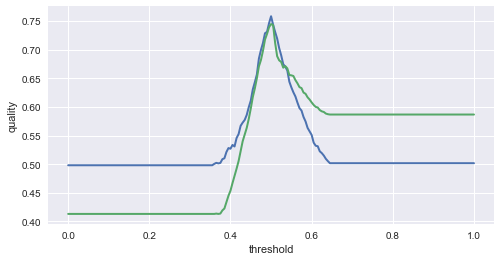

In [34]:
nnclf_params = {"input_shape":700, "layers_conf":[90]}
nnfit_params = {}
nn_res3 = cv_fit_predict(NNC, tt, nn_f, nnclf_params, nnfit_params, do_scaling = True)
nn_p3, nn_pr3 = combine_results(nn_res3, cv, df.shape[0])
review(df, nn_p3, nn_pr3, "ibs", plot=True, text=True)

In [36]:
new_df = pd.DataFrame(data={"ibs":df["ibs"], "ECG_ID":df["ECG_ID"], "NN_PR":nn_pr3, "NN_P2":nn_p3})

In [42]:
new_df.to_csv("nn_results.csv")

In [45]:
p3 = np.zeros(nn_pr2.shape[0])
p3[nn_pr2 > 0.49] = 1
f1_score(df["ibs"], p3)

0.71954314720812185

In [41]:
roc_auc_score(df["ibs"], nn_pr3)

0.79678516071007122